# NTA Data Analysis Framework

## Program Description
This comprehensive program analyzes Nanoparticle Tracking Analysis (NTA) data files generated by ZetaView (Particle Metrix QUATT, ZetaView version 8.06.01 SP1). The framework handles both single-file and multi-file (replicate) analysis, performing sophisticated data averaging with uncertainty propagation, calculating key statistical parameters, and generating comprehensive visualizations and output files.

## Author
- Heike Boehm, Department of Cellular Biophysics, MPI for Medical Research (MPImF-CBP-GS)

## References
This analysis framework is based on data generated according to:
- Particle Metrix GmbH. (2020). Operating Instructions for ZetaView Nanoparticle Tracking Analyzers PMX-120, PMX-220, PMX-420 (Version 4.2).

## Complete Analysis Workflow
The program follows a linear workflow executed sequentially:

### 1. **File Selection Module** (Cell 01)
   - Interactive selection of single or multiple NTA files
   - Configuration settings and file validation

### 2. **File I/O Module** (Cell 02)
   - Reading NTA files with latin1 encoding
   - Section identification and structure validation

### 3. **Data Extraction and Averaging Module** (Cell 03)
   - Extraction from linear and logarithmic scales
   - **Multi-file averaging**: Bin-by-bin averaging across replicates: x̄ᵢ = (1/n)Σⱼ xᵢⱼ
   - **Standard deviation calculation**: Sample standard deviation for each bin: sᵢ = √[(1/(n-1))Σⱼ(xᵢⱼ - x̄ᵢ)²]

### 4. **Automated Metadata Extraction** (Cell 04)
   - Comprehensive metadata extraction using regex patterns
   - Cross-file comparison and quality control flagging

### 5. **Core Calculations with Uncertainty Propagation** (Cell 05)
   - **Dilution correction**: Cₛₐₘₚₗₑ = Cₘₑₐₛᵤᵣₑ𝒹 × D, with σₛₐₘₚₗₑ = σₘₑₐₛᵤᵣₑ𝒹 × D
   - **Area normalization**: f_norm(x) = f(x) / ∫f(x)dx using trapezoidal integration
   - **Cumulative uncertainty**: σ_cumsum[j] = √(Σᵢ₌₀ʲ σᵢ²) for independent errors
   - Total metrics calculation with uncertainty combination

### 6. **Statistics with Bounds-Based Uncertainty** (Cell 06)
   - **D-value calculation**: D10, D50, D90 with asymmetric confidence bounds
   - **Bounds-based approach**: Interpolation of cumsum±SD curves for uncertainty bounds
   - Statistics for number-, volume-, and surface area-weighted distributions

### 7. **Visualization Suite** (Cells 10a-10f)
   - **Number-weighted plots**: Shape analysis with lognormal fits (linear and log scales)
   - **Volume-weighted plots**: Volume contribution analysis with lognormal fits (linear and log scales)
   - **Count vs. theoretical surface area plots**: Distribution of different surface area bins with lognormal fits (linear and log scales)
   - **Surface area-weighted plots**: Surface area analysis with lognormal fits (linear and log scales)
   - **Count vs. theoretical volume plots**: Distribution of different volume bins with lognormal fits (linear and log scales)
   - **Raw particle count plots**: Quality control with instrument settings
   - Each plot: main distribution + cumulative distribution with error bars and D-value markers

## Data Processing and Uncertainty Propagation

### Multi-File Averaging
For replicate analysis:
1. **Bin-by-bin averaging**: x̄ᵢ = (1/n)Σⱼ xᵢⱼ for each size bin i across n replicates
2. **Sample standard deviation**: sᵢ = √[(1/(n-1))Σⱼ(xᵢⱼ - x̄ᵢ)²]
3. **Error propagation**: Uncertainties maintained through all mathematical operations

### Statistical Methods
- **Cumulative uncertainty**: σ_cumsum[j] = √(Σᵢ₌₀ʲ σᵢ²) for cumulative distributions
- **Bounds-based D-values**: Asymmetric confidence intervals via interpolation of cumsum±SD curves
- **Total metrics uncertainty**: σ_total = √(Σᵢ σᵢ²) for summed quantities

### Distribution Types
- **Number-weighted**: Area-normalized for shape analysis: ∫f_norm(x)dx = 1
- **Volume/Surface area-weighted**: Absolute quantities per mL with dilution correction

## Output Files and Visualizations
The framework generates a complete set of standardized output files:

### Metadata Files
- **`Data_[uniqueID]_metadata.txt`**: Comprehensive metadata with measurement parameters, quality control flags, calculated metrics, and total volume/surface area per mL (enabling normalization for samples with identical volumes/areas)

### Distribution Data
- **`Data_[uniqueID]_PSD.txt`**: Complete particle size distribution data with uncertainties for all scales and distribution types

### Statistical Summaries
- **`Stats_[uniqueID]_comprehensive.txt`**: D-values, span, and total metrics with uncertainty bounds for all distribution types

### Visualization Files
- **Number-weighted plots**: `Plot_[uniqueID]_linear_number.pdf/png` and `Plot_[uniqueID]_log_number.pdf/png`
- **Volume-weighted plots**: `Plot_[uniqueID]_linear_volume.pdf/png` and `Plot_[uniqueID]_log_volume.pdf/png`
- **Surface area-weighted plots**: `Plot_[uniqueID]_linear_surface_area.pdf/png` and `Plot_[uniqueID]_log_surface_area.pdf/png`
- **Quality control plots**: `Plot_[uniqueID]_raw_counts.pdf/png`
- **Count-vs-theoretical surface area plots**: `Plot_[uniqueID]_linear_count_vs_surface_area.pdf/png` and `Plot_[uniqueID]_log_count_vs_surface_area.pdf/png`
- **Count-vs-theoretical volume area plots**: `Plot_[uniqueID]_linear_count_vs_volume.pdf/png` and `Plot_[uniqueID]_log_count_vs_volume.pdf/png`

### Model Fitting Results
- **`Fits_[uniqueID]_all.json`**: Comprehensive fitting parameters for all distribution types and scales

## Key Features
- **Replicate handling**: Automatic averaging with rigorous uncertainty quantification
- **Quality control**: Built-in validation and alert systems  
- **Multiple weightings**: Number, volume, and surface area perspectives
- **Comprehensive statistics**: D-values with asymmetric confidence bounds
- **Standardized output**: Consistent file formats for downstream analysis
- **Total metrics**: Volume and surface area per mL saved in metadata for sample comparison

## Usage Notes
- Execute cells sequentially from Cell 01 through visualization cells
- Single-file analysis: standard deviations = 0, complete pipeline still applies
- Configuration settings in Cell 01 must match your directory structure

In [1]:
"""
NTA Data Analysis - Multi-file Selection Module (Cell 01)

This module provides file selection for single or multiple NTA files
for replicate analysis with averaging and standard deviation calculations.
"""

import os
import re

if 'CONFIG' not in globals():
    CONFIG = {
        "directory": "Inbox",  # Update this path
        "file_identifier": ".txt",
        "output_subdirs": ["metadata", "processed"],
        "nta_concentration_calibration_factor": 4.61E+5,  # Default ZetaView calibration
        "project_metadata": {
            "experimenter": "Your_Initials",
            "location": "Your_Lab_Location",
            "project": "Your_Project_Name",
            "meta_version": "v03",
            "pi": "Principal_Investigator_Initials",
            "funding": "Funding_Source",
            "data_collection_method": "NTA",
            "unit_of_analysis": '["nm", "nm^2", "nm^3"]',
            "keywords": "particle_size_distribution",
            "publications": "None",
        }
    }

def set_data_directory(directory_path):
    """
    Set or update the data directory in CONFIG.
    
    Parameters:
    directory_path (str): Path to directory containing NTA data
    
    Returns:
    bool: True if directory exists and was set, False otherwise
    """
    global CONFIG
    
    # Validate directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory not found: {directory_path}")
        return False
    
    # Update CONFIG with new directory
    CONFIG["directory"] = directory_path
    
    # Ensure output subdirectories exist
    for subdir in CONFIG["output_subdirs"]:
        output_dir = os.path.join(directory_path, subdir)
        os.makedirs(output_dir, exist_ok=True)
    
    print(f"Data directory set to: {directory_path}")
    print(f"Output directories created/verified.")
    
    return True

def find_nta_files():
    """
    Find NTA data files in the current directory.
    
    Returns:
    list: List of NTA files, or empty list if none found
    """
    directory = CONFIG["directory"]
    file_identifier = CONFIG["file_identifier"]
    
    # Validate directory exists
    if not os.path.exists(directory):
        print(f"Error: Directory not found: {directory}")
        return []
    
    # Find all matching files
    all_files = os.listdir(directory)
    nta_files = [f for f in all_files if f.endswith(file_identifier)]
    
    return nta_files

def extract_sample_info(filename):
    """
    Extract sample information from filename for more readable display.
    
    Parameters:
    filename (str): Filename to analyze
    
    Returns:
    str: Formatted sample information
    """
    # Remove common prefixes and suffixes
    base_name = filename.replace("_rawdata.txt", "").replace("size_NTA", "")
    
    if base_name.startswith("Data_"):
        base_name = base_name[5:]
    
    # Look for date pattern (e.g., 20250311)
    date_match = re.search(r'_(\d{8})_', base_name)
    date_str = ""
    if date_match:
        date = date_match.group(1)
        date_str = f" (Date: {date[0:4]}-{date[4:6]}-{date[6:8]})"
    
    return f"{base_name}{date_str}"

def parse_indices(indices_input):
    """
    Parse file indices from string input.
    
    Parameters:
    indices_input (str): Comma-separated indices (e.g., "0,1,2" or "0")
    
    Returns:
    list: List of integer indices, or empty list if invalid
    """
    try:
        # Remove spaces and split by commas
        indices_str = indices_input.replace(" ", "").split(",")
        indices = [int(idx) for idx in indices_str if idx.strip()]
        return indices
    except ValueError:
        print(f"Error: Invalid indices format. Use comma-separated numbers (e.g., '0,1,2')")
        return []

def select_files(indices_input):
    """
    Select multiple files by indices for replicate analysis.
    
    Parameters:
    indices_input (str): Comma-separated string of indices (e.g., "0,1,2")
    
    Returns:
    tuple: (filenames_list, filepaths_list) or (None, None) if invalid
    """
    nta_files = find_nta_files()
    
    if not nta_files:
        print("No NTA files found in the current directory.")
        return None, None
    
    # Parse indices
    indices = parse_indices(indices_input)
    if not indices:
        return None, None
    
    # Validate indices
    invalid_indices = [idx for idx in indices if idx < 0 or idx >= len(nta_files)]
    if invalid_indices:
        print(f"Invalid file indices: {invalid_indices}. Must be between 0 and {len(nta_files)-1}")
        return None, None
    
    # Remove duplicates while preserving order
    unique_indices = []
    for idx in indices:
        if idx not in unique_indices:
            unique_indices.append(idx)
    
    # Select files
    selected_filenames = []
    selected_filepaths = []
    
    for idx in unique_indices:
        filename = nta_files[idx]
        filepath = os.path.join(CONFIG["directory"], filename)
        selected_filenames.append(filename)
        selected_filepaths.append(filepath)
    
    # Display selection
    print(f"\nSelected {len(selected_filenames)} file(s) for analysis:")
    for i, (idx, filename) in enumerate(zip(unique_indices, selected_filenames)):
        print(f"  File {i+1}: #{idx} - {filename}")
    
    # Set global variables for use in other cells (always as lists)
    global selected_filenames_list, selected_filepaths_list, num_replicates
    selected_filenames_list = selected_filenames
    selected_filepaths_list = selected_filepaths
    num_replicates = len(selected_filenames)
    
    print(f"\nNumber of replicates: {num_replicates}")
    if num_replicates == 1:
        print("Single file analysis - SD values will be 0")
    else:
        print("Multi-file analysis - averaging with SD calculations")
    
    return selected_filenames, selected_filepaths

# Set a custom directory (uncomment and modify if needed)
# set_data_directory("/path/to/your/data")

# List available files
print("=" * 80)
print("NTA DATA ANALYSIS - MULTI-FILE SELECTION")
print("=" * 80)
print(f"Current directory: {CONFIG['directory']}")
print()

nta_files = find_nta_files()
if nta_files:
    print(f"Found {len(nta_files)} NTA files:")
    for i, file in enumerate(nta_files):
        print(f"  {i}: {file}")
    
    print("\nTo select files belonging to the same sample for analysis:")
    print("  Single file: select_files('0')")
    print("  Multiple files: select_files('0,1,2')")
    print("  Example: select_files('0,2,5') for files 0, 2, and 5")
else:
    print("No NTA files found in the current directory.")
    print("Please set a different directory using set_data_directory()")

print("=" * 80)

# Initialize global variables for file selection (always as lists)
selected_filenames_list = None
selected_filepaths_list = None
num_replicates = 0

# Default selection - uncomment to automatically select the first file
# if nta_files:
#     select_files('0')

NTA DATA ANALYSIS - MULTI-FILE SELECTION
Current directory: /Users/hboehm/Seafile/LEAF/NTA_data/!Inbox/20250527

Found 47 NTA files:
  0: 20250527_0004_23052025_SUV_5136664_after6weeks_size_488.txt
  1: 20250527_0013_23052025_SUV_5268891_after3weeks_size_488_11pos.txt
  2: 20250527_0011_23052025_SUV_5268891_after3weeks_size_488.txt
  3: 20250527_0018_23052025_SUV_5269296_after3weeks_size_488.txt
  4: 2025-03-25_142258_nvs.txt
  5: 20250527_0008_23052025_SUV_519687_after7weeks_size_488_11pos.txt
  6: 20250527_0012_23052025_SUV_5268891_after3weeks_size_488_11pos.txt
  7: 20250527_0014_23052025_SUV_5268891_after3weeks_size_488_11pos.txt
  8: 20250527_0019_23052025_SUV_5268891_4GradC_size_488_11pos.txt
  9: 20250527_0015_23052025_SUV_5269296_after3weeks_size_488.txt
  10: 20250527_0025_23052025_SUV_5268891_FrozenwithBSA_size_488.txt
  11: 20250527_0005_23052025_SUV_5136664_after6weeks_size_488.txt
  12: 20250527_0023_23052025_SUV_5268891_Frozen_size_488_11pos.txt
  13: 20250527_0023_230520

In [2]:
select_files('0,11,16')


Selected 3 file(s) for analysis:
  File 1: #0 - 20250527_0004_23052025_SUV_5136664_after6weeks_size_488.txt
  File 2: #11 - 20250527_0005_23052025_SUV_5136664_after6weeks_size_488.txt
  File 3: #16 - 20250527_0006_23052025_SUV_5136664_after6weeks_size_488.txt

Number of replicates: 3
Multi-file analysis - averaging with SD calculations


(['20250527_0004_23052025_SUV_5136664_after6weeks_size_488.txt',
  '20250527_0005_23052025_SUV_5136664_after6weeks_size_488.txt',
  '20250527_0006_23052025_SUV_5136664_after6weeks_size_488.txt'],
 ['/Users/hboehm/Seafile/LEAF/NTA_data/!Inbox/20250527/20250527_0004_23052025_SUV_5136664_after6weeks_size_488.txt',
  '/Users/hboehm/Seafile/LEAF/NTA_data/!Inbox/20250527/20250527_0005_23052025_SUV_5136664_after6weeks_size_488.txt',
  '/Users/hboehm/Seafile/LEAF/NTA_data/!Inbox/20250527/20250527_0006_23052025_SUV_5136664_after6weeks_size_488.txt'])

In [3]:
"""
NTA Data Analysis - Multi-file I/O Module (Cell 02)

This module handles:
1. Reading multiple NTA data files
2. Identifying key sections in file content
3. Validating file structure before processing
4. Handling errors gracefully by skipping problematic files

"""

import os
import re


def read_nta_file(filepath):
    """
    Read an NTA data file with appropriate encoding.
    
    Parameters:
    filepath (str): Path to the NTA file
    
    Returns:
    tuple: (success_flag, result)
        - If successful: (True, file_content)
        - If failed: (False, error_message)
    """
    try:
        with open(filepath, 'r', encoding='latin1') as file:
            content = file.read()
        
        if not content or len(content) < 100:
            return False, f"File appears to be empty or too small: {filepath}"
        
        return True, content
    except Exception as e:
        return False, f"Error reading file: {str(e)}"


def identify_sections(content):
    """
    Identify key data sections in the file content.
    
    Parameters:
    content (str): File content to analyze
    
    Returns:
    tuple: (success_flag, result)
        - If successful: (True, dict_of_sections)
        - If failed: (False, error_message)
    """
    sections = {}
    
    # Find linear size distribution section
    size_lin_start = content.find("Size Distribution")
    if size_lin_start == -1:
        return False, "Could not find 'Size Distribution' section for linear data"
    sections['linear_start'] = size_lin_start
    
    # Find logarithmic data section (starts with -1.000E+0 separator)
    size_log_start = content.find("-1.000E+0")
    if size_log_start == -1:
        # Try alternative approach - look for second "Size / nm" header
        second_header = content.find("Size / nm", size_lin_start + 100)
        if second_header == -1:
            return False, "Could not find logarithmic data section"
        sections['logarithmic_start'] = second_header
    else:
        sections['logarithmic_start'] = size_log_start
    
    # Validate section order
    if sections['linear_start'] >= sections['logarithmic_start']:
        return False, "Invalid file structure: linear section should come before logarithmic section"
    
    return True, sections


def validate_file_structure(content, sections):
    """
    Validate file structure to ensure it can be processed.
    
    Parameters:
    content (str): File content
    sections (dict): Section positions from identify_sections
    
    Returns:
    tuple: (success_flag, message)
    """
    # Check linear section has expected header pattern
    linear_section = content[sections['linear_start']:sections['logarithmic_start']]
    if not re.search(r'Size / nm\s+Number\s+Concentration', linear_section):
        return False, "Missing expected header pattern in linear section"
    
    # Check logarithmic section has data in expected format
    log_section = content[sections['logarithmic_start']:]
    if not re.search(r'[\d.-]+E[\+\-]\d+\s+[\d.-]+E[\+\-]\d+', log_section):
        return False, "Could not find data rows in logarithmic section"
    
    return True, "File structure is valid"


def process_single_file_content(filepath):
    """
    Complete file processing workflow for a single file.
    
    Parameters:
    filepath (str): Path to the NTA file
    
    Returns:
    tuple: (success_flag, result)
        - If successful: (True, (content, sections))
        - If failed: (False, error_message)
    """
    # Read the file
    success, result = read_nta_file(filepath)
    if not success:
        return False, result
    content = result
    
    # Identify sections
    success, result = identify_sections(content)
    if not success:
        return False, result
    sections = result
    
    # Validate structure
    success, message = validate_file_structure(content, sections)
    if not success:
        return False, message
    
    return True, (content, sections)


def process_multiple_file_contents(filepaths):
    """
    Process multiple NTA files, skipping any that fail with error messages.
    
    Parameters:
    filepaths (list): List of file paths to process
    
    Returns:
    tuple: (file_data_list, error_summary)
        - file_data_list: List of (filename, content, sections) for successful files
        - error_summary: Dict with failed files and their error messages
    """
    successful_files = []
    failed_files = {}
    
    print(f"Processing {len(filepaths)} file(s)...")
    
    for filepath in filepaths:
        filename = os.path.basename(filepath)
        print(f"  Processing: {filename}")
        
        success, result = process_single_file_content(filepath)
        
        if success:
            content, sections = result
            successful_files.append((filename, content, sections))
            print(f"    ✓ Success")
        else:
            failed_files[filename] = result
            print(f"    ✗ Failed: {result}")
    
    # Summary
    print(f"\nProcessing complete:")
    print(f"  Successful: {len(successful_files)} files")
    print(f"  Failed: {len(failed_files)} files")
    
    if failed_files:
        print("\nFailed files:")
        for filename, error in failed_files.items():
            print(f"  {filename}: {error}")
    
    return successful_files, failed_files


def preview_file_content(content, max_chars=500):
    """
    Display a preview of the file content to verify it was read correctly.
    
    Parameters:
    content (str): File content to preview
    max_chars (int): Maximum number of characters to display
    
    Returns:
    str: Preview text for display
    """
    preview = content[:max_chars]
    return "-" * 50 + "\n" + preview + "\n" + "-" * 50


# Execute file processing if files were selected in Cell 00
if 'selected_filepaths_list' in globals() and selected_filepaths_list:
    print("=" * 80)
    print("PROCESSING SELECTED NTA FILES")
    print("=" * 80)
    
    # Process all selected files
    successful_files, failed_files = process_multiple_file_contents(selected_filepaths_list)
    
    if successful_files:
        print(f"\nSuccessfully processed {len(successful_files)} file(s):")
        for filename, content, sections in successful_files:
            print(f"  {filename}")
            print(f"    Linear section at position: {sections['linear_start']}")
            print(f"    Logarithmic section at position: {sections['logarithmic_start']}")
        
        # Show preview of first file
        if successful_files:
            first_filename, first_content, first_sections = successful_files[0]
            print(f"\nFile Preview ({first_filename}):")
            print(preview_file_content(first_content))
        
        # Store results for use in subsequent cells
        current_files_data = successful_files
        current_failed_files = failed_files
        
        print("\nFile processing completed successfully!")
        print("Ready for data extraction and averaging (Cell 03)")
        
    else:
        print("\nERROR: No files could be processed successfully.")
        if failed_files:
            print("All files failed with errors (see details above).")
        
else:
    print("No files selected. Please run Cell 00 (file selection) first.")
    print("Use: select_files('0,1,2') to select files for analysis.")

PROCESSING SELECTED NTA FILES
Processing 3 file(s)...
  Processing: 20250527_0004_23052025_SUV_5136664_after6weeks_size_488.txt
    ✓ Success
  Processing: 20250527_0005_23052025_SUV_5136664_after6weeks_size_488.txt
    ✓ Success
  Processing: 20250527_0006_23052025_SUV_5136664_after6weeks_size_488.txt
    ✓ Success

Processing complete:
  Successful: 3 files
  Failed: 0 files

Successfully processed 3 file(s):
  20250527_0004_23052025_SUV_5136664_after6weeks_size_488.txt
    Linear section at position: 850
    Logarithmic section at position: 56536
  20250527_0005_23052025_SUV_5136664_after6weeks_size_488.txt
    Linear section at position: 837
    Logarithmic section at position: 56523
  20250527_0006_23052025_SUV_5136664_after6weeks_size_488.txt
    Linear section at position: 836
    Logarithmic section at position: 56522

File Preview (20250527_0004_23052025_SUV_5136664_after6weeks_size_488.txt):
--------------------------------------------------
Original File:	C:\Users\ZetaView\D

In [4]:
"""
NTA Data Analysis - Data Extraction and Averaging Module (Cell 03)

This module handles:
1. Extracting distribution data from multiple NTA files
2. Averaging raw particle counts bin-by-bin across replicates
3. Calculating standard deviations for each size bin
4. Creating a single averaged dataset for downstream analysis

"""

import pandas as pd
import numpy as np
import re


def extract_data_section(content, start_pos, end_pos=None, is_log_section=False):
    """
    Extract tabular data from a section of the file content.
    
    Parameters:
    content (str): File content
    start_pos (int): Starting position of the section
    end_pos (int, optional): Ending position of the section
    is_log_section (bool): Whether this is the logarithmic section
    
    Returns:
    tuple: (success_flag, result)
        - If successful: (True, (header, data_lines))
        - If failed: (False, error_message)
    """
    # Extract the section
    section = content[start_pos:end_pos]
    
    # For logarithmic section, skip past the separator line
    if is_log_section:
        sep_pos = section.find("-1.000E+0")
        if sep_pos != -1:
            sep_line_end = section.find('\n', sep_pos)
            if sep_line_end != -1:
                section = section[sep_line_end + 1:]
            else:
                section = section[sep_pos + 20:]
        
        # Sometimes there's a second "Size Distribution" header
        second_header = section.find("Size Distribution")
        if second_header != -1:
            section = section[second_header:]
    
    # Find the header line
    header_match = re.search(r'Size / nm\s+Number\s+Concentration.+', section)
    
    if not header_match and is_log_section:
        # For log section, try more relaxed pattern or use default
        header_match = re.search(r'Size.*Number', section)
        if not header_match:
            header_line = "Size / nm\tNumber\tConcentration / cm-3\tVolume / nm^3\tArea / nm^2"
            data_lines = []
            for line in section.split('\n'):
                if "-1.000E+0" in line:
                    continue
                if re.match(r'^\s*[\d.-]+E[\+\-]\d+\s+[\d.-]+E[\+\-]\d+', line):
                    data_lines.append(line)
            
            if not data_lines:
                return False, "Could not find any valid data lines in logarithmic section"
            return True, (header_line, data_lines)
        else:
            header_line = header_match.group(0)
            data_start = section.find(header_line) + len(header_line)
            data_section = section[data_start:]
    else:
        if header_match:
            header_line = header_match.group(0)
            data_start = section.find(header_line) + len(header_line)
            data_section = section[data_start:]
        else:
            return False, "Could not find header line in data section"
    
    # Extract data lines
    all_lines = data_section.split('\n')
    data_lines = []
    
    for line in all_lines:
        if "-1.000E+0" in line:
            continue
        if re.match(r'^\s*[\d.-]+E[\+\-]\d+\s+[\d.-]+E[\+\-]\d+', line):
            data_lines.append(line)
        elif len(data_lines) > 0 and (line.strip() == '' or line.strip().startswith('-')):
            break
    
    if not data_lines:
        return False, "No data lines found in section"
    
    return True, (header_line, data_lines)


def parse_data_lines(header_line, data_lines, scale_type):
    """
    Parse data lines into a structured DataFrame.
    
    Parameters:
    header_line (str): Header line with column names
    data_lines (list): List of data lines to parse
    scale_type (str): Type of scale ('linear' or 'logarithmic')
    
    Returns:
    tuple: (success_flag, result)
        - If successful: (True, DataFrame)
        - If failed: (False, error_message)
    """
    parsed_data = []
    
    for line in data_lines:
        if "-1.000E+0" in line:
            continue
            
        values = re.findall(r'[\d.-]+E[\+\-]\d+', line)
        
        if len(values) >= 5:
            try:
                if values[0] == "-1.000E+0":
                    continue
                
                row = {
                    'size_nm': float(values[0]),
                    'number': float(values[1]),
                    'concentration_cm-3': float(values[2]),
                    'volume_nm^3': float(values[3]),
                    'area_nm^2': float(values[4]),
                    'scale': scale_type
                }
                parsed_data.append(row)
            except ValueError as e:
                print(f"Error parsing line: {e}")
                continue
    
    if not parsed_data:
        return False, f"Failed to parse any data lines for {scale_type} scale"
    
    return True, pd.DataFrame(parsed_data)


def extract_single_file_distribution(content, sections, filename):
    """
    Extract distribution data from a single file.
    
    Parameters:
    content (str): File content
    sections (dict): Dictionary with section positions
    filename (str): Filename for reference
    
    Returns:
    tuple: (success_flag, result)
        - If successful: (True, combined_df)
        - If failed: (False, error_message)
    """
    # Extract linear data
    lin_start = sections['linear_start']
    log_start = sections['logarithmic_start']
    
    success, lin_result = extract_data_section(content, lin_start, log_start, is_log_section=False)
    if not success:
        return False, f"Failed to extract linear data from {filename}: {lin_result}"
    
    lin_header, lin_data_lines = lin_result
    success, lin_df = parse_data_lines(lin_header, lin_data_lines, 'linear')
    if not success:
        return False, f"Failed to parse linear data from {filename}: {lin_df}"
    
    # Extract logarithmic data
    success, log_result = extract_data_section(content, log_start, is_log_section=True)
    if not success:
        print(f"Warning: Could not extract logarithmic data from {filename}: {log_result}")
        combined_df = lin_df.copy()
    else:
        log_header, log_data_lines = log_result
        success, log_df = parse_data_lines(log_header, log_data_lines, 'logarithmic')
        if not success:
            print(f"Warning: Could not parse logarithmic data from {filename}: {log_df}")
            combined_df = lin_df.copy()
        else:
            combined_df = pd.concat([lin_df, log_df], ignore_index=True)
    
    # Add filename for tracking
    combined_df['source_file'] = filename
    
    return True, combined_df


def average_replicate_data(dataframes_list, filenames_list):
    """
    Average distribution data across multiple replicates bin-by-bin.
    
    Parameters:
    dataframes_list (list): List of DataFrames from individual files
    filenames_list (list): List of filenames for reference
    
    Returns:
    tuple: (success_flag, result)
        - If successful: (True, averaged_df)
        - If failed: (False, error_message)
    """
    if not dataframes_list:
        return False, "No dataframes to average"
    
    if len(dataframes_list) == 1:
        # Single file case - add SD columns with zeros
        df = dataframes_list[0].copy()
        
        # Add SD columns (all zeros for single file)
        df['number_sd'] = 0.0
        df['concentration_cm-3_sd'] = 0.0
        df['volume_nm^3_sd'] = 0.0
        df['area_nm^2_sd'] = 0.0
        
        # Rename value columns to indicate they're averages
        df.rename(columns={
            'number': 'number_avg',
            'concentration_cm-3': 'concentration_cm-3_avg',
            'volume_nm^3': 'volume_nm^3_avg',
            'area_nm^2': 'area_nm^2_avg'
        }, inplace=True)
        
        # Add replicate info
        df['num_replicates'] = 1
        df['source_files'] = filenames_list[0]
        
        print(f"Single file analysis: {filenames_list[0]}")
        print("Standard deviation values set to 0")
        
        return True, df
    
    # Multiple files case - perform averaging
    print(f"Averaging data from {len(dataframes_list)} files:")
    for filename in filenames_list:
        print(f"  {filename}")
    
    # Process each scale separately
    averaged_dfs = []
    
    for scale in ['linear', 'logarithmic']:
        scale_dfs = []
        for df in dataframes_list:
            scale_data = df[df['scale'] == scale]
            if not scale_data.empty:
                scale_dfs.append(scale_data)
        
        if not scale_dfs:
            continue
        
        # Find common size bins across all files
        all_sizes = []
        for df in scale_dfs:
            all_sizes.extend(df['size_nm'].values)
        unique_sizes = sorted(set(all_sizes))
        
        # Create averaged data for this scale
        averaged_data = []
        
        for size in unique_sizes:
            # Collect values for this size across all files
            numbers = []
            concentrations = []
            volumes = []
            areas = []
            
            for df in scale_dfs:
                size_row = df[df['size_nm'] == size]
                if not size_row.empty:
                    numbers.append(size_row['number'].iloc[0])
                    concentrations.append(size_row['concentration_cm-3'].iloc[0])
                    volumes.append(size_row['volume_nm^3'].iloc[0])
                    areas.append(size_row['area_nm^2'].iloc[0])
            
            # Calculate averages and standard deviations
            if numbers:  # Only if we have data for this size
                row = {
                    'size_nm': size,
                    'number_avg': np.mean(numbers),
                    'number_sd': np.std(numbers, ddof=1) if len(numbers) > 1 else 0.0,
                    'concentration_cm-3_avg': np.mean(concentrations),
                    'concentration_cm-3_sd': np.std(concentrations, ddof=1) if len(concentrations) > 1 else 0.0,
                    'volume_nm^3_avg': np.mean(volumes),
                    'volume_nm^3_sd': np.std(volumes, ddof=1) if len(volumes) > 1 else 0.0,
                    'area_nm^2_avg': np.mean(areas),
                    'area_nm^2_sd': np.std(areas, ddof=1) if len(areas) > 1 else 0.0,
                    'scale': scale,
                    'num_replicates': len(numbers),
                    'source_files': '; '.join(filenames_list)
                }
                averaged_data.append(row)
        
        if averaged_data:
            scale_df = pd.DataFrame(averaged_data)
            averaged_dfs.append(scale_df)
    
    if not averaged_dfs:
        return False, "No data could be averaged"
    
    # Combine linear and logarithmic scales
    final_df = pd.concat(averaged_dfs, ignore_index=True)
    
    # Sort by scale and size
    final_df = final_df.sort_values(['scale', 'size_nm']).reset_index(drop=True)
    
    print(f"Averaging completed:")
    print(f"  Total size bins: {len(final_df)}")
    print(f"  Linear scale bins: {len(final_df[final_df['scale'] == 'linear'])}")
    print(f"  Log scale bins: {len(final_df[final_df['scale'] == 'logarithmic'])}")
    
    return True, final_df


# Execute data extraction and averaging if files were processed in Cell 02
if 'current_files_data' in globals() and current_files_data:
    print("=" * 80)
    print("EXTRACTING AND AVERAGING DISTRIBUTION DATA")
    print("=" * 80)
    
    # Extract data from each file
    individual_dataframes = []
    filenames = []
    extraction_errors = []
    
    for filename, content, sections in current_files_data:
        print(f"Extracting data from: {filename}")
        
        success, result = extract_single_file_distribution(content, sections, filename)
        
        if success:
            individual_dataframes.append(result)
            filenames.append(filename)
            print(f"  ✓ Extracted {len(result)} data points")
        else:
            extraction_errors.append((filename, result))
            print(f"  ✗ Failed: {result}")
    
    if individual_dataframes:
        # Average the data across replicates
        print(f"\nAveraging data from {len(individual_dataframes)} successful file(s)...")
        
        success, averaged_df = average_replicate_data(individual_dataframes, filenames)
        
        if success:
            # Store results for downstream cells (mimicking old format)
            current_distribution_df = averaged_df
            current_file_content = None  # Not applicable for averaged data
            current_file_sections = None  # Not applicable for averaged data
            
            # Add uniqueID based on first filename
            first_filename = filenames[0]
            # Extract base name for uniqueID
            base_name = first_filename.replace('_rawdata.txt', '').replace('.txt', '')
            if base_name.startswith('Data_'):
                base_name = base_name[5:]
            
            # For multiple files, add indication
            if len(filenames) > 1:
                uniqueID = f"{base_name}_avg{len(filenames)}"
            else:
                uniqueID = base_name
            
            current_distribution_df['uniqueID'] = uniqueID
            
            print(f"\nData extraction and averaging completed successfully!")
            print(f"Dataset ID: {uniqueID}")
            print(f"Ready for metadata extraction (Cell 04)")
            
            # Display preview
            print(f"\nAveraged Data Preview:")
            display(current_distribution_df.head())
            
        else:
            print(f"\nERROR: Failed to average data: {averaged_df}")
    
    else:
        print(f"\nERROR: No files could be processed for data extraction.")
        if extraction_errors:
            print("Extraction errors:")
            for filename, error in extraction_errors:
                print(f"  {filename}: {error}")

else:
    print("No processed files found. Please run Cell 02 (file processing) first.")
    print("Make sure to run Cell 00 (file selection) before Cell 02.")

EXTRACTING AND AVERAGING DISTRIBUTION DATA
Extracting data from: 20250527_0004_23052025_SUV_5136664_after6weeks_size_488.txt
  ✓ Extracted 1400 data points
Extracting data from: 20250527_0005_23052025_SUV_5136664_after6weeks_size_488.txt
  ✓ Extracted 1400 data points
Extracting data from: 20250527_0006_23052025_SUV_5136664_after6weeks_size_488.txt
  ✓ Extracted 1400 data points

Averaging data from 3 successful file(s)...
Averaging data from 3 files:
  20250527_0004_23052025_SUV_5136664_after6weeks_size_488.txt
  20250527_0005_23052025_SUV_5136664_after6weeks_size_488.txt
  20250527_0006_23052025_SUV_5136664_after6weeks_size_488.txt
Averaging completed:
  Total size bins: 1400
  Linear scale bins: 1200
  Log scale bins: 200

Data extraction and averaging completed successfully!
Dataset ID: 20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3
Ready for metadata extraction (Cell 04)

Averaged Data Preview:


,size_nm,number_avg,number_sd,concentration_cm-3_avg,concentration_cm-3_sd,volume_nm^3_avg,volume_nm^3_sd,area_nm^2_avg,area_nm^2_sd,scale,num_replicates,source_files,uniqueID
0,2.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,linear,3,20250527_0004_23052025_SUV_5136664_after6weeks...,20250527_0004_23052025_SUV_5136664_after6weeks...
1,7.5,1.666667,1.527525,32986.666667,33115.746003,368.166667,337.430324,73.620000,67.468609,linear,3,20250527_0004_23052025_SUV_5136664_after6weeks...,20250527_0004_23052025_SUV_5136664_after6weeks...
2,12.5,1.666667,0.577350,30893.333333,14263.962750,1704.333333,590.051975,204.500000,70.840878,linear,3,20250527_0004_23052025_SUV_5136664_after6weeks...,20250527_0004_23052025_SUV_5136664_after6weeks...
3,17.5,2.000000,2.000000,31970.000000,31596.855856,5610.666667,5610.000119,481.066667,481.050001,linear,3,20250527_0004_23052025_SUV_5136664_after6weeks...,20250527_0004_23052025_SUV_5136664_after6weeks...
4,22.5,1.000000,1.732051,15796.666667,27360.629257,5963.333333,10328.796316,397.666667,688.778871,linear,3,20250527_0004_23052025_SUV_5136664_after6weeks...,20250527_0004_23052025_SUV_5136664_after6weeks...


In [5]:
"""
NTA Data Analysis - Automated Modular Metadata System (Cell 04)

This module handles:
1. Automated extraction of ALL metadata fields from multiple files
2. Automatic detection of differences vs. identical values
3. Smart array creation for differing values
4. Detailed conflict reporting for analysis

"""

import os
import re
import json
import ntpath  
from datetime import date


def extract_all_metadata_fields(content, filename):
    """
    Extract ALL possible metadata fields from file content using comprehensive regex patterns.
    
    Parameters:
    content (str): File content to extract metadata from
    filename (str): Original filename for reference
    
    Returns:
    dict: Dictionary with all found metadata fields
    """
    # Comprehensive regex patterns for ALL possible NTA metadata fields
    metadata_patterns = [
        ('original_file', r'Original File:\s+(.+?)(?:\s+Section:|$)'),
        ('section', r'Section:\s+(.+)'),
        ('operator', r'Operator:\s+(.+)'),
        ('experiment', r'Experiment:\s+(.+)'),
        ('zetaview_sn', r'ZetaView S/N:\s+(.+)'),
        ('cell_sn', r'Cell S/N:\s+(.+)'),
        ('software', r'Software:\s+(.+?)(?:\s+Analyze:|$)'),
        ('analyze', r'Analyze:\s+(.+)'),
        ('sop', r'SOP:\s+(.+)'),
        ('sample', r'Sample:\s+(.+)'),
        ('electrolyte', r'Electrolyte:(?:\s*(.*?))?(?:\r?\n|$)'),
        ('ph', r'pH:\s+(.+?)(?:\s+entered|$)'),
        ('conductivity', r'Conductivity:\s+(.+?)(?:\s+sensed|$)'),
        ('temp_control', r'TempControl:\s+(.+)'),
        ('set_temperature', r'SetTemperature:\s+(.+)'),
        ('temperature', r'Temperature:\s+(.+?)(?:\s+sensed|$)'),
        ('viscosity', r'Viscosity:\s+(.+)'),
        ('date', r'Date:\s+(.+)'),
        ('time', r'Time:\s+(.+)'),
        ('general_remarks', r'General Remarks:\s+(.+)'),
        ('remarks', r'Remarks:\s+(.+)'),
        ('sample_info_1', r'Sample Info 1:\s+(.+)'),
        ('sample_info_2', r'Sample Info 2:\s+(.+)'),
        ('sample_info_3', r'Sample Info 3:\s*(.*)'),
        ('scattering_intensity', r'Scattering Intensity:\s+(.+)'),
        ('detected_particles', r'Detected Particles:\s+(.+)'),
        ('particle_drift_checked', r'Particle Drift Checked:\s+(.+)'),
        ('particle_drift_check_result', r'Particle Drift Check Result:\s+(.+)'),
        ('cell_check_date', r'Cell Checked:\s+(\d{4}-\d{2}-\d{2})'),
        ('cell_check_result', r'Cell Check Result:\s+(.+)'),
        ('type_of_measurement', r'Type of Measurement:\s+(.+)'),
        ('positions', r'Positions:\s+(.+)'),
        ('microscope_position', r'Microscope Position:\s+(.+)'),
        ('number_of_traces', r'Number of Traces:\s+(\d+)'),
        ('average_number_of_particles', r'Average Number of Particles:\s+(\d+\.\d+)'),
        ('dilution', r'Dilution::\s+(\d+\.\d+)'),
        ('concentration_correction_factor', r'Concentration Correction Factor:\s+(.+)'),
        ('laser_wavelength', r'Laser Wavelength nm:\s+(\d+\.\d+)'),
        ('median_number_d50', r'Median Number \(D50\):\s+(.+)'),
        ('median_concentration_d50', r'Median Concentration \(D50\):\s+(.+)'),
        ('median_volume_d50', r'Median Volume \(D50\):\s+(.+)'),
        ('minimum_brightness', r'Minimum Brightness:\s+(\d+)'),
        ('minimum_area', r'Minimum Area:\s+(\d+)'),
        ('maximum_area', r'Maximum Area:\s+(\d+)'),
        ('maximum_brightness', r'Maximum Brightness:\s+(\d+)'),
        ('tracking_radius2', r'Tracking Radius2:\s+(\d+)'),
        ('minimum_tracelength', r'Minimum Tracelength:\s+(\d+)'),
        ('fps', r'Camera:\s*FpSec\s+(\d+)\s+#Cycles'),
        ('cycles', r'#Cycles\s+(\d+)'),
        # Additional patterns for more comprehensive extraction
        ('camera_settings', r'Camera:\s+(.+)'),
        ('frame_rate', r'FRate\s+(\d+\.\d+)'),
        ('auto_settings', r'Auto:\s+(.+)'),
        ('sensitivity', r'Sensitivity:\s+(.+)'),
        ('shutter', r'Shutter:\s+(.+)'),
        ('gain', r'Gain:\s+(.+)'),
    ]
    
    # Extract metadata
    metadata = {}
    
    for key, pattern in metadata_patterns:
        match = re.search(pattern, content)
        if match:
            value = match.group(1).strip() if match.group(1) else ''
            # Clean up common issues
            if value and not value.lower() in ['none', 'null', '']:
                metadata[key] = value
    
    # Add filename and derived fields
    metadata['filename'] = filename
    
    # Extract unique ID from filename
    base_name = os.path.splitext(filename)[0]
    if base_name.endswith("_rawdata"):
        base_name = base_name[:-8]
    if base_name.startswith("Data_"):
        base_name = base_name[5:]
    metadata['uniqueID'] = base_name
    
    # Try to find AVI file information
    original_file = metadata.get('original_file', '')
    if original_file:
        avi_filename = ntpath.basename(original_file)
        metadata['avi_filename'] = avi_filename
        
        # Try to find AVI file size if file exists
        if 'CONFIG' in globals():
            directory = CONFIG.get('directory', '')
            full_avi_path = os.path.join(directory, avi_filename)
            if os.path.exists(full_avi_path) and os.path.isfile(full_avi_path):
                size_bytes = os.path.getsize(full_avi_path)
                metadata['avi_filesize'] = f"{size_bytes / (1024 * 1024):.2f} MB"
    
    return metadata


def extract_metadata_from_all_files(files_data):
    """
    Extract metadata from all files and organize by filename.
    
    Parameters:
    files_data (list): List of (filename, content, sections) tuples
    
    Returns:
    tuple: (success_flag, result)
        - If successful: (True, all_files_metadata_dict)
        - If failed: (False, error_message)
    """
    if not files_data:
        return False, "No files provided for metadata extraction"
    
    all_files_metadata = {}
    
    print(f"Extracting ALL metadata fields from {len(files_data)} file(s):")
    
    for filename, content, sections in files_data:
        print(f"  Processing: {filename}")
        
        metadata = extract_all_metadata_fields(content, filename)
        all_files_metadata[filename] = metadata
        
        print(f"    ✓ Extracted {len(metadata)} metadata fields")
    
    print(f"\nExtracted metadata from {len(all_files_metadata)} files")
    return True, all_files_metadata


def analyze_field_differences(all_files_metadata):
    """
    Analyze which fields are identical vs. different across files.
    
    Parameters:
    all_files_metadata (dict): Dictionary of {filename: metadata_dict}
    
    Returns:
    tuple: (identical_fields, different_fields, field_analysis)
    """
    if not all_files_metadata:
        return {}, {}, {}
    
    # Get all unique field names across all files
    all_field_names = set()
    for metadata in all_files_metadata.values():
        all_field_names.update(metadata.keys())
    
    identical_fields = {}
    different_fields = {}
    field_analysis = {}
    
    print(f"\nAnalyzing {len(all_field_names)} unique metadata fields:")
    
    for field_name in sorted(all_field_names):
        # Collect values for this field from all files
        values = []
        files_with_field = []
        
        for filename, metadata in all_files_metadata.items():
            if field_name in metadata:
                values.append(metadata[field_name])
                files_with_field.append(filename)
        
        # Analyze this field
        field_info = {
            'values': values,
            'files_with_field': files_with_field,
            'present_in_files': len(files_with_field),
            'total_files': len(all_files_metadata)
        }
        
        if len(set(values)) == 1:
            # All values are identical
            identical_fields[field_name] = values[0]
            field_info['status'] = 'identical'
        else:
            # Values differ
            different_fields[field_name] = values
            field_info['status'] = 'different'
        
        field_analysis[field_name] = field_info
    
    # Report concise summary
    print(f"  Identical fields: {len(identical_fields)}")
    print(f"  Different fields: {len(different_fields)}")
    
    # Only show alerts, not all differences
    quality_issues = []
    for field_name, values in different_fields.items():
        if field_name == 'particle_drift_check_result':
            unique_values = list(set(values))
            if len(unique_values) > 1:
                quality_issues.append(f"QC Alert - {field_name}: {values}")
    
    if quality_issues:
        print(f"\nQuality Control Issues Detected:")
        for issue in quality_issues:
            print(f"  {issue}")
    
    return identical_fields, different_fields, field_analysis


def smart_format_field(field_name, values):
    """
    Apply smart formatting rules based on field type and content.
    
    Parameters:
    field_name (str): Name of the metadata field
    values (list): List of values from different files
    
    Returns:
    tuple: (formatted_value, notes)
    """
    import numpy as np
    
    # File-specific info - keep as arrays
    file_specific_fields = [
        'filename', 'avi_filename', 'experiment', 'original_file', 'uniqueID', 
        'time', 'particle_drift_checked'
    ]
    
    # Text fields - use first value only
    text_first_fields = [
        'sample_info_1', 'sample_info_2', 'sample_info_3', 'remarks', 'general_remarks'
    ]
    
    # Sum fields - add them up
    sum_fields = [
        'number_of_traces', 'detected_particles'
    ]
    
    # Instrument-determined fields - keep as arrays with note
    instrument_determined_fields = [
        'median_number_d50', 'median_concentration_d50', 'median_volume_d50'
    ]
    
    # Quality control fields - flag differences
    quality_control_fields = [
        'particle_drift_check_result', 'cell_check_result'
    ]
    
    notes = ""
    
    if field_name in file_specific_fields:
        # Keep as JSON array
        return json.dumps(values), "file_specific"
    
    elif field_name in text_first_fields:
        # Use first value only
        return values[0], f"using_first_of_{len(values)}"
    
    elif field_name in sum_fields:
        # Sum all values
        try:
            numeric_values = [float(v) for v in values]
            total = sum(numeric_values)
            return f"{total:.0f}", f"sum_of_{len(values)}_measurements"
        except ValueError:
            return json.dumps(values), "non_numeric_sum_field"
    
    elif field_name in instrument_determined_fields:
        # Keep as array with explanatory note
        return json.dumps(values), "instrument_determined_per_measurement"
    
    elif field_name in quality_control_fields:
        # Check if all values are the same
        unique_values = list(set(values))
        if len(unique_values) == 1:
            return values[0], "qc_consistent"
        else:
            return json.dumps(values), f"QC_ALERT_inconsistent_values"
    
    else:
        # Try to calculate mean ± SD for numeric fields
        try:
            # Special handling for file sizes with units
            if field_name == 'avi_filesize':
                # Extract numeric values from strings like "219.24 MB"
                numeric_values = []
                for v in values:
                    if isinstance(v, str) and 'MB' in v:
                        numeric_values.append(float(v.replace(' MB', '')))
                    else:
                        numeric_values.append(float(v))
                
                mean_val = np.mean(numeric_values)
                std_val = np.std(numeric_values, ddof=1) if len(numeric_values) > 1 else 0.0
                
                cv = (std_val / mean_val * 100) if mean_val != 0 else 0
                if cv > 10:
                    notes = f"HIGH_VARIATION_CV_{cv:.1f}%"
                else:
                    notes = f"mean_sd_of_{len(values)}"
                
                return f"{mean_val:.2f} ± {std_val:.2f} MB", notes
            
            # Regular numeric processing for other fields
            numeric_values = [float(v) for v in values]
            mean_val = np.mean(numeric_values)
            std_val = np.std(numeric_values, ddof=1) if len(numeric_values) > 1 else 0.0
            
            # Check for concerning variations
            cv = (std_val / mean_val * 100) if mean_val != 0 else 0
            
            if cv > 10:  # More than 10% coefficient of variation
                notes = f"HIGH_VARIATION_CV_{cv:.1f}%"
            else:
                notes = f"mean_sd_of_{len(values)}"
            
            return f"{mean_val:.2f} ± {std_val:.2f}", notes
            
        except ValueError:
            # Non-numeric field - keep as array
            return json.dumps(values), "non_numeric_different"


def create_automated_metadata(all_files_metadata, identical_fields, different_fields, config=None):
    """
    Create essential standardized metadata for multi-file analysis.
    
    Parameters:
    all_files_metadata (dict): All files' metadata
    identical_fields (dict): Fields with identical values
    different_fields (dict): Fields with different values
    config (dict): Configuration dictionary
    
    Returns:
    dict: Essential standardized metadata dictionary with ordered fields
    """
    filenames = list(all_files_metadata.keys())
    num_files = len(filenames)
    
    # Start with ordered metadata structure
    metadata = {}
    processing_notes = {}
    
    # Create uniqueID with averaging suffix
    if 'uniqueID' in identical_fields:
        base_id = identical_fields['uniqueID']
    else:
        # Take from first file if not identical
        base_id = list(all_files_metadata.values())[0].get('uniqueID', 'unknown')
    
    if num_files > 1:
        unique_id = f"{base_id}_avg{num_files}"
    else:
        unique_id = base_id
    
    # Check for custom persistent_ID from config
    if config and "project_metadata" in config:
        project_meta = config["project_metadata"]
        if "persistent_ID" in project_meta:
            custom_id = project_meta["persistent_ID"]
            if num_files > 1:
                unique_id = f"{custom_id}_avg{num_files}"
            else:
                unique_id = custom_id
            print(f"Using custom persistent ID: {unique_id}")
    else:
        project_meta = {}
    
    # SECTION 1: CORE IDENTIFICATION (first in file)
    metadata['experimenter'] = project_meta.get('experimenter', 'SH/HB')
    metadata['location'] = project_meta.get('location', 'HD_MPImF_CBP_R0.106')
    metadata['project'] = project_meta.get('project', 'LEAF')
    metadata['meta_version'] = project_meta.get('meta_version', 'v02')
    metadata['pi'] = project_meta.get('pi', 'HB')
    metadata['funding'] = project_meta.get('funding', 'MPG')
    metadata['persistentID'] = unique_id
    metadata['data_collection_method'] = project_meta.get('data_collection_method', 'NTA')
    metadata['nta_instrument'] = 'ZetaView'
    
    # NTA software version
    if 'analyze' in identical_fields:
        metadata['nta_software'] = f"ZetaView {identical_fields['analyze']}"
    elif 'analyze' in different_fields:
        metadata['nta_software'] = f"ZetaView {different_fields['analyze'][0]}"
    else:
        metadata['nta_software'] = 'ZetaView'
    
    metadata['nta_processed_file'] = f"Data_{unique_id}_PSD.txt"
    
    # Sample info
    if 'sample' in identical_fields:
        metadata['sample'] = identical_fields['sample']
    elif 'sample' in different_fields:
        metadata['sample'] = different_fields['sample'][0]  # Use first sample name
    
    # SECTION 2: MULTI-FILE INFO
    metadata['num_replicates'] = num_files
    metadata['source_files'] = json.dumps(filenames)
    
    # SECTION 3: MEASUREMENT PARAMETERS
    # Define essential fields to save (others will be kept in memory only)
    essential_fields = {
        # Key measurement parameters
        'date', 'temperature', 'ph', 'dilution', 'laser_wavelength', 'electrolyte',
        'positions', 'cycles', 'fps', 
        # Quality control
        'particle_drift_check_result', 'cell_check_result',
        # Key results (not instrument D50s - we calculate better ones later)
        'average_number_of_particles', 'number_of_traces', 'detected_particles',
        'conductivity', 'scattering_intensity', 'viscosity',
        # File info (simplified)
        'avi_filesize'
    }
    
    # Process identical fields (only essential ones)
    for field_name, value in identical_fields.items():
        if field_name in essential_fields:
            # Add nta_ prefix for measurement-related fields
            if field_name in ['temperature', 'ph', 'dilution', 'laser_wavelength', 'positions', 
                             'cycles', 'fps', 'average_number_of_particles', 'number_of_traces', 
                             'detected_particles', 'particle_drift_check_result', 'cell_check_result',
                             'conductivity', 'scattering_intensity', 'viscosity', 'avi_filesize']:
                # Special naming for summed fields
                if field_name in ['number_of_traces', 'detected_particles']:
                    metadata[f'nta_{field_name}_sum'] = value
                else:
                    metadata[f'nta_{field_name}'] = value
            else:
                metadata[field_name] = value
    
    # Process different fields with smart formatting (only essential ones)
    quality_alerts = []
    high_variation_fields = []
    
    for field_name, values in different_fields.items():
        if field_name in essential_fields:
            # Apply smart formatting
            formatted_value, notes = smart_format_field(field_name, values)
            
            # Track quality issues
            if "QC_ALERT" in notes:
                quality_alerts.append(f"{field_name}: {formatted_value}")
            if "HIGH_VARIATION" in notes:
                high_variation_fields.append(f"{field_name}: {notes}")
            
            # Add nta_ prefix for measurement-related fields
            if field_name in ['temperature', 'ph', 'dilution', 'laser_wavelength', 'positions', 
                             'cycles', 'fps', 'average_number_of_particles', 'number_of_traces', 
                             'detected_particles', 'particle_drift_check_result', 'cell_check_result',
                             'conductivity', 'scattering_intensity', 'viscosity', 'avi_filesize']:
                # Special naming for summed fields
                if field_name in ['number_of_traces', 'detected_particles']:
                    metadata[f'nta_{field_name}_sum'] = formatted_value
                else:
                    metadata[f'nta_{field_name}'] = formatted_value
            else:
                metadata[field_name] = formatted_value
            
            # Store processing note (in memory only)
            processing_notes[field_name] = notes
    
    # SECTION 4: ADDITIONAL REFERENCES
    # Note: nta_plot_file will be added later when plots are actually generated
    metadata['python_analysis'] = str(date.today())
    
    # SECTION 5: QUALITY ALERTS (only if present)
    if quality_alerts:
        metadata['quality_control_alerts'] = json.dumps(quality_alerts)
        print(f"\n⚠ QUALITY CONTROL ALERTS:")
        for alert in quality_alerts:
            print(f"  {alert}")
    
    if high_variation_fields:
        metadata['high_variation_fields'] = json.dumps(high_variation_fields)
        print(f"\n⚠ HIGH VARIATION DETECTED:")
        for field in high_variation_fields:
            print(f"  {field}")
    
    # Store detailed analysis in memory only (not in saved file)
    global current_processing_notes, current_all_fields_metadata, current_original_differences
    current_processing_notes = processing_notes
    current_all_fields_metadata = all_files_metadata  # Full detailed metadata
    current_original_differences = different_fields    # All original differences
    
    return metadata


def save_metadata_file(metadata, output_dir=None, config=None):
    """
    Save metadata to a file in the specified output directory.
    """
    # Determine output directory
    if output_dir is None:
        if config is not None and "directory" in config:
            base_dir = config["directory"]
            output_dir = os.path.join(base_dir, "metadata")
        else:
            output_dir = os.path.join(os.getcwd(), "metadata")
    
    # Ensure directory exists
    try:
        os.makedirs(output_dir, exist_ok=True)
    except Exception as e:
        return False, f"Failed to create metadata directory: {str(e)}"
    
    # Create filepath
    unique_id = metadata.get('persistentID', 'unknown')
    metadata_path = os.path.join(output_dir, f"Data_{unique_id}_metadata.txt")
    
    try:
        # Write metadata
        with open(metadata_path, 'w') as f:
            for key, value in metadata.items():
                f.write(f"{key}\t{value}\t\n")
        
        return True, metadata_path
    except Exception as e:
        return False, f"Failed to write metadata file: {str(e)}"


# Execute automated metadata extraction if files were processed
if 'current_files_data' in globals() and current_files_data:
    print("=" * 80)
    print("AUTOMATED METADATA EXTRACTION AND ANALYSIS")
    print("=" * 80)
    
    # Step 1: Extract all metadata from all files
    success, all_files_metadata = extract_metadata_from_all_files(current_files_data)
    
    if success:
        # Step 2: Analyze which fields are identical vs. different
        identical_fields, different_fields, field_analysis = analyze_field_differences(all_files_metadata)
        
        # Step 3: Create standardized metadata with automated rules
        standard_metadata = create_automated_metadata(
            all_files_metadata, identical_fields, different_fields, CONFIG
        )
        
        # Step 4: Save metadata file
        success, metadata_path = save_metadata_file(standard_metadata, config=CONFIG)
        
        if success:
            print(f"\nAutomated metadata processing completed successfully!")
            print(f"Saved comprehensive metadata to: {metadata_path}")
            
            # Store for downstream cells
            current_metadata = standard_metadata
            
            print(f"\nMetadata Summary:")
            print(f"  persistentID: {standard_metadata['persistentID']}")
            print(f"  num_replicates: {standard_metadata['num_replicates']}")
            print(f"  total_fields_extracted: {len(standard_metadata)}")
            
            # Store detailed analysis for inspection (but don't clutter output)
            current_field_analysis = field_analysis
            current_identical_fields = identical_fields
            current_different_fields = different_fields
            # current_processing_notes, current_all_fields_metadata, and current_original_differences
            # are stored globally by create_automated_metadata()
            
            print(f"\nDetailed analysis available in memory:")
            print(f"  current_all_fields_metadata (full extraction from all files)")
            print(f"  current_original_differences (all field differences)")
            print(f"  current_processing_notes (how each field was processed)")
            
        else:
            print(f"ERROR: Failed to save metadata: {metadata_path}")
    
    else:
        print(f"ERROR: Failed to extract metadata: {all_files_metadata}")

else:
    print("No processed files found. Please run Cell 02 and Cell 03 first.")

AUTOMATED METADATA EXTRACTION AND ANALYSIS
Extracting ALL metadata fields from 3 file(s):
  Processing: 20250527_0004_23052025_SUV_5136664_after6weeks_size_488.txt
    ✓ Extracted 58 metadata fields
  Processing: 20250527_0005_23052025_SUV_5136664_after6weeks_size_488.txt
    ✓ Extracted 58 metadata fields
  Processing: 20250527_0006_23052025_SUV_5136664_after6weeks_size_488.txt
    ✓ Extracted 58 metadata fields

Extracted metadata from 3 files

Analyzing 58 unique metadata fields:
  Identical fields: 40
  Different fields: 18

Automated metadata processing completed successfully!
Saved comprehensive metadata to: /Users/hboehm/Seafile/LEAF/NTA_data/!Inbox/20250527/metadata/Data_20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3_metadata.txt

Metadata Summary:
  persistentID: 20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3
  num_replicates: 3
  total_fields_extracted: 33

Detailed analysis available in memory:
  current_all_fields_metadata (full extraction from a

In [6]:
"""
NTA Data Analysis - Core Calculations with Uncertainty Propagation (Cell 05)

This module provides core calculation functions for NTA data analysis with rigorous
uncertainty propagation through averaging of replicates:

1. Dilution correction for all measurements
2. Normalization of particle distributions with uncertainty propagation
3. Calculation of cumulative distributions with proper error propagation
4. Total metrics calculation with uncertainty combination

These functions provide the mathematical foundation for analyzing averaged
number, volume, and surface area distributions from replicate NTA measurements.
"""

import numpy as np
import pandas as pd
from scipy import integrate


def apply_dilution_correction_with_uncertainty(df, metadata=None, manual_dilution=None):
    """
    Apply dilution correction to all measured values with uncertainty propagation.
    
    For a dilution factor D, the actual sample concentration = measured × D
    Uncertainty propagation: σ_actual = σ_measured × D
    
    Parameters:
    df (DataFrame): DataFrame containing averaged distribution data
    metadata (dict): Metadata dictionary that may contain dilution info
    manual_dilution (float): Manual dilution factor override (optional)
    
    Returns:
    tuple: (success_flag, result)
        - If successful: (True, updated_df)
        - If failed: (False, error_message)
    """
    # Create a copy to avoid modifying the original dataframe
    updated_df = df.copy()
    
    # Determine dilution factor
    dilution_factor = 1.0  # Default: no dilution
    dilution_source = "default (no dilution)"
    
    if manual_dilution is not None:
        try:
            dilution_factor = float(manual_dilution)
            dilution_source = "manually specified"
        except (ValueError, TypeError):
            return False, f"Invalid manual dilution factor: {manual_dilution}"
    
    elif metadata is not None:
        # Try nta_dilution field
        if 'nta_dilution' in metadata:
            try:
                dilution_string = metadata['nta_dilution']
                # Handle format like "10.0" or other formats
                dilution_factor = float(dilution_string.split('±')[0].strip()) if '±' in dilution_string else float(dilution_string)
                dilution_source = "metadata (nta_dilution)"
            except (ValueError, TypeError):
                print("Warning: Could not parse dilution factor from metadata, using default (1.0)")
    
    print(f"Applying dilution correction: factor = {dilution_factor} (source: {dilution_source})")
    
    # Apply dilution correction to concentration and rename
    if 'concentration_cm-3_avg' in updated_df.columns:
        updated_df['particles_per_mL_avg'] = updated_df['concentration_cm-3_avg'] * dilution_factor
        if 'concentration_cm-3_sd' in updated_df.columns:
            updated_df['particles_per_mL_sd'] = updated_df['concentration_cm-3_sd'] * dilution_factor
        
        # Remove old concentration columns
        updated_df = updated_df.drop(['concentration_cm-3_avg', 'concentration_cm-3_sd'], axis=1, errors='ignore')
    else:
        return False, "Missing concentration_cm-3_avg column for dilution correction"
    
    # Apply dilution correction to volume and rename to per_mL
    if 'volume_nm^3_avg' in updated_df.columns:
        updated_df['volume_nm^3_per_mL_avg'] = updated_df['volume_nm^3_avg'] * dilution_factor
        if 'volume_nm^3_sd' in updated_df.columns:
            updated_df['volume_nm^3_per_mL_sd'] = updated_df['volume_nm^3_sd'] * dilution_factor
        
        # Remove old volume columns
        updated_df = updated_df.drop(['volume_nm^3_avg', 'volume_nm^3_sd'], axis=1, errors='ignore')
    
    # Apply dilution correction to area and rename to per_mL
    if 'area_nm^2_avg' in updated_df.columns:
        updated_df['area_nm^2_per_mL_avg'] = updated_df['area_nm^2_avg'] * dilution_factor
        if 'area_nm^2_sd' in updated_df.columns:
            updated_df['area_nm^2_per_mL_sd'] = updated_df['area_nm^2_sd'] * dilution_factor
        
        # Remove old area columns
        updated_df = updated_df.drop(['area_nm^2_avg', 'area_nm^2_sd'], axis=1, errors='ignore')
    
    return True, updated_df


def normalize_distributions_with_uncertainty(df, size_column='size_nm'):
    """
    Normalize particle distributions by area under the curve with uncertainty propagation.
    
    This creates normalized number distributions from the averaged number data.
    
    Parameters:
    df (DataFrame): DataFrame containing averaged particle distribution data
    size_column (str): Name of the column containing size values
    
    Returns:
    DataFrame: Updated dataframe with normalized columns and uncertainties
    """
    # Create a copy to avoid modifying the original dataframe
    normalized_df = df.copy()
    
    # Process each scale separately
    for scale in normalized_df['scale'].unique():
        scale_mask = normalized_df['scale'] == scale
        scale_data = normalized_df[scale_mask].copy()
        
        if scale_data.empty or 'number_avg' not in scale_data.columns:
            continue
        
        # Sort by size for correct integration
        scale_data = scale_data.sort_values(size_column)
        
        # Calculate area under the curve using trapezoidal rule
        sizes = scale_data[size_column].values
        numbers_avg = scale_data['number_avg'].values
        
        if len(sizes) < 2:
            continue
        
        # Calculate area for normalization
        area_avg = np.trapz(numbers_avg, sizes)
        
        if area_avg > 0:
            # Normalize the averages
            normalized_df.loc[scale_mask, 'number_normalized_avg'] = numbers_avg / area_avg
            
            # Normalize the standard deviations (uncertainty propagation)
            if 'number_sd' in scale_data.columns:
                numbers_sd = scale_data['number_sd'].values
                normalized_df.loc[scale_mask, 'number_normalized_sd'] = numbers_sd / area_avg
            else:
                normalized_df.loc[scale_mask, 'number_normalized_sd'] = 0.0
        else:
            # If area is zero, set normalized values to zero
            normalized_df.loc[scale_mask, 'number_normalized_avg'] = 0.0
            normalized_df.loc[scale_mask, 'number_normalized_sd'] = 0.0
    
    return normalized_df


def calculate_cumulative_distributions_with_uncertainty(df, scale_column='scale'):
    """
    Calculate cumulative distributions with proper uncertainty propagation.
    
    For independent uncertainties, cumulative uncertainties are calculated as:
    σ_cumsum[j] = √(Σ(i=0 to j) σ[i]²)
    
    Parameters:
    df (DataFrame): DataFrame containing particle distribution data with uncertainties
    scale_column (str): Name of the column distinguishing scale types
    
    Returns:
    DataFrame: Updated dataframe with cumulative distribution columns and uncertainties
    """
    # Create a copy to avoid modifying the original
    result_df = df.copy()
    
    # Process each scale type separately
    for scale in result_df[scale_column].unique():
        # Filter for current scale
        scale_mask = result_df[scale_column] == scale
        scale_indices = result_df[scale_mask].sort_values('size_nm').index
        
        if len(scale_indices) == 0:
            continue
        
        # 1. Normalized number distribution (shape analysis)
        if 'number_normalized_avg' in result_df.columns:
            # Calculate cumulative sum
            cumsum_avg = result_df.loc[scale_indices, 'number_normalized_avg'].cumsum()
            
            # Normalize to 0-1 range (should be close to 1 already due to normalization)
            if cumsum_avg.iloc[-1] > 0:
                result_df.loc[scale_indices, 'number_normalized_cumsum_avg'] = cumsum_avg / cumsum_avg.iloc[-1]
            else:
                result_df.loc[scale_indices, 'number_normalized_cumsum_avg'] = 0
            
            # Calculate uncertainty in cumulative sum using error propagation
            if 'number_normalized_sd' in result_df.columns:
                # For cumulative sum: σ_cumsum[j] = √(Σ(i=0 to j) σ[i]²)
                normalized_var_cumsum = (result_df.loc[scale_indices, 'number_normalized_sd'] ** 2).cumsum()
                cumsum_sd = np.sqrt(normalized_var_cumsum)
                
                # Normalize the uncertainty as well
                if cumsum_avg.iloc[-1] > 0:
                    result_df.loc[scale_indices, 'number_normalized_cumsum_sd'] = cumsum_sd / cumsum_avg.iloc[-1]
                else:
                    result_df.loc[scale_indices, 'number_normalized_cumsum_sd'] = 0
        
        # 2. Absolute volume distribution
        if 'volume_nm^3_per_mL_avg' in result_df.columns:
            # Calculate cumulative sum for averages
            cumsum_avg = result_df.loc[scale_indices, 'volume_nm^3_per_mL_avg'].cumsum()
            result_df.loc[scale_indices, 'volume_nm^3_per_mL_cumsum_avg'] = cumsum_avg
            
            # Calculate uncertainty in cumulative sum
            if 'volume_nm^3_per_mL_sd' in result_df.columns:
                volume_var_cumsum = (result_df.loc[scale_indices, 'volume_nm^3_per_mL_sd'] ** 2).cumsum()
                result_df.loc[scale_indices, 'volume_nm^3_per_mL_cumsum_sd'] = np.sqrt(volume_var_cumsum)
        
        # 3. Absolute surface area distribution
        if 'area_nm^2_per_mL_avg' in result_df.columns:
            # Calculate cumulative sum for averages
            cumsum_avg = result_df.loc[scale_indices, 'area_nm^2_per_mL_avg'].cumsum()
            result_df.loc[scale_indices, 'area_nm^2_per_mL_cumsum_avg'] = cumsum_avg
            
            # Calculate uncertainty in cumulative sum
            if 'area_nm^2_per_mL_sd' in result_df.columns:
                area_var_cumsum = (result_df.loc[scale_indices, 'area_nm^2_per_mL_sd'] ** 2).cumsum()
                result_df.loc[scale_indices, 'area_nm^2_per_mL_cumsum_sd'] = np.sqrt(area_var_cumsum)
                
    return result_df


def calculate_total_metrics_with_uncertainty(df, scale_column='scale'):
    """
    Calculate total metrics for each scale with proper uncertainty propagation.
    
    For totals across bins, uncertainties are combined as: σ_total = √(Σ σ_i²)
    For derived metrics, simple calculations are used without uncertainty propagation.
    
    Parameters:
    df (DataFrame): DataFrame containing particle distribution data with uncertainties
    scale_column (str): Name of the column distinguishing scale types
    
    Returns:
    dict: Dictionary with total metrics and uncertainties for each scale
    """
    # Initialize results structure
    results = {}
    
    # Process each scale type separately
    for scale in df[scale_column].unique():
        # Filter for current scale and sort by size
        scale_df = df[df[scale_column] == scale].sort_values('size_nm')
        
        # Initialize metrics for this scale
        scale_metrics = {}
        
        # Only calculate if we have data for this scale
        if not scale_df.empty:
            
            # 1. Total particles per mL
            if 'particles_per_mL_avg' in scale_df.columns:
                total_particles_avg = scale_df['particles_per_mL_avg'].sum()
                scale_metrics['total_particles_per_mL_avg'] = total_particles_avg
                scale_metrics['total_particles_per_uL_avg'] = total_particles_avg / 1000
                
                # Calculate uncertainty: σ_total = √(Σ σ_i²)
                if 'particles_per_mL_sd' in scale_df.columns:
                    total_particles_sd = np.sqrt((scale_df['particles_per_mL_sd'] ** 2).sum())
                    scale_metrics['total_particles_per_mL_sd'] = total_particles_sd
                    scale_metrics['total_particles_per_uL_sd'] = total_particles_sd / 1000
            
            # 2. Total volume per mL
            if 'volume_nm^3_per_mL_avg' in scale_df.columns:
                total_volume_avg = scale_df['volume_nm^3_per_mL_avg'].sum()
                scale_metrics['total_volume_nm^3_per_mL_avg'] = total_volume_avg
                scale_metrics['total_volume_um^3_per_mL_avg'] = total_volume_avg / 1e9  # nm³ to μm³
                scale_metrics['total_volume_uL_per_mL_avg'] = total_volume_avg / 1e18  # nm³ to μL
                scale_metrics['volume_percentage_avg'] = (total_volume_avg / 1e18) * 0.1  # percentage
                
                # Calculate uncertainty
                if 'volume_nm^3_per_mL_sd' in scale_df.columns:
                    total_volume_sd = np.sqrt((scale_df['volume_nm^3_per_mL_sd'] ** 2).sum())
                    scale_metrics['total_volume_nm^3_per_mL_sd'] = total_volume_sd
                    scale_metrics['total_volume_um^3_per_mL_sd'] = total_volume_sd / 1e9
                    scale_metrics['total_volume_uL_per_mL_sd'] = total_volume_sd / 1e18
                    scale_metrics['volume_percentage_sd'] = (total_volume_sd / 1e18) * 0.1
            
            # 3. Total surface area per mL
            if 'area_nm^2_per_mL_avg' in scale_df.columns:
                total_area_avg = scale_df['area_nm^2_per_mL_avg'].sum()
                scale_metrics['total_surface_area_nm^2_per_mL_avg'] = total_area_avg
                scale_metrics['total_surface_area_um^2_per_mL_avg'] = total_area_avg / 1e6  # nm² to μm²
                scale_metrics['total_surface_area_cm^2_per_mL_avg'] = total_area_avg / 1e14  # nm² to cm²
                
                # Calculate uncertainty
                if 'area_nm^2_per_mL_sd' in scale_df.columns:
                    total_area_sd = np.sqrt((scale_df['area_nm^2_per_mL_sd'] ** 2).sum())
                    scale_metrics['total_surface_area_nm^2_per_mL_sd'] = total_area_sd
                    scale_metrics['total_surface_area_um^2_per_mL_sd'] = total_area_sd / 1e6
                    scale_metrics['total_surface_area_cm^2_per_mL_sd'] = total_area_sd / 1e14
                
                # 4. Specific surface area (derived metric, no uncertainty propagation for now)
                if ('total_volume_nm^3_per_mL_avg' in scale_metrics and 
                    scale_metrics['total_volume_nm^3_per_mL_avg'] > 0):
                    # Surface area (nm²) / volume (nm³) = 1/nm
                    ssa_1_per_nm = total_area_avg / scale_metrics['total_volume_nm^3_per_mL_avg']
                    # Convert to m²/cm³ (standard unit)
                    scale_metrics['specific_surface_area_m^2_per_cm^3_avg'] = ssa_1_per_nm * 10
        
        # Store metrics for this scale
        results[scale] = scale_metrics
    
    return results


def add_metrics_to_metadata_with_uncertainty(metadata, metrics, scale='linear'):
    """
    Add key metrics with uncertainties to the metadata dictionary.
    
    Parameters:
    metadata (dict): Current metadata dictionary
    metrics (dict): Dictionary of calculated metrics with uncertainties
    scale (str): Which scale's metrics to use ('linear' or 'logarithmic')
    
    Returns:
    dict: Updated metadata dictionary
    """
    # Create a copy to avoid modifying the original
    updated_metadata = metadata.copy()
    
    # Use linear scale metrics by default, but check if available
    if scale not in metrics:
        # Fall back to any available scale
        if metrics:
            scale = list(metrics.keys())[0]
        else:
            return updated_metadata  # Return unchanged if no metrics available
    
    scale_metrics = metrics[scale]
    
    # Add key metrics to metadata with uncertainties
    if 'total_particles_per_mL_avg' in scale_metrics:
        avg_val = scale_metrics['total_particles_per_mL_avg']
        sd_val = scale_metrics.get('total_particles_per_mL_sd', 0)
        updated_metadata['nta_total_particles_per_mL'] = f"{avg_val:.2E} ± {sd_val:.2E}"
    
    if 'total_volume_uL_per_mL_avg' in scale_metrics:
        avg_val = scale_metrics['total_volume_uL_per_mL_avg']
        sd_val = scale_metrics.get('total_volume_uL_per_mL_sd', 0)
        updated_metadata['nta_total_volume_uL_per_mL'] = f"{avg_val:.4E} ± {sd_val:.4E}"
    
    if 'volume_percentage_avg' in scale_metrics:
        avg_val = scale_metrics['volume_percentage_avg']
        sd_val = scale_metrics.get('volume_percentage_sd', 0)
        updated_metadata['nta_volume_percentage'] = f"{avg_val:.6f} ± {sd_val:.6f}"
    
    if 'total_surface_area_cm^2_per_mL_avg' in scale_metrics:
        avg_val = scale_metrics['total_surface_area_cm^2_per_mL_avg']
        sd_val = scale_metrics.get('total_surface_area_cm^2_per_mL_sd', 0)
        updated_metadata['nta_total_surface_area_cm^2_per_mL'] = f"{avg_val:.4E} ± {sd_val:.4E}"
    
    if 'specific_surface_area_m^2_per_cm^3_avg' in scale_metrics:
        avg_val = scale_metrics['specific_surface_area_m^2_per_cm^3_avg']
        # No uncertainty for derived metrics yet
        updated_metadata['nta_specific_surface_area_m^2_per_cm^3'] = f"{avg_val:.2f}"
    
    # Add a scale indicator and number of replicates
    updated_metadata['nta_metrics_scale'] = scale
    if 'num_replicates' in updated_metadata:
        updated_metadata['nta_metrics_replicates'] = updated_metadata['num_replicates']
    
    return updated_metadata

In [7]:
# ================================================================
# EXECUTE CORE CALCULATIONS WITH UNCERTAINTY PROPAGATION (Cell 05.2)
# ================================================================

# Execute the full calculation workflow if we have current data
if 'current_distribution_df' in globals() and current_distribution_df is not None:
    print("=" * 80)
    print("EXECUTING CORE CALCULATIONS WITH UNCERTAINTY PROPAGATION")
    print("=" * 80)
    
    # Step 1: Apply dilution correction first (creates proper per_mL columns)
    print("\n1. Applying dilution correction with uncertainty propagation...")
    try:
        success, dilution_corrected_df = apply_dilution_correction_with_uncertainty(
            current_distribution_df, 
            metadata=current_metadata if 'current_metadata' in globals() else None
        )
        if success:
            print("✓ Dilution correction completed successfully")
            current_distribution_df = dilution_corrected_df  # Update global variable
        else:
            print(f"✗ Dilution correction failed: {dilution_corrected_df}")
            dilution_corrected_df = current_distribution_df
    except Exception as e:
        print(f"✗ Dilution correction failed: {e}")
        dilution_corrected_df = current_distribution_df
    
    # Step 2: Normalize distributions with uncertainty propagation
    print("\n2. Normalizing distributions with uncertainty propagation...")
    try:
        normalized_df = normalize_distributions_with_uncertainty(dilution_corrected_df)
        print("✓ Normalization completed successfully")
    except Exception as e:
        print(f"✗ Normalization failed: {e}")
        normalized_df = dilution_corrected_df
    
    # Step 3: Calculate cumulative distributions with uncertainty (includes volume and surface area)
    print("\n3. Calculating cumulative distributions with uncertainty...")
    try:
        final_df = calculate_cumulative_distributions_with_uncertainty(normalized_df)
        print("✓ Cumulative distributions completed successfully")
        current_distribution_df = final_df  # Update global variable
    except Exception as e:
        print(f"✗ Cumulative distributions failed: {e}")
        current_distribution_df = normalized_df
    
    # Step 4: Calculate total metrics with uncertainty
    print("\n4. Calculating total metrics with uncertainty...")
    try:
        total_metrics = calculate_total_metrics_with_uncertainty(current_distribution_df)
        
        # Display enhanced metrics for each scale
        for scale, metrics in total_metrics.items():
            if metrics:
                print(f"\n{scale.upper()} SCALE - TOTAL METRICS WITH UNCERTAINTIES:")
                
                # Particle count metrics
                if 'total_particles_per_mL_avg' in metrics:
                    avg_val = metrics['total_particles_per_mL_avg']
                    sd_val = metrics.get('total_particles_per_mL_sd', 0)
                    print(f"  Particle concentration: {avg_val:.2E} ± {sd_val:.2E} particles/mL")
                    
                    if 'total_particles_per_uL_avg' in metrics:
                        avg_val_ul = metrics['total_particles_per_uL_avg']
                        sd_val_ul = metrics.get('total_particles_per_uL_sd', 0)
                        print(f"                         {avg_val_ul:.2E} ± {sd_val_ul:.2E} particles/µL")
                
                # Volume metrics
                if 'total_volume_nm^3_per_mL_avg' in metrics:
                    print(f"  Volume Information:")
                    
                    avg_val = metrics['total_volume_nm^3_per_mL_avg']
                    sd_val = metrics.get('total_volume_nm^3_per_mL_sd', 0)
                    print(f"    {avg_val:.2E} ± {sd_val:.2E} nm³/mL")
                    
                    if 'total_volume_um^3_per_mL_avg' in metrics:
                        avg_val_um = metrics['total_volume_um^3_per_mL_avg']
                        sd_val_um = metrics.get('total_volume_um^3_per_mL_sd', 0)
                        print(f"    {avg_val_um:.2E} ± {sd_val_um:.2E} µm³/mL")
                    
                    if 'total_volume_uL_per_mL_avg' in metrics:
                        avg_val_ul = metrics['total_volume_uL_per_mL_avg']
                        sd_val_ul = metrics.get('total_volume_uL_per_mL_sd', 0)
                        print(f"    {avg_val_ul:.4E} ± {sd_val_ul:.4E} µL/mL")
                    
                    if 'volume_percentage_avg' in metrics:
                        avg_val_pct = metrics['volume_percentage_avg']
                        sd_val_pct = metrics.get('volume_percentage_sd', 0)
                        print(f"    {avg_val_pct:.6f} ± {sd_val_pct:.6f}% of sample volume")
                
                # Surface area metrics
                if 'total_surface_area_nm^2_per_mL_avg' in metrics:
                    print(f"  Surface Area Information:")
                    
                    avg_val = metrics['total_surface_area_nm^2_per_mL_avg']
                    sd_val = metrics.get('total_surface_area_nm^2_per_mL_sd', 0)
                    print(f"    {avg_val:.2E} ± {sd_val:.2E} nm²/mL")
                    
                    if 'total_surface_area_um^2_per_mL_avg' in metrics:
                        avg_val_um = metrics['total_surface_area_um^2_per_mL_avg']
                        sd_val_um = metrics.get('total_surface_area_um^2_per_mL_sd', 0)
                        print(f"    {avg_val_um:.2E} ± {sd_val_um:.2E} µm²/mL")
                    
                    if 'total_surface_area_cm^2_per_mL_avg' in metrics:
                        avg_val_cm = metrics['total_surface_area_cm^2_per_mL_avg']
                        sd_val_cm = metrics.get('total_surface_area_cm^2_per_mL_sd', 0)
                        print(f"    {avg_val_cm:.4E} ± {sd_val_cm:.4E} cm²/mL")
                
                # Specific surface area (no uncertainty for now)
                if 'specific_surface_area_m^2_per_cm^3_avg' in metrics:
                    print(f"  Specific Surface Area:")
                    print(f"    {metrics['specific_surface_area_m^2_per_cm^3_avg']:.2f} m²/cm³")
        
        # Step 5: Update metadata with enhanced metrics
        if 'current_metadata' in globals():
            print("\n5. Updating metadata with calculated metrics...")
            try:
                current_metadata = add_metrics_to_metadata_with_uncertainty(
                    current_metadata, total_metrics
                )
                print("✓ Metadata updated with enhanced metrics including uncertainties")
            except Exception as e:
                print(f"✗ Metadata update failed: {e}")
        
        # Step 6: Update existing metadata file (don't overwrite)
        print("\n6. Updating existing metadata file...")
        try:
            # Get output directory
            if 'CONFIG' in globals() and "directory" in CONFIG:
                metadata_dir = os.path.join(CONFIG["directory"], "metadata")
            else:
                metadata_dir = os.path.join(os.getcwd(), "metadata")
            
            # Create metadata file path
            unique_id = current_metadata.get('persistentID', 'unknown')
            metadata_path = os.path.join(metadata_dir, f"Data_{unique_id}_metadata.txt")
            
            # Read existing metadata file to preserve all fields
            existing_metadata = {}
            if os.path.exists(metadata_path):
                with open(metadata_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split('\t')
                        if len(parts) >= 2:
                            existing_metadata[parts[0]] = parts[1]
            
            # Update existing metadata with our enhanced values
            existing_metadata.update(current_metadata)
            
            # Write back the combined metadata
            with open(metadata_path, 'w') as f:
                for key, value in existing_metadata.items():
                    f.write(f"{key}\t{value}\t\n")
            
            print(f"✓ Updated existing metadata file: {metadata_path}")
            
        except Exception as e:
            print(f"✗ Failed to update metadata file: {e}")
        
        # Step 7: Save processed distribution data (clean, analysis-ready data only)
        print("\n7. Saving processed distribution data...")
        try:
            # Get output directory
            if 'CONFIG' in globals() and "directory" in CONFIG:
                processed_dir = os.path.join(CONFIG["directory"], "processed")
            else:
                processed_dir = os.path.join(os.getcwd(), "processed")
            
            # Ensure processed directory exists
            os.makedirs(processed_dir, exist_ok=True)
            
            # The dataframe is already cleaned in the calculation step
            # Just save it directly with the correct column order
            clean_df = current_distribution_df.copy()
            
            # Create PSD file path
            unique_id = current_metadata.get('persistentID', 'unknown')
            psd_path = os.path.join(processed_dir, f"Data_{unique_id}_PSD.txt")
            
            # Save the clean distribution data as tab-separated file
            clean_df.to_csv(psd_path, sep='\t', index=False)
            
            print(f"✓ Saved processed distribution data to: {psd_path}")
            print(f"  Columns saved: {len(clean_df.columns)}")
            print(f"  Data points: {len(clean_df)} ({len(clean_df[clean_df['scale']=='linear'])} linear, {len(clean_df[clean_df['scale']=='logarithmic'])} log)")
            
        except Exception as e:
            print(f"✗ Failed to save distribution data: {e}")
        
        # Store results for downstream analysis
        current_total_metrics = total_metrics
        
        print(f"\n" + "=" * 80)
        print("CORE CALCULATIONS COMPLETED SUCCESSFULLY!")
        print("=" * 80)
        print(f"Dataset ready for statistics calculation and visualization.")
        print(f"Enhanced data stored in: current_distribution_df")
        print(f"Total metrics with uncertainties stored in: current_total_metrics")
        print(f"Files saved:")
        print(f"  Metadata: Data_{unique_id}_metadata.txt")
        print(f"  Distribution: Data_{unique_id}_PSD.txt")
        
    except Exception as e:
        print(f"✗ Total metrics calculation failed: {e}")

else:
    print("No distribution data found in 'current_distribution_df'.")
    print("Please run the data extraction and averaging workflow first:")
    print("  cell00_multipleFiles → cell02_multipleFiles → cell03_multipleFiles")

EXECUTING CORE CALCULATIONS WITH UNCERTAINTY PROPAGATION

1. Applying dilution correction with uncertainty propagation...
Applying dilution correction: factor = 100000.0 (source: metadata (nta_dilution))
✓ Dilution correction completed successfully

2. Normalizing distributions with uncertainty propagation...
✓ Normalization completed successfully

3. Calculating cumulative distributions with uncertainty...
✓ Cumulative distributions completed successfully

4. Calculating total metrics with uncertainty...

LINEAR SCALE - TOTAL METRICS WITH UNCERTAINTIES:
  Particle concentration: 4.92E+12 ± 9.95E+10 particles/mL
                         4.92E+09 ± 9.95E+07 particles/µL
  Volume Information:
    3.70E+14 ± 2.50E+13 nm³/mL
    3.70E+05 ± 2.50E+04 µm³/mL
    3.6953E-04 ± 2.4993E-05 µL/mL
    0.000037 ± 0.000002% of sample volume
  Surface Area Information:
    3.66E+12 ± 1.66E+11 nm²/mL
    3.66E+06 ± 1.66E+05 µm²/mL
    3.6562E-02 ± 1.6587E-03 cm²/mL
  Specific Surface Area:
    0.10 m²/

In [8]:
"""
NTA Data Analysis - Statistics Module with Uncertainty Propagation (Cell 06)

This module calculates key statistics (D10, D50, D90, span) from
pre-calculated cumulative distributions with proper uncertainty propagation.
Uses bounds-based approach: interpolate cumsum±SD to get D-value uncertainties.
"""

import numpy as np
import pandas as pd
import os


def interpolate_d_value_with_bounds(sizes, cumsum_avg, cumsum_sd, target_fraction):
    """
    Calculate D-value with asymmetric confidence bounds using bounds approach.
    
    Parameters:
    sizes (array): Size values (nm)
    cumsum_avg (array): Average cumulative distribution values
    cumsum_sd (array): Standard deviation of cumulative distribution values
    target_fraction (float): Target fraction (e.g., 0.1 for D10, 0.5 for D50)
    
    Returns:
    tuple: (d_value_avg, d_value_lower, d_value_upper)
    """
    # Ensure arrays are sorted by size
    sorted_indices = np.argsort(sizes)
    sizes_sorted = sizes[sorted_indices]
    cumsum_avg_sorted = cumsum_avg[sorted_indices]
    cumsum_sd_sorted = cumsum_sd[sorted_indices]
    
    # Calculate bounds
    cumsum_lower = cumsum_avg_sorted - cumsum_sd_sorted
    cumsum_upper = cumsum_avg_sorted + cumsum_sd_sorted
    
    # Ensure cumulative distributions are monotonic and in valid range [0,1]
    cumsum_avg_sorted = np.clip(cumsum_avg_sorted, 0, 1)
    cumsum_lower = np.clip(cumsum_lower, 0, 1)
    cumsum_upper = np.clip(cumsum_upper, 0, 1)
    
    # Ensure monotonicity by taking cumulative maximum
    cumsum_avg_sorted = np.maximum.accumulate(cumsum_avg_sorted)
    cumsum_lower = np.maximum.accumulate(cumsum_lower)
    cumsum_upper = np.maximum.accumulate(cumsum_upper)
    
    # Check if target fraction is achievable
    if target_fraction < cumsum_avg_sorted[0] or target_fraction > cumsum_avg_sorted[-1]:
        return np.nan, np.nan, np.nan
    
    # Interpolate D-values
    try:
        d_value_avg = np.interp(target_fraction, cumsum_avg_sorted, sizes_sorted)
        d_value_lower = np.interp(target_fraction, cumsum_upper, sizes_sorted)  # Note: swapped!
        d_value_upper = np.interp(target_fraction, cumsum_lower, sizes_sorted)  # Note: swapped!
        
        # The swapping is because:
        # - When cumsum is higher (cumsum + sd), we reach target fraction at smaller size → lower bound
        # - When cumsum is lower (cumsum - sd), we reach target fraction at larger size → upper bound
        
        return d_value_avg, d_value_lower, d_value_upper
        
    except Exception as e:
        print(f"Error in interpolation for target fraction {target_fraction}: {e}")
        return np.nan, np.nan, np.nan


def calculate_percentile_statistics_with_uncertainty(df, size_column='size_nm'):
    """
    Calculate percentile statistics (D10, D50, D90, span) with uncertainties for all
    cumulative distributions (number, volume, surface area) and scales.
    
    Parameters:
    df (DataFrame): DataFrame containing size and cumulative distribution data with uncertainties
    size_column (str): Column name for particle sizes
    
    Returns:
    dict: Nested dictionary of statistics by scale, distribution type, and metric
    """
    # Initialize results dictionary
    stats = {'linear': {}, 'logarithmic': {}}
    
    # Define cumulative distribution configurations
    cumsum_configs = [
        {
            'name': 'number',
            'avg_column': 'number_normalized_cumsum_avg',
            'sd_column': 'number_normalized_cumsum_sd'
        },
        {
            'name': 'volume',
            'avg_column': 'volume_nm^3_per_mL_cumsum_avg', 
            'sd_column': 'volume_nm^3_per_mL_cumsum_sd'
        },
        {
            'name': 'surface_area',
            'avg_column': 'area_nm^2_per_mL_cumsum_avg',
            'sd_column': 'area_nm^2_per_mL_cumsum_sd'
        }
    ]
    
    # Process each scale
    for scale in ['linear', 'logarithmic']:
        print(f"\nCalculating statistics for {scale.upper()} scale:")
        
        # Filter data for this scale
        scale_df = df[df['scale'] == scale].copy()
        if scale_df.empty:
            print(f"  No data available for {scale} scale")
            continue
            
        # Sort data by size
        scale_df = scale_df.sort_values(size_column)
        
        # Process each cumulative distribution type
        for config in cumsum_configs:
            name = config['name']
            avg_column = config['avg_column']
            sd_column = config['sd_column']
            
            print(f"  Processing {name}-weighted distribution...")
            
            # Skip if required columns don't exist
            if avg_column not in scale_df.columns or sd_column not in scale_df.columns:
                print(f"    Skipping - missing columns: {avg_column} or {sd_column}")
                continue
            
            # Extract data arrays
            sizes = scale_df[size_column].values
            cumsum_avg = scale_df[avg_column].values
            cumsum_sd = scale_df[sd_column].values
            
            # Skip if all values are zero or NaN
            if np.all(cumsum_avg == 0) or np.all(np.isnan(cumsum_avg)):
                print(f"    Skipping - all cumsum values are zero or NaN")
                continue
            
            # For absolute distributions (volume, surface area), normalize to 0-1 for D-value calculation
            # We want to know "at what size do we have X% of the total volume/surface area"
            if name in ['volume', 'surface_area']:
                max_cumsum = np.nanmax(cumsum_avg)
                if max_cumsum > 0:
                    cumsum_avg = cumsum_avg / max_cumsum
                    cumsum_sd = cumsum_sd / max_cumsum
                else:
                    print(f"    Skipping - maximum cumsum is zero")
                    continue
            
            # Calculate D10, D50, D90 with asymmetric bounds
            try:
                d10_avg, d10_lower, d10_upper = interpolate_d_value_with_bounds(sizes, cumsum_avg, cumsum_sd, 0.1)
                d50_avg, d50_lower, d50_upper = interpolate_d_value_with_bounds(sizes, cumsum_avg, cumsum_sd, 0.5)
                d90_avg, d90_lower, d90_upper = interpolate_d_value_with_bounds(sizes, cumsum_avg, cumsum_sd, 0.9)
                
                # Calculate span with bounds
                # span = (D90 - D10) / D50
                if not np.isnan(d10_avg) and not np.isnan(d50_avg) and not np.isnan(d90_avg) and d50_avg > 0:
                    span_avg = (d90_avg - d10_avg) / d50_avg
                    
                    # For span bounds, we need to consider which combinations give min/max
                    # span_lower = min of all possible combinations
                    # span_upper = max of all possible combinations
                    possible_spans = [
                        (d90_lower - d10_upper) / d50_upper,  # All values that make span smaller
                        (d90_lower - d10_upper) / d50_lower,
                        (d90_upper - d10_lower) / d50_upper,
                        (d90_upper - d10_lower) / d50_lower   # All values that make span larger
                    ]
                    
                    # Filter out invalid spans (negative denominators)
                    valid_spans = [s for s in possible_spans if not np.isnan(s) and np.isfinite(s)]
                    
                    if valid_spans:
                        span_lower = min(valid_spans)
                        span_upper = max(valid_spans)
                    else:
                        span_lower, span_upper = np.nan, np.nan
                else:
                    span_avg, span_lower, span_upper = np.nan, np.nan, np.nan
                
                # Store results with bounds
                metrics = {
                    'D10_avg': d10_avg,
                    'D10_lower': d10_lower,
                    'D10_upper': d10_upper,
                    'D50_avg': d50_avg,
                    'D50_lower': d50_lower,
                    'D50_upper': d50_upper,
                    'D90_avg': d90_avg,
                    'D90_lower': d90_lower,
                    'D90_upper': d90_upper,
                    'span_avg': span_avg,
                    'span_lower': span_lower,
                    'span_upper': span_upper
                }
                
                stats[scale][name] = metrics
                
                print(f"    ✓ D10: {d10_avg:.2f} nm ({d10_lower:.2f} - {d10_upper:.2f})")
                print(f"    ✓ D50: {d50_avg:.2f} nm ({d50_lower:.2f} - {d50_upper:.2f})")
                print(f"    ✓ D90: {d90_avg:.2f} nm ({d90_lower:.2f} - {d90_upper:.2f})")
                print(f"    ✓ Span: {span_avg:.3f} ({span_lower:.3f} - {span_upper:.3f})")
                
            except Exception as e:
                print(f"    Error calculating statistics for {name}: {str(e)}")
    
    return stats


def create_comprehensive_statistics_table(stats, total_metrics):
    """
    Create a comprehensive wide-format table with percentile statistics and total metrics.
    
    Parameters:
    stats (dict): Dictionary of calculated percentile statistics
    total_metrics (dict): Dictionary of total metrics from cell05.2
    
    Returns:
    DataFrame: Wide-format table with all statistics
    """
    # Initialize list to store table rows
    table_data = []
    
    # Process each scale
    for scale in ['linear', 'logarithmic']:
        if scale not in stats or not stats[scale]:
            continue
            
        # Get total metrics for this scale
        scale_totals = total_metrics.get(scale, {})
        
        # Process each distribution type
        for dist_type in ['number', 'volume', 'surface_area']:
            if dist_type not in stats[scale]:
                continue
                
            metrics = stats[scale][dist_type]
            
            # Prepare distribution name for table
            if dist_type == 'number':
                dist_name = 'number_normalized'
            elif dist_type == 'volume':
                dist_name = 'volume_per_mL' 
            else:
                dist_name = 'surface_area_per_mL'
            
            # Create row data
            row = {
                'scale': scale,
                'distribution': dist_name,
                'D10': metrics.get('D10_avg', np.nan),
                'D10_lower': metrics.get('D10_lower', np.nan),
                'D10_upper': metrics.get('D10_upper', np.nan),
                'D50': metrics.get('D50_avg', np.nan),
                'D50_lower': metrics.get('D50_lower', np.nan),
                'D50_upper': metrics.get('D50_upper', np.nan),
                'D90': metrics.get('D90_avg', np.nan),
                'D90_lower': metrics.get('D90_lower', np.nan),
                'D90_upper': metrics.get('D90_upper', np.nan),
                'span': metrics.get('span_avg', np.nan),
                'span_lower': metrics.get('span_lower', np.nan),
                'span_upper': metrics.get('span_upper', np.nan)
            }
            
            # Add total metrics (same for all distribution types within a scale)
            row.update({
                'total_particles_per_mL': scale_totals.get('total_particles_per_mL_avg', np.nan),
                'total_particles_sd': scale_totals.get('total_particles_per_mL_sd', np.nan),
                'total_volume_uL_per_mL': scale_totals.get('total_volume_uL_per_mL_avg', np.nan),
                'total_volume_sd': scale_totals.get('total_volume_uL_per_mL_sd', np.nan),
                'total_surface_area_cm2_per_mL': scale_totals.get('total_surface_area_cm^2_per_mL_avg', np.nan),
                'total_surface_area_sd': scale_totals.get('total_surface_area_cm^2_per_mL_sd', np.nan),
                'volume_percentage': scale_totals.get('volume_percentage_avg', np.nan),
                'volume_percentage_sd': scale_totals.get('volume_percentage_sd', np.nan)
            })
            
            # Calculate specific surface area with uncertainty
            total_area = scale_totals.get('total_surface_area_cm^2_per_mL_avg', np.nan)
            total_area_sd = scale_totals.get('total_surface_area_cm^2_per_mL_sd', np.nan)
            total_volume = scale_totals.get('total_volume_uL_per_mL_avg', np.nan)  # in µL/mL
            total_volume_sd = scale_totals.get('total_volume_uL_per_mL_sd', np.nan)
            
            if not np.isnan(total_area) and not np.isnan(total_volume) and total_volume > 0:
                # Convert volume from µL/mL to cm³/mL: 1 µL = 1e-3 cm³
                volume_cm3_per_mL = total_volume * 1e-3
                volume_cm3_per_mL_sd = total_volume_sd * 1e-3
                
                # Specific surface area = area (cm²/mL) / volume (cm³/mL) = cm⁻¹
                # Convert to m²/cm³: 1 cm⁻¹ = 100 m²/cm³
                ssa_avg = (total_area / volume_cm3_per_mL) / 100  # Convert to m²/cm³
                
                # Uncertainty propagation for ratio: σ_R = R × √((σ_A/A)² + (σ_V/V)²)
                if not np.isnan(total_area_sd) and not np.isnan(volume_cm3_per_mL_sd):
                    rel_area_error = total_area_sd / total_area
                    rel_volume_error = volume_cm3_per_mL_sd / volume_cm3_per_mL
                    ssa_sd = ssa_avg * np.sqrt(rel_area_error**2 + rel_volume_error**2)
                else:
                    ssa_sd = np.nan
                
                row['specific_surface_area_m2_per_cm3'] = ssa_avg
                row['specific_surface_area_sd'] = ssa_sd
            else:
                row['specific_surface_area_m2_per_cm3'] = np.nan
                row['specific_surface_area_sd'] = np.nan
            
            table_data.append(row)
    
    # Create DataFrame
    stats_table = pd.DataFrame(table_data)
    
    return stats_table


def save_statistics_table(stats_table, uniqueID, output_dir=None, config=None):
    """
    Save the comprehensive statistics table to a file.
    
    Parameters:
    stats_table (DataFrame): Statistics table to save
    uniqueID (str): Unique identifier for the dataset
    output_dir (str): Directory to save the file (optional)
    config (dict): Configuration dictionary (optional)
    
    Returns:
    tuple: (success_flag, filepath)
    """
    # Determine output directory
    if output_dir is None:
        if config is not None and "directory" in config:
            base_dir = config["directory"]
            output_dir = os.path.join(base_dir, "processed")
        else:
            output_dir = os.path.join(os.getcwd(), "processed")
    
    # Ensure output directory exists
    try:
        os.makedirs(output_dir, exist_ok=True)
    except Exception as e:
        return False, f"Failed to create output directory: {str(e)}"
    
    # Create filepath
    stats_path = os.path.join(output_dir, f"Stats_{uniqueID}_comprehensive.txt")
    
    try:
        # Save as tab-separated file
        stats_table.to_csv(stats_path, sep='\t', index=False)
        return True, stats_path
    except Exception as e:
        return False, f"Failed to save statistics table: {str(e)}"


def add_key_statistics_to_metadata(metadata, stats):
    """
    Add key D-values (linear number-weighted D10, D50, D90) to metadata.
    
    Parameters:
    metadata (dict): Current metadata dictionary
    stats (dict): Dictionary with calculated statistics
    
    Returns:
    dict: Updated metadata dictionary
    """
    # Create a copy to avoid modifying the original
    updated_metadata = metadata.copy()
    
    # Get linear number-weighted statistics
    if ('linear' in stats and 
        'number' in stats['linear'] and 
        stats['linear']['number']):
        
        linear_number_stats = stats['linear']['number']
        
        # Add D-values with bounds to metadata
        for param in ['D10', 'D50', 'D90']:
            avg_val = linear_number_stats.get(f'{param}_avg', np.nan)
            lower_val = linear_number_stats.get(f'{param}_lower', np.nan)
            upper_val = linear_number_stats.get(f'{param}_upper', np.nan)
            
            if not np.isnan(avg_val):
                updated_metadata[f'nta_linear_number_{param.lower()}'] = f"{avg_val:.2f} nm ({lower_val:.2f} - {upper_val:.2f})"
            else:
                updated_metadata[f'nta_linear_number_{param.lower()}'] = "Not available"
        
        # Add span with bounds
        span_avg = linear_number_stats.get('span_avg', np.nan)
        span_lower = linear_number_stats.get('span_lower', np.nan)
        span_upper = linear_number_stats.get('span_upper', np.nan)
        if not np.isnan(span_avg):
            updated_metadata['nta_linear_number_span'] = f"{span_avg:.3f} ({span_lower:.3f} - {span_upper:.3f})"
        else:
            updated_metadata['nta_linear_number_span'] = "Not available"
    
    return updated_metadata


# Execute statistics calculation if we have the required data
if 'current_distribution_df' in globals() and current_distribution_df is not None:
    print("=" * 80)
    print("CALCULATING PARTICLE SIZE DISTRIBUTION STATISTICS")
    print("=" * 80)
    
    # Check if we have the required cumulative distribution columns
    required_columns = [
        'number_normalized_cumsum_avg', 'number_normalized_cumsum_sd',
        'volume_nm^3_per_mL_cumsum_avg', 'volume_nm^3_per_mL_cumsum_sd',
        'area_nm^2_per_mL_cumsum_avg', 'area_nm^2_per_mL_cumsum_sd'
    ]
    
    missing_columns = [col for col in required_columns if col not in current_distribution_df.columns]
    
    if missing_columns:
        print(f"ERROR: Missing required cumulative distribution columns:")
        for col in missing_columns:
            print(f"  - {col}")
        print("\nPlease run the core calculations (cell05.2) first to generate cumulative distributions.")
    else:
        # Calculate statistics with uncertainties
        current_stats = calculate_percentile_statistics_with_uncertainty(current_distribution_df)
        
        # Create comprehensive statistics table
        if 'current_total_metrics' in globals():
            print("\nCreating comprehensive statistics table...")
            stats_table = create_comprehensive_statistics_table(current_stats, current_total_metrics)
            
            print("Statistics Table:")
            print("=" * 120)
            display(stats_table)
            
            # Save the statistics table
            uniqueID = current_metadata.get('persistentID', 'unknown') if 'current_metadata' in globals() else 'unknown'
            success, stats_path = save_statistics_table(
                stats_table, 
                uniqueID, 
                config=CONFIG if 'CONFIG' in globals() else None
            )
            
            if success:
                print(f"\n✓ Saved comprehensive statistics table to: {stats_path}")
            else:
                print(f"\n✗ Failed to save statistics table: {stats_path}")
            
            # Add key statistics to metadata
            if 'current_metadata' in globals():
                print("\nAdding key D-values to metadata...")
                try:
                    current_metadata = add_key_statistics_to_metadata(current_metadata, current_stats)
                    
                    # Save updated metadata file
                    if 'CONFIG' in globals() and "directory" in CONFIG:
                        metadata_dir = os.path.join(CONFIG["directory"], "metadata")
                        metadata_path = os.path.join(metadata_dir, f"Data_{uniqueID}_metadata.txt")
                        
                        # Read existing metadata to preserve all fields
                        existing_metadata = {}
                        if os.path.exists(metadata_path):
                            with open(metadata_path, 'r') as f:
                                for line in f:
                                    parts = line.strip().split('\t')
                                    if len(parts) >= 2:
                                        existing_metadata[parts[0]] = parts[1]
                        
                        # Update with our enhanced metadata
                        existing_metadata.update(current_metadata)
                        
                        # Write back
                        with open(metadata_path, 'w') as f:
                            for key, value in existing_metadata.items():
                                f.write(f"{key}\t{value}\t\n")
                        
                        print(f"✓ Updated metadata with key D-values: {metadata_path}")
                    
                except Exception as e:
                    print(f"✗ Failed to update metadata: {e}")
            
            # Store the table for further use
            current_stats_table = stats_table
            
        else:
            print("\nWarning: 'current_total_metrics' not found. Creating table with percentile statistics only.")
            # Could create a simplified table here if needed
        
        print(f"\n" + "=" * 80)
        print("STATISTICS CALCULATION COMPLETED SUCCESSFULLY!")
        print("=" * 80)
        print("Statistics with uncertainties stored in: current_stats")
        print("Comprehensive statistics table stored in: current_stats_table")
        print("Key D-values added to metadata.")
        print("Ready for visualization and further analysis.")

else:
    print("No distribution data found in 'current_distribution_df'.")
    print("Please run the complete workflow first:")
    print("  cell00_multipleFiles → cell02_multipleFiles → cell03_multipleFiles →")
    print("  cell04_multipleFiles → cell05 → cell05.2")

CALCULATING PARTICLE SIZE DISTRIBUTION STATISTICS

Calculating statistics for LINEAR scale:
  Processing number-weighted distribution...
    ✓ D10: 78.98 nm (77.95 - 80.29)
    ✓ D50: 116.80 nm (114.23 - 119.79)
    ✓ D90: 166.65 nm (157.24 - 180.97)
    ✓ Span: 0.751 (0.642 - 0.902)
  Processing volume-weighted distribution...
    ✓ D10: 104.30 nm (103.17 - 105.52)
    ✓ D50: 150.93 nm (147.65 - 154.32)
    ✓ D90: 245.41 nm (220.59 - 351.05)
    ✓ Span: 0.935 (0.746 - 1.679)
  Processing surface_area-weighted distribution...
    ✓ D10: 95.57 nm (94.29 - 97.22)
    ✓ D50: 137.88 nm (135.04 - 140.98)
    ✓ D90: 200.61 nm (187.06 - 225.34)
    ✓ Span: 0.762 (0.637 - 0.970)

Calculating statistics for LOGARITHMIC scale:
  Processing number-weighted distribution...
    ✓ D10: 79.89 nm (78.89 - 81.11)
    ✓ D50: 117.24 nm (114.82 - 119.94)
    ✓ D90: 165.96 nm (157.23 - 179.95)
    ✓ Span: 0.734 (0.635 - 0.880)
  Processing volume-weighted distribution...
    ✓ D10: 104.93 nm (103.95 - 105.

,scale,distribution,D10,D10_lower,D10_upper,D50,D50_lower,D50_upper,D90,D90_lower,...,total_particles_per_mL,total_particles_sd,total_volume_uL_per_mL,total_volume_sd,total_surface_area_cm2_per_mL,total_surface_area_sd,volume_percentage,volume_percentage_sd,specific_surface_area_m2_per_cm3,specific_surface_area_sd
0,linear,number_normalized,78.978723,77.947254,80.285095,116.798780,114.225104,119.793059,166.653846,157.243913,...,4.922490e+12,9.949400e+10,0.00037,0.000025,0.036562,0.001659,0.000037,0.000002,989.407046,80.577841
1,linear,volume_per_mL,104.301224,103.169434,105.521429,150.933352,147.646185,154.318915,245.413208,220.592249,...,4.922490e+12,9.949400e+10,0.00037,0.000025,0.036562,0.001659,0.000037,0.000002,989.407046,80.577841
2,linear,surface_area_per_mL,95.567250,94.286978,97.222066,137.877915,135.038201,140.980536,200.608232,187.055296,...,4.922490e+12,9.949400e+10,0.00037,0.000025,0.036562,0.001659,0.000037,0.000002,989.407046,80.577841
3,logarithmic,number_normalized,79.893173,78.894075,81.107207,117.244893,114.821925,119.943386,165.962791,157.226531,...,4.922460e+12,1.141483e+11,0.00037,0.000027,0.036560,0.001674,0.000037,0.000003,988.577094,84.132768
4,logarithmic,volume_per_mL,104.933955,103.946855,105.958702,150.771969,147.667036,154.117406,246.322597,219.565049,...,4.922460e+12,1.141483e+11,0.00037,0.000027,0.036560,0.001674,0.000037,0.000003,988.577094,84.132768
5,logarithmic,surface_area_per_mL,96.224558,95.004443,97.543132,137.848523,135.201294,140.901644,199.995709,185.973398,...,4.922460e+12,1.141483e+11,0.00037,0.000027,0.036560,0.001674,0.000037,0.000003,988.577094,84.132768



✓ Saved comprehensive statistics table to: /Users/hboehm/Seafile/LEAF/NTA_data/!Inbox/20250527/processed/Stats_20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3_comprehensive.txt

Adding key D-values to metadata...
✓ Updated metadata with key D-values: /Users/hboehm/Seafile/LEAF/NTA_data/!Inbox/20250527/metadata/Data_20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3_metadata.txt

STATISTICS CALCULATION COMPLETED SUCCESSFULLY!
Statistics with uncertainties stored in: current_stats
Comprehensive statistics table stored in: current_stats_table
Key D-values added to metadata.
Ready for visualization and further analysis.


In [9]:
"""
NTA Data Analysis - Number-Weighted Distribution Plots (Cell 10a)

This module creates two-subplot plots for number-weighted distributions:
- Linear scale with lognormal fits (displayed in linear space)
- Logarithmic scale with lognormal fits (displayed in log space)

Layout: 60% main distribution (top) + 40% cumulative (bottom)
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from scipy import stats as scipy_stats
from scipy.optimize import curve_fit


def lognormal_pdf(x, mu, sigma, amplitude):
    """Calculate lognormal probability density function."""
    return amplitude * (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))


def fit_lognormal_distribution(sizes, weights):
    """Fit a lognormal distribution to size distribution data."""
    try:
        # Initial parameter estimates
        size_log = np.log(sizes)
        initial_mu = np.average(size_log, weights=weights)
        initial_sigma = np.sqrt(np.average((size_log - initial_mu)**2, weights=weights))
        initial_amplitude = np.max(weights) * initial_sigma * np.sqrt(2 * np.pi) * np.exp(initial_mu)
        
        initial_params = [initial_mu, initial_sigma, initial_amplitude]
        
        # Perform curve fitting
        params, _ = curve_fit(
            lognormal_pdf, sizes, weights, p0=initial_params,
            bounds=([0, 0, 0], [np.inf, np.inf, np.inf]), maxfev=10000
        )
        
        # Generate fitted curve
        size_range = np.linspace(sizes.min(), sizes.max(), 200)
        fitted_curve = lognormal_pdf(size_range, *params)
        
        return True, (size_range, fitted_curve, params)
        
    except Exception as e:
        return False, f"Lognormal fit failed: {str(e)}"


def add_number_fit_curve_fixed(ax, plot_df, is_log_scale, fit_color='#F25C54'):
    """Add lognormal fits for number distributions (both linear and log scale)."""
    fit_legend_elements = []
    
    sizes = plot_df['size_nm'].values
    weights = plot_df['number_normalized_avg'].values
    
    # Remove any zero or negative weights
    valid_mask = (weights > 0) & (sizes > 0)
    if not np.any(valid_mask):
        return fit_legend_elements, None
    
    sizes, weights = sizes[valid_mask], weights[valid_mask]
    
    # Use lognormal fit for both linear and log scales
    success, result = fit_lognormal_distribution(sizes, weights)
    if success:
        size_range, fitted_curve, params = result
        ax.plot(size_range, fitted_curve, '-', color=fit_color, linewidth=2.5, 
               alpha=0.9, label='Lognormal Fit', zorder=4)
        
        geometric_mean = np.exp(params[0])
        geometric_std = np.exp(params[1])
        
        # Add fit info to legend (consistent for both scales)
        fit_legend_elements.append(
            Line2D([0], [0], color=fit_color, linestyle='-', linewidth=2.5,
                  label=f'Lognormal: geo_mean={geometric_mean:.1f} nm, geo_std={geometric_std:.2f}')
        )
        
        return fit_legend_elements, ('lognormal', {'mu': params[0], 'sigma': params[1], 'amplitude': params[2], 
                                                   'geo_mean': geometric_mean, 'geo_std': geometric_std})
    else:
        print(f"    Lognormal fit failed: {result}")
        return fit_legend_elements, None


def add_d_value_lines_and_bands(ax, stats):
    """Add D-value lines and uncertainty bands to a subplot."""
    legend_elements = []
    
    if not stats or 'D10_avg' not in stats:
        return legend_elements
    
    d10_avg = stats['D10_avg']
    d10_lower = stats.get('D10_lower', d10_avg)
    d10_upper = stats.get('D10_upper', d10_avg)
    
    d50_avg = stats['D50_avg'] 
    d50_lower = stats.get('D50_lower', d50_avg)
    d50_upper = stats.get('D50_upper', d50_avg)
    
    d90_avg = stats['D90_avg']
    d90_lower = stats.get('D90_lower', d90_avg)
    d90_upper = stats.get('D90_upper', d90_avg)
    
    span = stats.get('span_avg', (d90_avg-d10_avg)/d50_avg if d50_avg > 0 else 0)
    
    # Add D-value lines and bands
    for d_val, d_lower, d_upper, style, width, alpha_band in [
        (d10_avg, d10_lower, d10_upper, '--', 1.5, 0.15),
        (d50_avg, d50_lower, d50_upper, '-', 2.5, 0.25), 
        (d90_avg, d90_lower, d90_upper, '--', 1.5, 0.15)
    ]:
        if not np.isnan(d_val):
            ax.axvline(x=d_val, color='gray', linestyle=style, alpha=0.8, linewidth=width, zorder=5)
            if not np.isnan(d_lower) and not np.isnan(d_upper) and (d_lower != d_val or d_upper != d_val):
                ax.axvspan(d_lower, d_upper, alpha=alpha_band, color='gray', zorder=1)
    
    # Create legend elements
    legend_elements.extend([
        Line2D([0], [0], color='gray', linestyle='--', linewidth=1.5, 
              label=f'D10: {d10_avg:.1f} nm ({d10_lower:.1f}-{d10_upper:.1f})'),
        Line2D([0], [0], color='gray', linestyle='-', linewidth=2.5, 
              label=f'D50: {d50_avg:.1f} nm ({d50_lower:.1f}-{d50_upper:.1f})'),
        Line2D([0], [0], color='gray', linestyle='--', linewidth=1.5, 
              label=f'D90: {d90_avg:.1f} nm ({d90_lower:.1f}-{d90_upper:.1f})'),
        Line2D([0], [0], color='white', linestyle='', 
              label=f'Span: {span:.3f}')
    ])
    
    return legend_elements


def create_number_plot(plot_df, is_log_scale, stats=None, uniqueID=None, metadata=None):
    """Create a two-subplot plot for number-weighted distribution."""
    
    scale_name = "Logarithmic" if is_log_scale else "Linear"
    xscale = 'log' if is_log_scale else 'linear'
    color = '#4C5B5C'  # Slate gray for number-weighted data
    
    # Sort by size
    plot_df = plot_df.sort_values('size_nm')
    
    # Create figure
    fig = plt.figure(figsize=(7, 9))
    gs = gridspec.GridSpec(2, 1, height_ratios=[0.6, 0.4], hspace=0.3, 
                          top=0.82, bottom=0.08)
    
    # =================================================================
    # TOP SUBPLOT: MAIN DISTRIBUTION WITH ERROR BARS AND FITS
    # =================================================================
    ax1 = fig.add_subplot(gs[0])
    
    # Plot main distribution with error bars
    if 'number_normalized_sd' in plot_df.columns:
        ax1.errorbar(plot_df['size_nm'], plot_df['number_normalized_avg'], 
                    yerr=plot_df['number_normalized_sd'],
                    fmt='o', color=color, ecolor=color, alpha=0.7,
                    capsize=3, capthick=1, markersize=6, linewidth=1.5,
                    label='Number Distribution')
    else:
        ax1.scatter(plot_df['size_nm'], plot_df['number_normalized_avg'], 
                   color=color, s=60, alpha=0.8, label='Number Distribution')
    
    # Add lognormal fit curve
    fit_result = add_number_fit_curve_fixed(ax1, plot_df, is_log_scale)
    if isinstance(fit_result, tuple):
        fit_legend_elements, fit_results = fit_result
    else:
        fit_legend_elements = fit_result
        fit_results = None
    
    # Format top subplot
    ax1.set_ylabel('Normalized Number', color=color, fontsize=14, labelpad=10)
    ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.spines['left'].set_color(color)
    
    # Set x-axis scale and limits
    ax1.set_xscale(xscale)
    if is_log_scale:
        # Log scale: start at 30 nm, focus on signal range
        min_size = max(30, plot_df['size_nm'].min())
        percentile_90 = np.percentile(plot_df['size_nm'], 90)
        max_size = min(percentile_90 * 1.3, 300)
        ax1.set_xlim([min_size, max_size])
    else:
        # Linear scale: start at 0, focus on main signal
        percentile_85 = np.percentile(plot_df['size_nm'], 85)
        max_size = min(percentile_85 * 1.2, 250)
        ax1.set_xlim([0, max_size])
    
    # Set y-axis to start from 0
    y_min, y_max = ax1.get_ylim()
    ax1.set_ylim([0, y_max])
    
    # Add D-value lines and bands
    d_legend_elements = add_d_value_lines_and_bands(ax1, stats)
    
    # Create comprehensive legend for top plot - PLACE OUTSIDE
    main_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                          markersize=8, label='Number Distribution')]
    
    all_legend_elements = main_legend + fit_legend_elements + d_legend_elements
    leg1 = ax1.legend(handles=all_legend_elements, fontsize=9, frameon=True, 
                     bbox_to_anchor=(1.05, 1), loc='upper left')
    leg1.get_frame().set_alpha(0.95)
    leg1.get_frame().set_edgecolor('lightgray')
    
    ax1.grid(True, linestyle='--', alpha=0.4)
    ax1.set_xlabel('')  # No x-label on top plot
    
    # =================================================================
    # BOTTOM SUBPLOT: CUMULATIVE DISTRIBUTION WITH UNCERTAINTY BANDS
    # =================================================================
    ax2 = fig.add_subplot(gs[1])
    
    if 'number_normalized_cumsum_avg' in plot_df.columns:
        # Plot cumulative curve as percentage
        cumsum_values = plot_df['number_normalized_cumsum_avg'] * 100
        ax2.plot(plot_df['size_nm'], cumsum_values, '-', 
                color=color, linewidth=3, alpha=0.9, label='Cumulative %')
        
        # Add uncertainty bands if available
        if 'number_normalized_cumsum_sd' in plot_df.columns:
            cumsum_sd = plot_df['number_normalized_cumsum_sd'] * 100
            ax2.fill_between(plot_df['size_nm'], 
                           cumsum_values - cumsum_sd,
                           cumsum_values + cumsum_sd,
                           color=color, alpha=0.25, zorder=1, label='± SD')
        
        ax2.set_ylim([0, 110])
        ax2.set_ylabel('Cumulative Percentage (%)', color=color, fontsize=14, labelpad=10)
        ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
        ax2.spines['left'].set_color(color)
    
    # Format bottom subplot
    ax2.set_xlabel('Size (nm)', fontsize=14, labelpad=10)
    ax2.tick_params(axis='x', labelsize=12)
    ax2.set_xscale(xscale)
    ax2.set_xlim(ax1.get_xlim())  # Match top plot limits
    
    # Add D-value lines to bottom plot
    if 'number_normalized_cumsum_avg' in plot_df.columns:
        add_d_value_lines_and_bands(ax2, stats)
    
    # Legend for bottom plot - PLACE OUTSIDE
    cumulative_legend = [
        Line2D([0], [0], color=color, linewidth=3, label='Cumulative %'),
        Line2D([0], [0], color=color, alpha=0.25, linewidth=8, label='± SD')
    ]
    
    leg2 = ax2.legend(handles=cumulative_legend, fontsize=10, frameon=True, 
                     bbox_to_anchor=(1.05, 1), loc='upper left')
    leg2.get_frame().set_alpha(0.95)
    leg2.get_frame().set_edgecolor('lightgray')
    
    ax2.grid(True, linestyle='--', alpha=0.4)
    
    # =================================================================
    # TITLE AND METADATA
    # =================================================================
    
    # Extract replicate info
    replicate_info = ""
    if metadata and 'num_replicates' in metadata:
        num_reps = metadata['num_replicates']
        if num_reps and str(num_reps) != '1':
            replicate_info = f" (n={num_reps})"
    
    # Set main title
    main_title = f'{scale_name} Number-Weighted\nDistribution: {uniqueID}{replicate_info}'
    fig.suptitle(main_title, fontsize=14, fontweight='bold', y=0.94)
    
    # Add subtitle
    subtitle = f"Error bars/bands: ± SD | Fits: Lognormal"
    fig.text(0.5, 0.87, subtitle, ha='center', fontsize=11, style='italic')
    
    return fig, fit_results


def generate_number_plots(distribution_df, stats_dict=None, uniqueID=None, 
                         metadata=None, output_dir=None, config=None):
    """Generate number-weighted distribution plots for both linear and log scales."""
    
    if distribution_df is None or distribution_df.empty:
        return False, "No data available for plotting"
    
    plt.style.use('default')
    
    # Determine output directory
    if output_dir is None:
        if config is not None and "directory" in config:
            base_dir = config["directory"]
            output_dir = os.path.join(base_dir, "processed")
        else:
            output_dir = os.path.join(os.getcwd(), "processed")
    
    try:
        os.makedirs(output_dir, exist_ok=True)
    except Exception as e:
        return False, f"Failed to create output directory: {str(e)}"
    
    created_files = []
    
    # Generate linear and logarithmic plots
    for is_log_scale in [False, True]:
        scale_type = 'logarithmic' if is_log_scale else 'linear'
        scale_name = 'log' if is_log_scale else 'linear'
        
        print(f"Creating {scale_name} number-weighted plot...")
        
        # Filter data for this scale
        plot_df = distribution_df[distribution_df['scale'] == scale_type].copy()
        
        if plot_df.empty:
            print(f"  Warning: No {scale_type} scale data available")
            continue
        
        # Get statistics
        stats = None
        if stats_dict and scale_type in stats_dict and 'number' in stats_dict[scale_type]:
            stats = stats_dict[scale_type]['number']
        
        # Create the plot
        fig, fit_results = create_number_plot(plot_df, is_log_scale, stats, uniqueID, metadata)
        
        if fig is None:
            print(f"  Failed to create plot")
            continue
        
        # Save fit results to comprehensive fits file
        if fit_results:
            fit_type, fit_data = fit_results
            try:
                import json
                
                # Load existing fits file or create new one
                fits_filename = f"Fits_{uniqueID}_all.json"
                fits_path = os.path.join(output_dir, fits_filename)
                
                if os.path.exists(fits_path):
                    with open(fits_path, 'r') as f:
                        all_fits = json.load(f)
                else:
                    all_fits = {'dataset': uniqueID, 'fits': {}}
                
                # Add this fit to the collection
                fit_key = f"number_{scale_name}"
                all_fits['fits'][fit_key] = {
                    'distribution_type': 'number',
                    'scale': scale_name,
                    'fit_type': fit_type,
                    'parameters': fit_data
                }
                
                # Save updated fits file
                with open(fits_path, 'w') as f:
                    json.dump(all_fits, f, indent=2, default=str)
                
                print(f"  ✓ Saved fit to: {fits_filename}")
                
            except Exception as e:
                print(f"  ⚠ Failed to save fit: {str(e)}")
        
        # Save the plot
        try:
            base_filename = f"Plot_{uniqueID}_{scale_name}_number"
            
            pdf_path = os.path.join(output_dir, f"{base_filename}.pdf")
            fig.savefig(pdf_path, bbox_inches='tight', dpi=300)
            
            png_path = os.path.join(output_dir, f"{base_filename}.png")
            fig.savefig(png_path, bbox_inches='tight', dpi=300)
            
            created_files.append(pdf_path)
            print(f"  ✓ Saved: {base_filename}.pdf/.png")
            
            plt.close(fig)
            
        except Exception as e:
            print(f"  ✗ Failed to save plot: {str(e)}")
            plt.close(fig)
            continue
    
    return True, created_files


# Execute if we have the required data
if 'current_distribution_df' in globals() and current_distribution_df is not None:
    print("=" * 80)
    print("GENERATING NUMBER-WEIGHTED DISTRIBUTION PLOTS (FIXED VERSION)")
    print("=" * 80)
    
    uniqueID = current_metadata.get('persistentID', 'unknown') if 'current_metadata' in globals() else 'unknown'
    stats = current_stats if 'current_stats' in globals() else None
    metadata = current_metadata if 'current_metadata' in globals() else None
    config = CONFIG if 'CONFIG' in globals() else None
    
    print(f"Creating number-weighted plots for: {uniqueID}")
    print("Includes: Linear + Logarithmic (Lognormal fits for both)")
    
    success, plot_files = generate_number_plots(
        current_distribution_df,
        stats_dict=stats,
        uniqueID=uniqueID,
        metadata=metadata,
        config=config
    )
    
    if not success:
        print(f"ERROR: {plot_files}")
    else:
        print(f"\n✓ Successfully created {len(plot_files)} number-weighted plots!")
        for filepath in plot_files:
            print(f"  - {os.path.basename(filepath)}")
        
        current_number_plots = plot_files

else:
    print("No data found. Run the complete workflow first.")

GENERATING NUMBER-WEIGHTED DISTRIBUTION PLOTS (FIXED VERSION)
Creating number-weighted plots for: 20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3
Includes: Linear + Logarithmic (Lognormal fits for both)
Creating linear number-weighted plot...
  ✓ Saved fit to: Fits_20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3_all.json
  ✓ Saved: Plot_20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3_linear_number.pdf/.png
Creating log number-weighted plot...
  ✓ Saved fit to: Fits_20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3_all.json
  ✓ Saved: Plot_20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3_log_number.pdf/.png

✓ Successfully created 2 number-weighted plots!
  - Plot_20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3_linear_number.pdf
  - Plot_20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3_log_number.pdf


In [10]:
"""
NTA Data Analysis - Volume-Weighted Distribution Plots (Cell 10b) 

This module creates two-subplot plots for volume-weighted distributions:
- Linear scale with direct GMM fits (no artificial datasets)
- Logarithmic scale with lognormal distribution fits
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from scipy import stats as scipy_stats
from scipy.optimize import curve_fit, minimize


def lognormal_pdf(x, mu, sigma, amplitude):
    """Calculate lognormal probability density function."""
    return amplitude * (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))


def fit_lognormal_distribution(sizes, weights):
    """Fit a lognormal distribution to size distribution data."""
    try:
        # Initial parameter estimates
        size_log = np.log(sizes)
        initial_mu = np.average(size_log, weights=weights)
        initial_sigma = np.sqrt(np.average((size_log - initial_mu)**2, weights=weights))
        initial_amplitude = np.max(weights) * initial_sigma * np.sqrt(2 * np.pi) * np.exp(initial_mu)
        
        initial_params = [initial_mu, initial_sigma, initial_amplitude]
        
        # Perform curve fitting
        params, _ = curve_fit(
            lognormal_pdf, sizes, weights, p0=initial_params,
            bounds=([0, 0, 0], [np.inf, np.inf, np.inf]), maxfev=10000
        )
        
        # Generate fitted curve
        size_range = np.linspace(sizes.min(), sizes.max(), 200)
        fitted_curve = lognormal_pdf(size_range, *params)
        
        return True, (size_range, fitted_curve, params)
        
    except Exception as e:
        return False, f"Lognormal fit failed: {str(e)}"


def fit_gaussian_mixture_direct(sizes, volumes, n_components_range=range(1, 4)):
    """
    Fit GMM directly to the distribution data without creating artificial datasets.
    
    Parameters:
    sizes (array): Size values (nm)
    volumes (array): Volume values (nm³/mL) 
    n_components_range: Range of component numbers to try
    
    Returns:
    success, (size_range, total_fit, individual_components, model_info)
    """
    try:
        # Remove zeros and sort by size
        valid_mask = (volumes > 0) & (sizes > 0)
        if not np.any(valid_mask):
            return False, "No valid data points"
        
        sizes_clean = sizes[valid_mask]
        volumes_clean = volumes[valid_mask]
        
        # Sort by size for consistency
        sort_idx = np.argsort(sizes_clean)
        sizes_clean = sizes_clean[sort_idx]
        volumes_clean = volumes_clean[sort_idx]
        
        if len(sizes_clean) < 6:  # Need minimum data points
            return False, "Insufficient data points for GMM"
        
        best_model = None
        best_aic = np.inf
        
        # Try different numbers of components
        for n_comp in n_components_range:
            try:
                # Initial parameter guess
                size_min, size_max = sizes_clean.min(), sizes_clean.max()
                initial_means = np.linspace(size_min + 0.1*(size_max-size_min), 
                                          size_max - 0.1*(size_max-size_min), n_comp)
                initial_stds = np.full(n_comp, (size_max - size_min) / (n_comp * 3))
                initial_weights = np.full(n_comp, 1.0 / n_comp)
                
                # Pack parameters: [means, stds, weights[:-1]]
                initial_params = np.concatenate([initial_means, initial_stds, initial_weights[:-1]])
                
                def unpack_params(params, n_comp):
                    means = params[:n_comp]
                    stds = params[n_comp:2*n_comp]
                    weights = np.zeros(n_comp)
                    weights[:-1] = params[2*n_comp:]
                    weights[-1] = 1.0 - np.sum(weights[:-1])  # Ensure sum = 1
                    return means, stds, weights
                
                def gmm_objective(params):
                    try:
                        means, stds, weights = unpack_params(params, n_comp)
                        
                        # Check constraints
                        if np.any(stds <= 0) or np.any(weights <= 0) or weights[-1] <= 0:
                            return 1e10
                        
                        # Calculate predicted volumes using GMM
                        predicted = np.zeros_like(sizes_clean)
                        for i in range(n_comp):
                            predicted += weights[i] * scipy_stats.norm.pdf(sizes_clean, means[i], stds[i])
                        
                        # Scale to match data magnitude
                        if np.max(predicted) > 0:
                            scale_factor = np.sum(volumes_clean) / np.sum(predicted)
                            predicted *= scale_factor
                        
                        # Calculate squared error
                        mse = np.mean((volumes_clean - predicted) ** 2)
                        return mse
                        
                    except:
                        return 1e10
                
                # Set bounds
                bounds = []
                # Bounds for means
                for _ in range(n_comp):
                    bounds.append((size_min, size_max))
                # Bounds for stds
                for _ in range(n_comp):
                    bounds.append((1.0, size_max - size_min))
                # Bounds for weights
                for _ in range(n_comp-1):
                    bounds.append((0.01, 0.98))
                
                # Optimize
                result = minimize(gmm_objective, initial_params, method='L-BFGS-B', 
                                bounds=bounds, options={'maxiter': 1000})
                
                if result.success:
                    final_means, final_stds, final_weights = unpack_params(result.x, n_comp)
                    
                    # Calculate final predicted curve
                    predicted_final = np.zeros_like(sizes_clean)
                    for i in range(n_comp):
                        predicted_final += final_weights[i] * scipy_stats.norm.pdf(sizes_clean, final_means[i], final_stds[i])
                    
                    scale_factor = np.sum(volumes_clean) / np.sum(predicted_final) if np.sum(predicted_final) > 0 else 1.0
                    
                    # Calculate AIC
                    mse = np.mean((volumes_clean - predicted_final * scale_factor) ** 2)
                    n_params = 3 * n_comp - 1
                    aic = len(sizes_clean) * np.log(mse) + 2 * n_params
                    
                    if aic < best_aic:
                        best_aic = aic
                        best_model = {
                            'n_components': n_comp,
                            'means': final_means,
                            'stds': final_stds,
                            'weights': final_weights,
                            'scale_factor': scale_factor,
                            'aic': aic,
                            'mse': mse
                        }
                        
            except Exception as e:
                print(f"    Failed to fit {n_comp} components: {e}")
                continue
        
        if best_model is None:
            return False, "No successful fits"
        
        # Generate smooth curves for plotting
        size_range = np.linspace(sizes_clean.min(), sizes_clean.max(), 200)
        
        # Calculate total fitted curve and individual components
        total_fit = np.zeros_like(size_range)
        individual_components = []
        
        for i in range(best_model['n_components']):
            # Individual component
            component = (best_model['weights'][i] * 
                        scipy_stats.norm.pdf(size_range, best_model['means'][i], best_model['stds'][i]) *
                        best_model['scale_factor'])
            individual_components.append(component)
            total_fit += component
        
        return True, (size_range, total_fit, individual_components, best_model)
        
    except Exception as e:
        return False, f"GMM fitting failed: {str(e)}"


def add_volume_fit_curve_fixed(ax, plot_df, is_log_scale, fit_color='#F25C54'):
    """Add lognormal fits for volume distributions (both linear and log scale)."""
    fit_legend_elements = []
    
    sizes = plot_df['size_nm'].values
    volumes = plot_df['volume_nm^3_per_mL_avg'].values
    
    # Remove any zero or negative values
    valid_mask = (volumes > 0) & (sizes > 0)
    if not np.any(valid_mask):
        return fit_legend_elements, None
    
    sizes, volumes = sizes[valid_mask], volumes[valid_mask]
    
    # Use lognormal fit for both linear and log scales
    success, result = fit_lognormal_distribution(sizes, volumes)
    if success:
        size_range, fitted_curve, params = result
        ax.plot(size_range, fitted_curve, '-', color=fit_color, linewidth=2.5, 
               alpha=0.9, label='Lognormal Fit', zorder=4)
        
        geometric_mean = np.exp(params[0])
        geometric_std = np.exp(params[1])
        fit_legend_elements.append(
            Line2D([0], [0], color=fit_color, linestyle='-', linewidth=2.5,
                  label=f'Lognormal: geo_mean={geometric_mean:.1f} nm, geo_std={geometric_std:.2f}')
        )
        
        return fit_legend_elements, ('lognormal', {'mu': params[0], 'sigma': params[1], 'amplitude': params[2]})
    else:
        print(f"    Lognormal fit failed: {result}")
        return fit_legend_elements, None


def add_d_value_lines_and_bands(ax, stats):
    """Add D-value lines and uncertainty bands to a subplot."""
    legend_elements = []
    
    if not stats or 'D10_avg' not in stats:
        return legend_elements
    
    d10_avg = stats['D10_avg']
    d10_lower = stats.get('D10_lower', d10_avg)
    d10_upper = stats.get('D10_upper', d10_avg)
    
    d50_avg = stats['D50_avg'] 
    d50_lower = stats.get('D50_lower', d50_avg)
    d50_upper = stats.get('D50_upper', d50_avg)
    
    d90_avg = stats['D90_avg']
    d90_lower = stats.get('D90_lower', d90_avg)
    d90_upper = stats.get('D90_upper', d90_avg)
    
    span = stats.get('span_avg', (d90_avg-d10_avg)/d50_avg if d50_avg > 0 else 0)
    
    # Add D-value lines and bands
    for d_val, d_lower, d_upper, style, width, alpha_band in [
        (d10_avg, d10_lower, d10_upper, '--', 1.5, 0.15),
        (d50_avg, d50_lower, d50_upper, '-', 2.5, 0.25), 
        (d90_avg, d90_lower, d90_upper, '--', 1.5, 0.15)
    ]:
        if not np.isnan(d_val):
            ax.axvline(x=d_val, color='gray', linestyle=style, alpha=0.8, linewidth=width, zorder=5)
            if not np.isnan(d_lower) and not np.isnan(d_upper) and (d_lower != d_val or d_upper != d_val):
                ax.axvspan(d_lower, d_upper, alpha=alpha_band, color='gray', zorder=1)
    
    # Create legend elements
    legend_elements.extend([
        Line2D([0], [0], color='gray', linestyle='--', linewidth=1.5, 
              label=f'D10: {d10_avg:.1f} nm ({d10_lower:.1f}-{d10_upper:.1f})'),
        Line2D([0], [0], color='gray', linestyle='-', linewidth=2.5, 
              label=f'D50: {d50_avg:.1f} nm ({d50_lower:.1f}-{d50_upper:.1f})'),
        Line2D([0], [0], color='gray', linestyle='--', linewidth=1.5, 
              label=f'D90: {d90_avg:.1f} nm ({d90_lower:.1f}-{d90_upper:.1f})'),
        Line2D([0], [0], color='white', linestyle='', 
              label=f'Span: {span:.3f}')
    ])
    
    return legend_elements


def create_volume_plot(plot_df, is_log_scale, stats=None, uniqueID=None, metadata=None):
    """Create a two-subplot plot for volume-weighted distribution."""
    
    scale_name = "Logarithmic" if is_log_scale else "Linear"
    xscale = 'log' if is_log_scale else 'linear'
    color = '#2E7D32'  # Forest green for volume-weighted
    
    # Sort by size
    plot_df = plot_df.sort_values('size_nm')
    
    # Create figure
    fig = plt.figure(figsize=(7, 9))
    gs = gridspec.GridSpec(2, 1, height_ratios=[0.6, 0.4], hspace=0.3, 
                          top=0.82, bottom=0.08)
    
    # TOP SUBPLOT: MAIN DISTRIBUTION WITH ERROR BARS AND FITS
    ax1 = fig.add_subplot(gs[0])
    
    # Plot main distribution with error bars
    if 'volume_nm^3_per_mL_sd' in plot_df.columns:
        ax1.errorbar(plot_df['size_nm'], plot_df['volume_nm^3_per_mL_avg'], 
                    yerr=plot_df['volume_nm^3_per_mL_sd'],
                    fmt='o', color=color, ecolor=color, alpha=0.7,
                    capsize=3, capthick=1, markersize=6, linewidth=1.5,
                    label='Volume Distribution')
    else:
        ax1.scatter(plot_df['size_nm'], plot_df['volume_nm^3_per_mL_avg'], 
                   color=color, s=60, alpha=0.8, label='Volume Distribution')
    
    # Add fit curve and get fit results
    fit_result = add_volume_fit_curve_fixed(ax1, plot_df, is_log_scale)
    if isinstance(fit_result, tuple):
        fit_legend_elements, fit_results = fit_result
    else:
        fit_legend_elements = fit_result
        fit_results = None
    
    # Format top subplot
    ax1.set_ylabel('Volume (nm³/mL)', color=color, fontsize=14, labelpad=10)
    ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.spines['left'].set_color(color)
    
    # Set x-axis scale and add better tick labels for log scale
    ax1.set_xscale(xscale)
    if is_log_scale:
        # Add more detailed log scale ticks
        from matplotlib.ticker import LogLocator, LogFormatter
        ax1.xaxis.set_major_locator(LogLocator(base=10, numticks=12))
        ax1.xaxis.set_minor_locator(LogLocator(base=10, subs=(0.2, 0.4, 0.6, 0.8), numticks=12))
        ax1.xaxis.set_major_formatter(LogFormatter(base=10, labelOnlyBase=False))
    
    # Smart volume-weighted range calculation (restored from original)
    weights_for_range = plot_df['volume_nm^3_per_mL_avg'].values
    sizes_for_range = plot_df['size_nm'].values
    
    # Find where 99% of the volume signal is contained
    cumsum_weights = np.cumsum(weights_for_range)
    total_weight = cumsum_weights[-1]
    
    # Find 1st and 99th percentiles of the volume-weighted distribution
    p1_idx = np.searchsorted(cumsum_weights, 0.01 * total_weight)
    p99_idx = np.searchsorted(cumsum_weights, 0.99 * total_weight)
    
    signal_min = sizes_for_range[max(0, p1_idx)]
    signal_max = sizes_for_range[min(len(sizes_for_range)-1, p99_idx)]
    data_max = plot_df['size_nm'].max()
    
    if is_log_scale:
        # Log scale: focus on the volume-weighted signal range with some padding
        min_size = max(signal_min * 0.7, 20)  # Don't go below 20 nm
        max_size = min(signal_max * 2.0, data_max * 1.2)  # Cap at reasonable range
        ax1.set_xlim([min_size, max_size])
    else:
        # Linear scale: tighten the range more, focus on main signal
        min_size = 0
        max_size = min(signal_max * 1.2, 400)  # Tighter range, cap at 400nm for most cases
        ax1.set_xlim([min_size, max_size])
    
    # Set y-axis to start from 0
    y_min, y_max = ax1.get_ylim()
    ax1.set_ylim([0, y_max])
    
    # Add D-value lines and bands
    d_legend_elements = add_d_value_lines_and_bands(ax1, stats)
    
    # Create comprehensive legend for top plot - PLACE OUTSIDE
    main_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                          markersize=8, label='Volume Distribution')]
    
    all_legend_elements = main_legend + fit_legend_elements + d_legend_elements
    leg1 = ax1.legend(handles=all_legend_elements, fontsize=9, frameon=True, 
                     bbox_to_anchor=(1.05, 1), loc='upper left')
    leg1.get_frame().set_alpha(0.95)
    leg1.get_frame().set_edgecolor('lightgray')
    
    ax1.grid(True, linestyle='--', alpha=0.4)
    ax1.set_xlabel('')
    
    # BOTTOM SUBPLOT: CUMULATIVE DISTRIBUTION
    ax2 = fig.add_subplot(gs[1])
    
    if 'volume_nm^3_per_mL_cumsum_avg' in plot_df.columns:
        cumsum_values = plot_df['volume_nm^3_per_mL_cumsum_avg']
        max_cumsum = np.max(cumsum_values)
        if max_cumsum > 0:
            cumsum_percentage = (cumsum_values / max_cumsum) * 100
            ax2.plot(plot_df['size_nm'], cumsum_percentage, '-', 
                    color=color, linewidth=3, alpha=0.9, label='Cumulative %')
            
            if 'volume_nm^3_per_mL_cumsum_sd' in plot_df.columns:
                cumsum_sd = plot_df['volume_nm^3_per_mL_cumsum_sd']
                cumsum_sd_percentage = (cumsum_sd / max_cumsum) * 100
                ax2.fill_between(plot_df['size_nm'], 
                               cumsum_percentage - cumsum_sd_percentage,
                               cumsum_percentage + cumsum_sd_percentage,
                               color=color, alpha=0.25, zorder=1, label='± SD')
        
        ax2.set_ylim([0, 110])
        ax2.set_ylabel('Cumulative Percentage (%)', color=color, fontsize=14, labelpad=10)
        ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
        ax2.spines['left'].set_color(color)
    
    # Format bottom subplot
    ax2.set_xlabel('Size (nm)', fontsize=14, labelpad=10)
    ax2.tick_params(axis='x', labelsize=12)
    ax2.set_xscale(xscale)
    ax2.set_xlim(ax1.get_xlim())
    
    # Add D-value lines to bottom plot
    if 'volume_nm^3_per_mL_cumsum_avg' in plot_df.columns:
        add_d_value_lines_and_bands(ax2, stats)
    
    # Legend for bottom plot
    cumulative_legend = [
        Line2D([0], [0], color=color, linewidth=3, label='Cumulative %'),
        Line2D([0], [0], color=color, alpha=0.25, linewidth=8, label='± SD')
    ]
    
    leg2 = ax2.legend(handles=cumulative_legend, fontsize=10, frameon=True, 
                     bbox_to_anchor=(1.05, 1), loc='upper left')
    leg2.get_frame().set_alpha(0.95)
    leg2.get_frame().set_edgecolor('lightgray')
    
    ax2.grid(True, linestyle='--', alpha=0.4)
    
    # TITLE AND METADATA
    replicate_info = ""
    if metadata and 'num_replicates' in metadata:
        num_reps = metadata['num_replicates']
        if num_reps and str(num_reps) != '1':
            replicate_info = f" (n={num_reps})"
    
    main_title = f'{scale_name} Volume-Weighted\nDistribution: {uniqueID}{replicate_info}'
    fig.suptitle(main_title, fontsize=14, fontweight='bold', y=0.94)
    
    subtitle = f"Error bars/bands: ± SD | Fits: Lognormal"
    fig.text(0.5, 0.87, subtitle, ha='center', fontsize=11, style='italic')
    
    return fig, fit_results


def generate_volume_plots(distribution_df, stats_dict=None, uniqueID=None, 
                         metadata=None, output_dir=None, config=None):
    """Generate volume-weighted distribution plots for both linear and log scales."""
    
    if distribution_df is None or distribution_df.empty:
        return False, "No data available for plotting"
    
    plt.style.use('default')
    
    # Determine output directory
    if output_dir is None:
        if config is not None and "directory" in config:
            base_dir = config["directory"]
            output_dir = os.path.join(base_dir, "processed")
        else:
            output_dir = os.path.join(os.getcwd(), "processed")
    
    try:
        os.makedirs(output_dir, exist_ok=True)
    except Exception as e:
        return False, f"Failed to create output directory: {str(e)}"
    
    created_files = []
    
    # Generate linear and logarithmic plots
    for is_log_scale in [False, True]:
        scale_type = 'logarithmic' if is_log_scale else 'linear'
        scale_name = 'log' if is_log_scale else 'linear'
        
        print(f"Creating {scale_name} volume-weighted plot...")
        
        # Filter data for this scale
        plot_df = distribution_df[distribution_df['scale'] == scale_type].copy()
        
        if plot_df.empty:
            print(f"  Warning: No {scale_type} scale data available")
            continue
        
        # Get statistics
        stats = None
        if stats_dict and scale_type in stats_dict and 'volume' in stats_dict[scale_type]:
            stats = stats_dict[scale_type]['volume']
        
        # Create the plot
        fig, fit_results = create_volume_plot(plot_df, is_log_scale, stats, uniqueID, metadata)
        
        if fig is None:
            print(f"  Failed to create plot")
            continue
        
        # Save fit results to comprehensive fits file
        if fit_results:
            fit_type, fit_data = fit_results
            try:
                import json
                
                # Load existing fits file or create new one
                fits_filename = f"Fits_{uniqueID}_all.json"
                fits_path = os.path.join(output_dir, fits_filename)
                
                if os.path.exists(fits_path):
                    with open(fits_path, 'r') as f:
                        all_fits = json.load(f)
                else:
                    all_fits = {'dataset': uniqueID, 'fits': {}}
                
                # Add this fit to the collection
                fit_key = f"volume_{scale_name}"
                all_fits['fits'][fit_key] = {
                    'distribution_type': 'volume',
                    'scale': scale_name,
                    'fit_type': fit_type,
                    'parameters': fit_data
                }
                
                # Save updated fits file
                with open(fits_path, 'w') as f:
                    json.dump(all_fits, f, indent=2, default=str)
                
                print(f"  ✓ Saved fit to: {fits_filename}")
                
            except Exception as e:
                print(f"  ⚠ Failed to save fit: {str(e)}")
        
        # Save the plot
        try:
            base_filename = f"Plot_{uniqueID}_{scale_name}_volume"
            
            pdf_path = os.path.join(output_dir, f"{base_filename}.pdf")
            fig.savefig(pdf_path, bbox_inches='tight', dpi=300)
            
            png_path = os.path.join(output_dir, f"{base_filename}.png")
            fig.savefig(png_path, bbox_inches='tight', dpi=300)
            
            created_files.append(pdf_path)
            print(f"  ✓ Saved: {base_filename}.pdf/.png")
            
            plt.close(fig)
            
        except Exception as e:
            print(f"  ✗ Failed to save plot: {str(e)}")
            plt.close(fig)
            continue
    
    return True, created_files


# Execute if we have the required data
if 'current_distribution_df' in globals() and current_distribution_df is not None:
    print("=" * 80)
    print("GENERATING VOLUME-WEIGHTED DISTRIBUTION PLOTS (FIXED VERSION)")
    print("=" * 80)
    
    uniqueID = current_metadata.get('persistentID', 'unknown') if 'current_metadata' in globals() else 'unknown'
    stats = current_stats if 'current_stats' in globals() else None
    metadata = current_metadata if 'current_metadata' in globals() else None
    config = CONFIG if 'CONFIG' in globals() else None
    
    print(f"Creating volume-weighted plots for: {uniqueID}")
    print("Includes: Linear + Logarithmic (Lognormal fits for both)")
    
    success, plot_files = generate_volume_plots(
        current_distribution_df,
        stats_dict=stats,
        uniqueID=uniqueID,
        metadata=metadata,
        config=config
    )
    
    if not success:
        print(f"ERROR: {plot_files}")
    else:
        print(f"\n✓ Successfully created {len(plot_files)} volume-weighted plots!")
        for filepath in plot_files:
            print(f"  - {os.path.basename(filepath)}")
        
        current_volume_plots = plot_files

else:
    print("No data found. Run the complete workflow first.")

GENERATING VOLUME-WEIGHTED DISTRIBUTION PLOTS (FIXED VERSION)
Creating volume-weighted plots for: 20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3
Includes: Linear + Logarithmic (Lognormal fits for both)
Creating linear volume-weighted plot...
  ✓ Saved fit to: Fits_20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3_all.json
  ✓ Saved: Plot_20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3_linear_volume.pdf/.png
Creating log volume-weighted plot...
  ✓ Saved fit to: Fits_20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3_all.json
  ✓ Saved: Plot_20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3_log_volume.pdf/.png

✓ Successfully created 2 volume-weighted plots!
  - Plot_20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3_linear_volume.pdf
  - Plot_20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3_log_volume.pdf


In [11]:
"""
NTA Data Analysis - Surface Area-Weighted Distribution Plots (Cell 10c)

This module creates two-subplot plots for surface area-weighted distributions:
- Linear scale with lognormal fits (displayed in linear space)
- Logarithmic scale with lognormal fits (displayed in log space)

Layout: 60% main distribution (top) + 40% cumulative (bottom)
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from scipy import stats as scipy_stats
from scipy.optimize import curve_fit


def lognormal_pdf(x, mu, sigma, amplitude):
    """Calculate lognormal probability density function."""
    return amplitude * (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))


def fit_lognormal_distribution(sizes, weights):
    """Fit a lognormal distribution to size distribution data."""
    try:
        # Initial parameter estimates
        size_log = np.log(sizes)
        initial_mu = np.average(size_log, weights=weights)
        initial_sigma = np.sqrt(np.average((size_log - initial_mu)**2, weights=weights))
        initial_amplitude = np.max(weights) * initial_sigma * np.sqrt(2 * np.pi) * np.exp(initial_mu)
        
        initial_params = [initial_mu, initial_sigma, initial_amplitude]
        
        # Perform curve fitting
        params, _ = curve_fit(
            lognormal_pdf, sizes, weights, p0=initial_params,
            bounds=([0, 0, 0], [np.inf, np.inf, np.inf]), maxfev=10000
        )
        
        # Generate fitted curve
        size_range = np.linspace(sizes.min(), sizes.max(), 200)
        fitted_curve = lognormal_pdf(size_range, *params)
        
        return True, (size_range, fitted_curve, params)
        
    except Exception as e:
        return False, f"Lognormal fit failed: {str(e)}"


def add_surface_area_fit_curve(ax, plot_df, is_log_scale, fit_color='#F25C54'):
    """Add lognormal fits for surface area distributions (both linear and log scale)."""
    fit_legend_elements = []
    
    sizes = plot_df['size_nm'].values
    surface_areas = plot_df['area_nm^2_per_mL_avg'].values
    
    # Remove any zero or negative values
    valid_mask = (surface_areas > 0) & (sizes > 0)
    if not np.any(valid_mask):
        return fit_legend_elements, None
    
    sizes, surface_areas = sizes[valid_mask], surface_areas[valid_mask]
    
    # Use lognormal fit for both linear and log scales
    success, result = fit_lognormal_distribution(sizes, surface_areas)
    if success:
        size_range, fitted_curve, params = result
        ax.plot(size_range, fitted_curve, '-', color=fit_color, linewidth=2.5, 
               alpha=0.9, label='Lognormal Fit', zorder=4)
        
        geometric_mean = np.exp(params[0])
        geometric_std = np.exp(params[1])
        
        # Add fit info to legend (consistent for both scales)
        fit_legend_elements.append(
            Line2D([0], [0], color=fit_color, linestyle='-', linewidth=2.5,
                  label=f'Lognormal: geo_mean={geometric_mean:.1f} nm, geo_std={geometric_std:.2f}')
        )
        
        return fit_legend_elements, ('lognormal', {'mu': params[0], 'sigma': params[1], 'amplitude': params[2]})
    else:
        print(f"    Lognormal fit failed: {result}")
        return fit_legend_elements, None


def add_d_value_lines_and_bands(ax, stats):
    """Add D-value lines and uncertainty bands to a subplot."""
    legend_elements = []
    
    if not stats or 'D10_avg' not in stats:
        return legend_elements
    
    d10_avg = stats['D10_avg']
    d10_lower = stats.get('D10_lower', d10_avg)
    d10_upper = stats.get('D10_upper', d10_avg)
    
    d50_avg = stats['D50_avg'] 
    d50_lower = stats.get('D50_lower', d50_avg)
    d50_upper = stats.get('D50_upper', d50_avg)
    
    d90_avg = stats['D90_avg']
    d90_lower = stats.get('D90_lower', d90_avg)
    d90_upper = stats.get('D90_upper', d90_avg)
    
    span = stats.get('span_avg', (d90_avg-d10_avg)/d50_avg if d50_avg > 0 else 0)
    
    # Add D-value lines and bands
    for d_val, d_lower, d_upper, style, width, alpha_band in [
        (d10_avg, d10_lower, d10_upper, '--', 1.5, 0.15),
        (d50_avg, d50_lower, d50_upper, '-', 2.5, 0.25), 
        (d90_avg, d90_lower, d90_upper, '--', 1.5, 0.15)
    ]:
        if not np.isnan(d_val):
            ax.axvline(x=d_val, color='gray', linestyle=style, alpha=0.8, linewidth=width, zorder=5)
            if not np.isnan(d_lower) and not np.isnan(d_upper) and (d_lower != d_val or d_upper != d_val):
                ax.axvspan(d_lower, d_upper, alpha=alpha_band, color='gray', zorder=1)
    
    # Create legend elements
    legend_elements.extend([
        Line2D([0], [0], color='gray', linestyle='--', linewidth=1.5, 
              label=f'D10: {d10_avg:.1f} nm ({d10_lower:.1f}-{d10_upper:.1f})'),
        Line2D([0], [0], color='gray', linestyle='-', linewidth=2.5, 
              label=f'D50: {d50_avg:.1f} nm ({d50_lower:.1f}-{d50_upper:.1f})'),
        Line2D([0], [0], color='gray', linestyle='--', linewidth=1.5, 
              label=f'D90: {d90_avg:.1f} nm ({d90_lower:.1f}-{d90_upper:.1f})'),
        Line2D([0], [0], color='white', linestyle='', 
              label=f'Span: {span:.3f}')
    ])
    
    return legend_elements


def create_surface_area_plot(plot_df, is_log_scale, stats=None, uniqueID=None, metadata=None):
    """Create a two-subplot plot for surface area-weighted distribution."""
    
    scale_name = "Logarithmic" if is_log_scale else "Linear"
    xscale = 'log' if is_log_scale else 'linear'
    color = '#4059AD'  # Indigo blue for surface area-weighted
    
    # Sort by size
    plot_df = plot_df.sort_values('size_nm')
    
    # Create figure
    fig = plt.figure(figsize=(7, 9))
    gs = gridspec.GridSpec(2, 1, height_ratios=[0.6, 0.4], hspace=0.3, 
                          top=0.82, bottom=0.08)
    
    # =================================================================
    # TOP SUBPLOT: MAIN DISTRIBUTION WITH ERROR BARS AND FITS
    # =================================================================
    ax1 = fig.add_subplot(gs[0])
    
    # Plot main distribution with error bars
    if 'area_nm^2_per_mL_sd' in plot_df.columns:
        ax1.errorbar(plot_df['size_nm'], plot_df['area_nm^2_per_mL_avg'], 
                    yerr=plot_df['area_nm^2_per_mL_sd'],
                    fmt='o', color=color, ecolor=color, alpha=0.7,
                    capsize=3, capthick=1, markersize=6, linewidth=1.5,
                    label='Surface Area Distribution')
    else:
        ax1.scatter(plot_df['size_nm'], plot_df['area_nm^2_per_mL_avg'], 
                   color=color, s=60, alpha=0.8, label='Surface Area Distribution')
    
    # Add lognormal fit curve
    fit_result = add_surface_area_fit_curve(ax1, plot_df, is_log_scale)
    if isinstance(fit_result, tuple):
        fit_legend_elements, fit_results = fit_result
    else:
        fit_legend_elements = fit_result
        fit_results = None
    
    # Format top subplot
    ax1.set_ylabel('Surface Area (nm²/mL)', color=color, fontsize=14, labelpad=10)
    ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.spines['left'].set_color(color)
    
    # Set x-axis scale and add better tick labels for log scale
    ax1.set_xscale(xscale)
    if is_log_scale:
        from matplotlib.ticker import LogLocator, LogFormatter
        ax1.xaxis.set_major_locator(LogLocator(base=10, numticks=12))
        ax1.xaxis.set_minor_locator(LogLocator(base=10, subs=(0.2, 0.4, 0.6, 0.8), numticks=12))
        ax1.xaxis.set_major_formatter(LogFormatter(base=10, labelOnlyBase=False))
    
    # Smart surface area-weighted range calculation
    weights_for_range = plot_df['area_nm^2_per_mL_avg'].values
    sizes_for_range = plot_df['size_nm'].values
    
    # Find where 99% of the surface area signal is contained
    cumsum_weights = np.cumsum(weights_for_range)
    total_weight = cumsum_weights[-1]
    
    # Find 1st and 99th percentiles of the surface area-weighted distribution
    p1_idx = np.searchsorted(cumsum_weights, 0.01 * total_weight)
    p99_idx = np.searchsorted(cumsum_weights, 0.99 * total_weight)
    
    signal_min = sizes_for_range[max(0, p1_idx)]
    signal_max = sizes_for_range[min(len(sizes_for_range)-1, p99_idx)]
    data_max = plot_df['size_nm'].max()
    
    if is_log_scale:
        # Log scale: focus on the surface area-weighted signal range with some padding
        min_size = max(signal_min * 0.7, 20)  # Don't go below 20 nm
        max_size = min(signal_max * 1.8, data_max * 1.2)  # Surface area less skewed than volume
        ax1.set_xlim([min_size, max_size])
    else:
        # Linear scale: tighten the range more, focus on main signal
        min_size = 0
        max_size = min(signal_max * 1.15, 350)  # Tighter range for surface area
        ax1.set_xlim([min_size, max_size])
    
    # Set y-axis to start from 0
    y_min, y_max = ax1.get_ylim()
    ax1.set_ylim([0, y_max])
    
    # Add D-value lines and bands
    d_legend_elements = add_d_value_lines_and_bands(ax1, stats)
    
    # Create comprehensive legend for top plot - PLACE OUTSIDE
    main_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                          markersize=8, label='Surface Area Distribution')]
    
    all_legend_elements = main_legend + fit_legend_elements + d_legend_elements
    leg1 = ax1.legend(handles=all_legend_elements, fontsize=9, frameon=True, 
                     bbox_to_anchor=(1.05, 1), loc='upper left')
    leg1.get_frame().set_alpha(0.95)
    leg1.get_frame().set_edgecolor('lightgray')
    
    ax1.grid(True, linestyle='--', alpha=0.4)
    ax1.set_xlabel('')  # No x-label on top plot
    
    # =================================================================
    # BOTTOM SUBPLOT: CUMULATIVE DISTRIBUTION WITH UNCERTAINTY BANDS
    # =================================================================
    ax2 = fig.add_subplot(gs[1])
    
    if 'area_nm^2_per_mL_cumsum_avg' in plot_df.columns:
        # For surface area cumulative, normalize to percentage
        cumsum_values = plot_df['area_nm^2_per_mL_cumsum_avg']
        max_cumsum = np.max(cumsum_values)
        if max_cumsum > 0:
            cumsum_percentage = (cumsum_values / max_cumsum) * 100
            ax2.plot(plot_df['size_nm'], cumsum_percentage, '-', 
                    color=color, linewidth=3, alpha=0.9, label='Cumulative %')
            
            # Add uncertainty bands if available
            if 'area_nm^2_per_mL_cumsum_sd' in plot_df.columns:
                cumsum_sd = plot_df['area_nm^2_per_mL_cumsum_sd']
                cumsum_sd_percentage = (cumsum_sd / max_cumsum) * 100
                ax2.fill_between(plot_df['size_nm'], 
                               cumsum_percentage - cumsum_sd_percentage,
                               cumsum_percentage + cumsum_sd_percentage,
                               color=color, alpha=0.25, zorder=1, label='± SD')
        
        ax2.set_ylim([0, 110])
        ax2.set_ylabel('Cumulative Percentage (%)', color=color, fontsize=14, labelpad=10)
        ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
        ax2.spines['left'].set_color(color)
    
    # Format bottom subplot
    ax2.set_xlabel('Size (nm)', fontsize=14, labelpad=10)
    ax2.tick_params(axis='x', labelsize=12)
    ax2.set_xscale(xscale)
    ax2.set_xlim(ax1.get_xlim())  # Match top plot limits
    
    if is_log_scale:
        # Add same detailed log scale ticks to bottom plot
        from matplotlib.ticker import LogLocator, LogFormatter
        ax2.xaxis.set_major_locator(LogLocator(base=10, numticks=12))
        ax2.xaxis.set_minor_locator(LogLocator(base=10, subs=(0.2, 0.4, 0.6, 0.8), numticks=12))
        ax2.xaxis.set_major_formatter(LogFormatter(base=10, labelOnlyBase=False))
    
    # Add D-value lines to bottom plot
    if 'area_nm^2_per_mL_cumsum_avg' in plot_df.columns:
        add_d_value_lines_and_bands(ax2, stats)
    
    # Legend for bottom plot - PLACE OUTSIDE
    cumulative_legend = [
        Line2D([0], [0], color=color, linewidth=3, label='Cumulative %'),
        Line2D([0], [0], color=color, alpha=0.25, linewidth=8, label='± SD')
    ]
    
    leg2 = ax2.legend(handles=cumulative_legend, fontsize=10, frameon=True, 
                     bbox_to_anchor=(1.05, 1), loc='upper left')
    leg2.get_frame().set_alpha(0.95)
    leg2.get_frame().set_edgecolor('lightgray')
    
    ax2.grid(True, linestyle='--', alpha=0.4)
    
    # =================================================================
    # TITLE AND METADATA
    # =================================================================
    
    # Extract replicate info
    replicate_info = ""
    if metadata and 'num_replicates' in metadata:
        num_reps = metadata['num_replicates']
        if num_reps and str(num_reps) != '1':
            replicate_info = f" (n={num_reps})"
    
    # Set main title
    main_title = f'{scale_name} Surface Area-Weighted\nDistribution: {uniqueID}{replicate_info}'
    fig.suptitle(main_title, fontsize=14, fontweight='bold', y=0.94)
    
    # Add subtitle
    subtitle = f"Error bars/bands: ± SD | Fits: Lognormal"
    fig.text(0.5, 0.87, subtitle, ha='center', fontsize=11, style='italic')
    
    return fig, fit_results


def generate_surface_area_plots(distribution_df, stats_dict=None, uniqueID=None, 
                               metadata=None, output_dir=None, config=None):
    """Generate surface area-weighted distribution plots for both linear and log scales."""
    
    if distribution_df is None or distribution_df.empty:
        return False, "No data available for plotting"
    
    plt.style.use('default')
    
    # Determine output directory
    if output_dir is None:
        if config is not None and "directory" in config:
            base_dir = config["directory"]
            output_dir = os.path.join(base_dir, "processed")
        else:
            output_dir = os.path.join(os.getcwd(), "processed")
    
    try:
        os.makedirs(output_dir, exist_ok=True)
    except Exception as e:
        return False, f"Failed to create output directory: {str(e)}"
    
    created_files = []
    
    # Generate linear and logarithmic plots
    for is_log_scale in [False, True]:
        scale_type = 'logarithmic' if is_log_scale else 'linear'
        scale_name = 'log' if is_log_scale else 'linear'
        
        print(f"Creating {scale_name} surface area-weighted plot...")
        
        # Filter data for this scale
        plot_df = distribution_df[distribution_df['scale'] == scale_type].copy()
        
        if plot_df.empty:
            print(f"  Warning: No {scale_type} scale data available")
            continue
        
        # Get statistics
        stats = None
        if stats_dict and scale_type in stats_dict and 'surface_area' in stats_dict[scale_type]:
            stats = stats_dict[scale_type]['surface_area']
        
        # Create the plot
        fig, fit_results = create_surface_area_plot(plot_df, is_log_scale, stats, uniqueID, metadata)
        
        if fig is None:
            print(f"  Failed to create plot")
            continue
        
        # Save fit results to comprehensive fits file
        if fit_results:
            fit_type, fit_data = fit_results
            try:
                import json
                
                # Load existing fits file or create new one
                fits_filename = f"Fits_{uniqueID}_all.json"
                fits_path = os.path.join(output_dir, fits_filename)
                
                if os.path.exists(fits_path):
                    with open(fits_path, 'r') as f:
                        all_fits = json.load(f)
                else:
                    all_fits = {'dataset': uniqueID, 'fits': {}}
                
                # Add this fit to the collection
                fit_key = f"surface_area_{scale_name}"
                all_fits['fits'][fit_key] = {
                    'distribution_type': 'surface_area',
                    'scale': scale_name,
                    'fit_type': fit_type,
                    'parameters': fit_data
                }
                
                # Save updated fits file
                with open(fits_path, 'w') as f:
                    json.dump(all_fits, f, indent=2, default=str)
                
                print(f"  ✓ Saved fit to: {fits_filename}")
                
            except Exception as e:
                print(f"  ⚠ Failed to save fit: {str(e)}")
        
        # Save the plot
        try:
            base_filename = f"Plot_{uniqueID}_{scale_name}_surface_area"
            
            pdf_path = os.path.join(output_dir, f"{base_filename}.pdf")
            fig.savefig(pdf_path, bbox_inches='tight', dpi=300)
            
            png_path = os.path.join(output_dir, f"{base_filename}.png")
            fig.savefig(png_path, bbox_inches='tight', dpi=300)
            
            created_files.append(pdf_path)
            print(f"  ✓ Saved: {base_filename}.pdf/.png")
            
            plt.close(fig)
            
        except Exception as e:
            print(f"  ✗ Failed to save plot: {str(e)}")
            plt.close(fig)
            continue
    
    return True, created_files


# Execute if we have the required data
if 'current_distribution_df' in globals() and current_distribution_df is not None:
    print("=" * 80)
    print("GENERATING SURFACE AREA-WEIGHTED DISTRIBUTION PLOTS")
    print("=" * 80)
    
    uniqueID = current_metadata.get('persistentID', 'unknown') if 'current_metadata' in globals() else 'unknown'
    stats = current_stats if 'current_stats' in globals() else None
    metadata = current_metadata if 'current_metadata' in globals() else None
    config = CONFIG if 'CONFIG' in globals() else None
    
    print(f"Creating surface area-weighted plots for: {uniqueID}")
    print("Includes: Linear + Logarithmic (Lognormal fits for both)")
    
    success, plot_files = generate_surface_area_plots(
        current_distribution_df,
        stats_dict=stats,
        uniqueID=uniqueID,
        metadata=metadata,
        config=config
    )
    
    if not success:
        print(f"ERROR: {plot_files}")
    else:
        print(f"\n✓ Successfully created {len(plot_files)} surface area-weighted plots!")
        for filepath in plot_files:
            print(f"  - {os.path.basename(filepath)}")
        
        current_surface_area_plots = plot_files

else:
    print("No data found. Run the complete workflow first.")

GENERATING SURFACE AREA-WEIGHTED DISTRIBUTION PLOTS
Creating surface area-weighted plots for: 20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3
Includes: Linear + Logarithmic (Lognormal fits for both)
Creating linear surface area-weighted plot...
  ✓ Saved fit to: Fits_20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3_all.json
  ✓ Saved: Plot_20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3_linear_surface_area.pdf/.png
Creating log surface area-weighted plot...
  ✓ Saved fit to: Fits_20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3_all.json
  ✓ Saved: Plot_20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3_log_surface_area.pdf/.png

✓ Successfully created 2 surface area-weighted plots!
  - Plot_20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3_linear_surface_area.pdf
  - Plot_20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3_log_surface_area.pdf


GENERATING RAW PARTICLE COUNT VISUALIZATION
Creating raw particle count plots for: 20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3
✓ Saved raw count plots: Plot_20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3_raw_counts.pdf/.png
✓ Updated metadata with total raw particle count


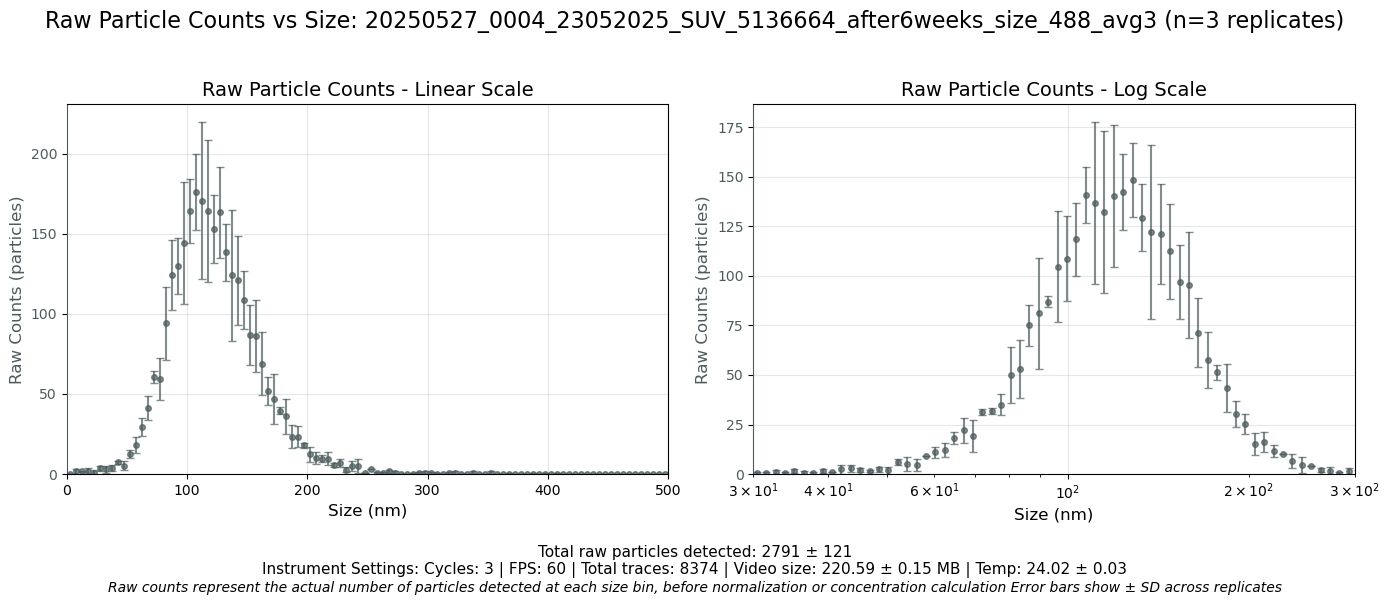


✓ Successfully created raw count visualization!


In [12]:
"""
NTA Data Analysis - Raw Particle Count Visualization with Instrument Settings (Cell 10d)

This cell creates plots showing the actual raw particle counts vs. size for averaged data,
including critical instrument settings from metadata and error bars for replicate variability.
"""

import matplotlib.pyplot as plt
import numpy as np
import os


def plot_raw_counts_with_settings(distribution_df, uniqueID=None, metadata=None, config=None):
    """
    Create visualizations of raw particle counts vs. size for averaged data, with instrument settings.
    
    Parameters:
    distribution_df (DataFrame): Processed NTA data with averaged values
    uniqueID (str): Unique identifier for the dataset
    metadata (dict): Metadata dictionary
    config (dict): Configuration dictionary
    
    Returns:
    tuple: (success_flag, filepath)
    """
    # Validate input
    if distribution_df is None or distribution_df.empty:
        print("No data available for plotting")
        return False, "No data available for plotting"
    
    # Extract sample ID
    id_text = uniqueID or (distribution_df['uniqueID'].iloc[0] if 'uniqueID' in distribution_df.columns else 'Unknown')
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Define color scheme - same as other plots
    color = '#4C5B5C'  # Slate gray for raw counts
    
    # Determine which columns to use for raw counts (before dilution correction)
    raw_count_col = None
    raw_count_sd_col = None
    
    # Look for the averaged number data (before normalization)
    if 'number_avg' in distribution_df.columns:
        raw_count_col = 'number_avg'
        raw_count_sd_col = 'number_sd' if 'number_sd' in distribution_df.columns else None
    else:
        print("Raw count data column not found in the dataset")
        return False, "Raw count data column not found in the dataset"
    
    # Plot 1: Linear scale raw counts
    lin_df = distribution_df[distribution_df['scale'] == 'linear'].sort_values('size_nm')
    if not lin_df.empty:
        # Plot raw counts with error bars if available
        if raw_count_sd_col and raw_count_sd_col in lin_df.columns:
            ax1.errorbar(lin_df['size_nm'], lin_df[raw_count_col], 
                        yerr=lin_df[raw_count_sd_col],
                        fmt='o', color=color, ecolor=color, alpha=0.7,
                        capsize=3, capthick=1, markersize=4, linewidth=1.5)
        else:
            ax1.scatter(lin_df['size_nm'], lin_df[raw_count_col], color=color, s=30, alpha=0.8)
        
        ax1.set_title('Raw Particle Counts - Linear Scale', fontsize=14)
        ax1.set_xlabel('Size (nm)', fontsize=12)
        ax1.set_ylabel('Raw Counts (particles)', fontsize=12, color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.spines['left'].set_color(color)
        ax1.grid(True, alpha=0.3)
        
        # Set reasonable x-axis limits
        percentile_95 = np.percentile(lin_df['size_nm'], 95)
        max_size = min(percentile_95 * 1.2, 500)  # Cap at 500 nm or use 95th percentile + 20%
        ax1.set_xlim([0, max_size])
        
        # Set y-axis to start from 0
        y_min, y_max = ax1.get_ylim()
        ax1.set_ylim([0, y_max])
    
    # Plot 2: Log scale raw counts 
    log_df = distribution_df[distribution_df['scale'] == 'logarithmic'].sort_values('size_nm')
    if not log_df.empty:
        # Plot raw counts with error bars if available
        if raw_count_sd_col and raw_count_sd_col in log_df.columns:
            ax2.errorbar(log_df['size_nm'], log_df[raw_count_col], 
                        yerr=log_df[raw_count_sd_col],
                        fmt='o', color=color, ecolor=color, alpha=0.7,
                        capsize=3, capthick=1, markersize=4, linewidth=1.5)
        else:
            ax2.scatter(log_df['size_nm'], log_df[raw_count_col], color=color, s=30, alpha=0.8)
        
        ax2.set_title('Raw Particle Counts - Log Scale', fontsize=14)
        ax2.set_xlabel('Size (nm)', fontsize=12)
        ax2.set_ylabel('Raw Counts (particles)', fontsize=12, color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.spines['left'].set_color(color)
        ax2.set_xscale('log')
        ax2.grid(True, alpha=0.3)
        
        # Set reasonable x-axis limits for log scale
        min_size = max(30, log_df['size_nm'].min())  # Don't go below 30 nm
        percentile_90 = np.percentile(log_df['size_nm'], 90)
        max_size = min(percentile_90 * 1.3, 300)
        ax2.set_xlim([min_size, max_size])
        
        # Set y-axis to start from 0
        y_min, y_max = ax2.get_ylim()
        ax2.set_ylim([0, y_max])
    
    # Determine replicate info for title
    replicate_info = ""
    if metadata and 'num_replicates' in metadata:
        num_reps = metadata['num_replicates']
        if num_reps and str(num_reps) != '1':
            replicate_info = f" (n={num_reps} replicates)"
    
    # Add overall title
    fig.suptitle(f'Raw Particle Counts vs Size: {id_text}{replicate_info}', fontsize=16, y=0.98)
    
    # Calculate total raw count (use linear data preferentially)
    if not lin_df.empty:
        total_raw_count = lin_df[raw_count_col].sum()
        if raw_count_sd_col and raw_count_sd_col in lin_df.columns:
            # Error propagation for sum: sqrt(sum of variances)
            total_raw_count_sd = np.sqrt((lin_df[raw_count_sd_col] ** 2).sum())
        else:
            total_raw_count_sd = 0
    elif not log_df.empty:
        total_raw_count = log_df[raw_count_col].sum()
        if raw_count_sd_col and raw_count_sd_col in log_df.columns:
            total_raw_count_sd = np.sqrt((log_df[raw_count_sd_col] ** 2).sum())
        else:
            total_raw_count_sd = 0
    else:
        total_raw_count = 0
        total_raw_count_sd = 0
    
    # Extract and format instrument settings from metadata
    instrument_settings = []
    if metadata:
        # Extract key NTA parameters
        cycles = metadata.get('nta_cycles', metadata.get('cycles', 'Unknown'))
        if cycles != 'Unknown':
            instrument_settings.append(f"Cycles: {cycles}")
        
        fps = metadata.get('nta_fps', metadata.get('fps', 'Unknown'))
        if fps != 'Unknown':
            instrument_settings.append(f"FPS: {fps}")
        
        # Extract total number of traces (summed across replicates)
        traces = metadata.get('nta_number_of_traces_sum', metadata.get('nta_number_of_traces', 'Unknown'))
        if traces != 'Unknown':
            instrument_settings.append(f"Total traces: {traces}")
        
        # Extract video file info
        avi_size = metadata.get('nta_avi_filesize', 'Unknown')
        if avi_size != 'Unknown':
            instrument_settings.append(f"Video size: {avi_size}")
        
        # Extract temperature
        temp = metadata.get('nta_temperature', metadata.get('temperature', 'Unknown'))
        if temp != 'Unknown':
            instrument_settings.append(f"Temp: {temp}")
    
    # Add explanation text about what raw counts represent
    explanation_parts = [
        "Raw counts represent the actual number of particles detected at each size bin,",
        "before normalization or concentration calculation"
    ]
    
    if replicate_info:
        explanation_parts.append("Error bars show ± SD across replicates")
    
    explanation = " ".join(explanation_parts)
    fig.text(0.5, 0.01, explanation, ha='center', fontsize=10, style='italic')
    
    # Add data statistics and instrument settings
    if total_raw_count_sd > 0:
        stats_text = f"Total raw particles detected: {total_raw_count:.0f} ± {total_raw_count_sd:.0f}"
    else:
        stats_text = f"Total raw particles detected: {total_raw_count:.0f}"
    
    # Create text block for statistics and settings
    text_block = [stats_text]
    if instrument_settings:
        text_block.append("Instrument Settings: " + " | ".join(instrument_settings))
    
    # Add the text block to the figure
    fig.text(0.5, 0.04, "\n".join(text_block), ha='center', fontsize=11)
    
    # Adjust layout to make room for the text
    bottom_margin = 0.06 + 0.02 * len(text_block)
    plt.tight_layout(rect=[0, bottom_margin, 1, 0.95])
    
    # Save figure
    filepath = None
    
    # Determine the output directory
    if config is not None and "directory" in config:
        output_dir = os.path.join(config["directory"], "processed")
    else:
        output_dir = os.path.join(os.getcwd(), "processed")
    
    # Ensure the output directory exists
    try:
        os.makedirs(output_dir, exist_ok=True)
        
        # Create descriptive filename
        base_path = os.path.join(output_dir, f"Plot_{id_text}_raw_counts")
        
        # Save in both PDF and PNG formats
        pdf_path = f"{base_path}.pdf"
        plt.savefig(pdf_path, bbox_inches='tight', dpi=300)
        
        png_path = f"{base_path}.png"
        plt.savefig(png_path, bbox_inches='tight', dpi=300)
        
        print(f"✓ Saved raw count plots: {os.path.basename(pdf_path)}/.png")
        filepath = pdf_path
    except Exception as e:
        print(f"⚠ Failed to save plot: {str(e)}")
        return False, str(e)
    
    # Update metadata with total raw particle count
    if metadata and total_raw_count > 0:
        try:
            # Get output directory for metadata
            if config is not None and "directory" in config:
                metadata_dir = os.path.join(config["directory"], "metadata")
            else:
                metadata_dir = os.path.join(os.getcwd(), "metadata")
            
            # Ensure metadata directory exists
            os.makedirs(metadata_dir, exist_ok=True)
            
            # Construct metadata filepath
            unique_id = metadata.get('persistentID', id_text)
            metadata_path = os.path.join(metadata_dir, f"Data_{unique_id}_metadata.txt")
            
            # Read existing metadata to preserve all fields
            existing_data = {}
            if os.path.exists(metadata_path):
                with open(metadata_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split('\t')
                        if len(parts) >= 2:
                            existing_data[parts[0]] = parts[1]
            
            # Add total raw particle count with uncertainty
            if total_raw_count_sd > 0:
                existing_data['nta_total_raw_particles'] = f"{total_raw_count:.0f} ± {total_raw_count_sd:.0f}"
            else:
                existing_data['nta_total_raw_particles'] = f"{total_raw_count:.0f}"
            
            # Write updated metadata
            with open(metadata_path, 'w') as f:
                for key, value in existing_data.items():
                    f.write(f"{key}\t{value}\t\n")
            
            print(f"✓ Updated metadata with total raw particle count")
            
            # Update global metadata variable if it exists
            if 'current_metadata' in globals():
                if total_raw_count_sd > 0:
                    globals()['current_metadata']['nta_total_raw_particles'] = f"{total_raw_count:.0f} ± {total_raw_count_sd:.0f}"
                else:
                    globals()['current_metadata']['nta_total_raw_particles'] = f"{total_raw_count:.0f}"
                
        except Exception as e:
            print(f"⚠ Could not update metadata: {str(e)}")
    
    plt.show()
    return True, filepath


# Execute if we have the required data
if 'current_distribution_df' in globals() and current_distribution_df is not None:
    print("=" * 80)
    print("GENERATING RAW PARTICLE COUNT VISUALIZATION")
    print("=" * 80)
    
    uniqueID = current_metadata.get('persistentID', 'unknown') if 'current_metadata' in globals() else 'unknown'
    metadata = current_metadata if 'current_metadata' in globals() else None
    config = CONFIG if 'CONFIG' in globals() else None
    
    print(f"Creating raw particle count plots for: {uniqueID}")
    
    success, filepath = plot_raw_counts_with_settings(
        current_distribution_df, 
        uniqueID, 
        metadata,
        config
    )
    
    if success:
        current_raw_count_plot = filepath
        print(f"\n✓ Successfully created raw count visualization!")
    else:
        print(f"ERROR: {filepath}")

else:
    print("No data found. Run the complete workflow first.")

In [13]:
"""
NTA Data Analysis - Raw Particle Counts vs Theoretical Surface Area Plots (Cell 10e)

This module creates two-subplot plots for raw particle counts vs theoretical surface area:
- Linear scale with theoretical surface area bins (displayed in linear space)
- Logarithmic scale with theoretical surface area bins (displayed in log space)

Layout: 60% main distribution (top) + 40% cumulative (bottom)
Visual style: Based on cell_10c surface area plots
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from scipy import stats as scipy_stats
from scipy.optimize import curve_fit


def lognormal_pdf(x, mu, sigma, amplitude):
    """Calculate lognormal probability density function with numerical stability."""
    # Add small epsilon to avoid log(0)
    x_safe = np.maximum(x, 1e-10)
    
    # Calculate the lognormal PDF
    log_x = np.log(x_safe)
    exponent = -((log_x - mu) ** 2) / (2 * sigma ** 2)
    
    # Avoid numerical overflow/underflow
    exponent = np.clip(exponent, -50, 50)
    
    pdf = amplitude * np.exp(exponent) / (x_safe * sigma * np.sqrt(2 * np.pi))
    
    # Ensure no NaN or inf values
    pdf = np.nan_to_num(pdf, nan=0.0, posinf=0.0, neginf=0.0)
    
    return pdf


def fit_lognormal_distribution(surface_areas, counts):
    """Fit a lognormal distribution to count vs surface area data."""
    try:
        # Check if we have enough data points
        if len(surface_areas) < 5:
            return False, "Insufficient data points for fitting"
        
        # Initial parameter estimates using more robust method
        # Convert to log space for initial estimates
        log_sa = np.log(surface_areas)
        
        # Weighted statistics for initial parameter estimates
        weights = counts / np.sum(counts)  # Normalize weights
        initial_mu = np.average(log_sa, weights=weights)
        initial_sigma = np.sqrt(np.average((log_sa - initial_mu)**2, weights=weights))
        
        # Ensure sigma is reasonable
        initial_sigma = max(0.1, min(initial_sigma, 3.0))
        
        # Scale amplitude based on data
        max_count = np.max(counts)
        initial_amplitude = max_count * 0.5  # Start with conservative amplitude
        
        initial_params = [initial_mu, initial_sigma, initial_amplitude]
        
        print(f"      Initial parameters: mu={initial_mu:.3f}, sigma={initial_sigma:.3f}, amp={initial_amplitude:.1f}")
        
        # More reasonable bounds
        lower_bounds = [
            np.log(surface_areas.min() * 0.1),  # mu lower bound
            0.05,                               # sigma lower bound  
            max_count * 0.01                    # amplitude lower bound
        ]
        upper_bounds = [
            np.log(surface_areas.max() * 10),   # mu upper bound
            5.0,                                # sigma upper bound
            max_count * 5.0                     # amplitude upper bound
        ]
        
        print(f"      Bounds: mu=[{lower_bounds[0]:.3f}, {upper_bounds[0]:.3f}], sigma=[{lower_bounds[1]:.3f}, {upper_bounds[1]:.3f}]")
        
        # Check if initial parameters are within bounds
        for i, (param, lower, upper) in enumerate(zip(initial_params, lower_bounds, upper_bounds)):
            if param < lower or param > upper:
                print(f"      Adjusting parameter {i}: {param:.3f} -> bounds [{lower:.3f}, {upper:.3f}]")
                initial_params[i] = max(lower, min(param, upper))
        
        # Perform curve fitting with adjusted parameters
        params, covariance = curve_fit(
            lognormal_pdf, surface_areas, counts, 
            p0=initial_params,
            bounds=(lower_bounds, upper_bounds), 
            maxfev=5000,
            method='trf'  # Trust Region Reflective algorithm, more robust
        )
        
        # Generate fitted curve with more points and proper range
        sa_min = surface_areas.min() * 0.8  # Extend slightly beyond data
        sa_max = surface_areas.max() * 1.2
        sa_range = np.linspace(sa_min, sa_max, 500)  # More points for smoother curve
        fitted_curve = lognormal_pdf(sa_range, *params)
        
        # Ensure the curve is smooth and reasonable
        if np.any(np.isnan(fitted_curve)) or np.any(np.isinf(fitted_curve)):
            return False, "Fit produced invalid values (NaN or inf)"
        
        # Check if fit is reasonable
        if np.max(fitted_curve) > max_count * 10 or np.max(fitted_curve) < max_count * 0.01:
            return False, "Fit amplitude is unreasonable"
        
        print(f"      Final parameters: mu={params[0]:.3f}, sigma={params[1]:.3f}, amp={params[2]:.1f}")
        print(f"      Curve range: {sa_min:.4f} - {sa_max:.4f} µm², max value: {np.max(fitted_curve):.1f}")
        
        return True, (sa_range, fitted_curve, params)
        
    except Exception as e:
        return False, f"Lognormal fit failed: {str(e)}"


def add_d_value_lines_and_bands_surface_area(ax, stats):
    """Add D-value lines and uncertainty bands to a subplot, converted to surface area in µm²."""
    legend_elements = []
    
    if not stats or 'D10_avg' not in stats:
        return legend_elements
    
    # Convert diameter D-values to surface area D-values using A = π × d² and convert to µm²
    d10_avg_size = stats['D10_avg']
    d10_lower_size = stats.get('D10_lower', d10_avg_size)
    d10_upper_size = stats.get('D10_upper', d10_avg_size)
    
    d50_avg_size = stats['D50_avg'] 
    d50_lower_size = stats.get('D50_lower', d50_avg_size)
    d50_upper_size = stats.get('D50_upper', d50_avg_size)
    
    d90_avg_size = stats['D90_avg']
    d90_lower_size = stats.get('D90_lower', d90_avg_size)
    d90_upper_size = stats.get('D90_upper', d90_avg_size)
    
    # Convert to surface areas in µm² (divide by 1e6 to convert from nm² to µm²)
    d10_avg_sa = (np.pi * (d10_avg_size ** 2)) / 1e6
    d10_lower_sa = (np.pi * (d10_lower_size ** 2)) / 1e6
    d10_upper_sa = (np.pi * (d10_upper_size ** 2)) / 1e6
    
    d50_avg_sa = (np.pi * (d50_avg_size ** 2)) / 1e6
    d50_lower_sa = (np.pi * (d50_lower_size ** 2)) / 1e6
    d50_upper_sa = (np.pi * (d50_upper_size ** 2)) / 1e6
    
    d90_avg_sa = (np.pi * (d90_avg_size ** 2)) / 1e6
    d90_lower_sa = (np.pi * (d90_lower_size ** 2)) / 1e6
    d90_upper_sa = (np.pi * (d90_upper_size ** 2)) / 1e6
    
    span = stats.get('span_avg', (d90_avg_size-d10_avg_size)/d50_avg_size if d50_avg_size > 0 else 0)
    
    # Add D-value lines and bands using surface area values in µm²
    for d_val_sa, d_lower_sa, d_upper_sa, style, width, alpha_band in [
        (d10_avg_sa, d10_lower_sa, d10_upper_sa, '--', 1.5, 0.15),
        (d50_avg_sa, d50_lower_sa, d50_upper_sa, '-', 2.5, 0.25), 
        (d90_avg_sa, d90_lower_sa, d90_upper_sa, '--', 1.5, 0.15)
    ]:
        if not np.isnan(d_val_sa):
            ax.axvline(x=d_val_sa, color='gray', linestyle=style, alpha=0.8, linewidth=width, zorder=5)
            if not np.isnan(d_lower_sa) and not np.isnan(d_upper_sa) and (d_lower_sa != d_val_sa or d_upper_sa != d_val_sa):
                ax.axvspan(d_lower_sa, d_upper_sa, alpha=alpha_band, color='gray', zorder=1)
    
    # Create legend elements showing diameter in nm and surface area in µm²
    legend_elements.extend([
        Line2D([0], [0], color='gray', linestyle='--', linewidth=1.5, 
              label=f'D10: {d10_avg_size:.1f} nm → {d10_avg_sa:.3f} µm² ({d10_lower_size:.1f}-{d10_upper_size:.1f} nm)'),
        Line2D([0], [0], color='gray', linestyle='-', linewidth=2.5, 
              label=f'D50: {d50_avg_size:.1f} nm → {d50_avg_sa:.3f} µm² ({d50_lower_size:.1f}-{d50_upper_size:.1f} nm)'),
        Line2D([0], [0], color='gray', linestyle='--', linewidth=1.5, 
              label=f'D90: {d90_avg_size:.1f} nm → {d90_avg_sa:.3f} µm² ({d90_lower_size:.1f}-{d90_upper_size:.1f} nm)'),
        Line2D([0], [0], color='white', linestyle='', 
              label=f'Span: {span:.3f}')
    ])
    
    return legend_elements


def add_count_fit_curve(ax, plot_df, is_log_scale, fit_color='#F25C54'):
    """Add lognormal fits for count vs surface area distributions in µm²."""
    fit_legend_elements = []
    
    surface_areas = plot_df['surface_area_um2'].values
    counts = plot_df['number_avg'].values
    
    # Remove any zero or negative values
    valid_mask = (counts > 0) & (surface_areas > 0) & np.isfinite(counts) & np.isfinite(surface_areas)
    if not np.any(valid_mask):
        print(f"      No valid data points for fitting")
        return fit_legend_elements, None
    
    surface_areas_clean = surface_areas[valid_mask]
    counts_clean = counts[valid_mask]
    
    print(f"      Fitting with {len(surface_areas_clean)} valid data points")
    print(f"      Surface area range: {surface_areas_clean.min():.4f} - {surface_areas_clean.max():.4f} µm²")
    print(f"      Count range: {counts_clean.min():.1f} - {counts_clean.max():.1f}")
    
    # Use lognormal fit for both linear and log scales
    success, result = fit_lognormal_distribution(surface_areas_clean, counts_clean)
    if success:
        sa_range, fitted_curve, params = result
        ax.plot(sa_range, fitted_curve, '-', color=fit_color, linewidth=2.5, 
               alpha=0.9, label='Lognormal Fit', zorder=4)
        
        geometric_mean_sa = np.exp(params[0])
        geometric_std = np.exp(params[1])
        
        print(f"      Fit parameters: geo_mean={geometric_mean_sa:.4f} µm², geo_std={geometric_std:.3f}")
        
        # Add fit info to legend with µm² units
        fit_legend_elements.append(
            Line2D([0], [0], color=fit_color, linestyle='-', linewidth=2.5,
                  label=f'Lognormal: geo_mean={geometric_mean_sa:.3f} µm², geo_std={geometric_std:.2f}')
        )
        
        return fit_legend_elements, ('lognormal', {'mu': params[0], 'sigma': params[1], 'amplitude': params[2]})
    else:
        print(f"      Lognormal fit failed: {result}")
        return fit_legend_elements, None


def create_count_vs_surface_area_plot(plot_df, is_log_scale, stats=None, uniqueID=None, metadata=None):
    """Create a two-subplot plot for raw counts vs theoretical surface area."""
    
    scale_name = "Logarithmic" if is_log_scale else "Linear"
    xscale = 'log' if is_log_scale else 'linear'
    color = '#4059AD'  # Indigo blue (same as cell_10c surface area plots)
    
    # Calculate theoretical surface area for spherical particles: A = π * d² and convert to µm²
    plot_df = plot_df.copy()
    plot_df['surface_area_um2'] = (np.pi * (plot_df['size_nm'] ** 2)) / 1e6  # Convert nm² to µm²
    
    # Sort by surface area
    plot_df = plot_df.sort_values('surface_area_um2')
    
    # Create figure
    fig = plt.figure(figsize=(7, 9))
    gs = gridspec.GridSpec(2, 1, height_ratios=[0.6, 0.4], hspace=0.3, 
                          top=0.82, bottom=0.08)
    
    # =================================================================
    # TOP SUBPLOT: MAIN DISTRIBUTION WITH ERROR BARS AND FITS
    # =================================================================
    ax1 = fig.add_subplot(gs[0])
    
    # Plot main distribution with error bars
    if 'number_sd' in plot_df.columns:
        ax1.errorbar(plot_df['surface_area_um2'], plot_df['number_avg'], 
                    yerr=plot_df['number_sd'],
                    fmt='o', color=color, ecolor=color, alpha=0.7,
                    capsize=3, capthick=1, markersize=6, linewidth=1.5,
                    label='Raw Counts')
    else:
        ax1.scatter(plot_df['surface_area_um2'], plot_df['number_avg'], 
                   color=color, s=60, alpha=0.8, label='Raw Counts')
    
    # Add lognormal fit curve
    fit_result = add_count_fit_curve(ax1, plot_df, is_log_scale)
    if isinstance(fit_result, tuple):
        fit_legend_elements, fit_results = fit_result
    else:
        fit_legend_elements = fit_result
        fit_results = None
    
    # Debug: Print fit status
    if fit_results:
        print(f"    ✓ Lognormal fit successful for {scale_name} scale")
    else:
        print(f"    ⚠ Lognormal fit failed for {scale_name} scale")
    
    # Format top subplot
    ax1.set_ylabel('Raw Particle Counts', color=color, fontsize=14, labelpad=10)
    ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.spines['left'].set_color(color)
    
    # Set x-axis scale and add better tick labels for log scale
    ax1.set_xscale(xscale)
    if is_log_scale:
        from matplotlib.ticker import LogLocator, LogFormatter
        ax1.xaxis.set_major_locator(LogLocator(base=10, numticks=12))
        ax1.xaxis.set_minor_locator(LogLocator(base=10, subs=(0.2, 0.4, 0.6, 0.8), numticks=12))
        ax1.xaxis.set_major_formatter(LogFormatter(base=10, labelOnlyBase=False))
    
    # Smart range calculation based on where the count signal is
    weights_for_range = plot_df['number_avg'].values
    sa_for_range = plot_df['surface_area_um2'].values
    
    # Find where 99% of the count signal is contained
    cumsum_weights = np.cumsum(weights_for_range)
    total_weight = cumsum_weights[-1]
    
    if total_weight > 0:
        # Find 1st and 99th percentiles of the count-weighted distribution
        p1_idx = np.searchsorted(cumsum_weights, 0.01 * total_weight)
        p99_idx = np.searchsorted(cumsum_weights, 0.99 * total_weight)
        
        signal_min_sa = sa_for_range[max(0, p1_idx)]
        signal_max_sa = sa_for_range[min(len(sa_for_range)-1, p99_idx)]
        data_max_sa = plot_df['surface_area_um2'].max()
        
        if is_log_scale:
            # Log scale: focus on the count signal range with some padding
            min_sa = max(signal_min_sa * 0.7, (np.pi * (20**2)) / 1e6)  # Don't go below 20nm diameter equivalent
            max_sa = min(signal_max_sa * 1.8, data_max_sa * 1.2)
            ax1.set_xlim([min_sa, max_sa])
        else:
            # Linear scale: tighten the range, focus on main signal
            min_sa = 0
            max_sa = min(signal_max_sa * 1.15, (np.pi * (350**2)) / 1e6)  # Cap at ~350nm diameter equivalent
            ax1.set_xlim([min_sa, max_sa])
    else:
        # Fallback if no signal
        if is_log_scale:
            ax1.set_xlim([(np.pi * (30**2)) / 1e6, (np.pi * (300**2)) / 1e6])
        else:
            ax1.set_xlim([0, (np.pi * (250**2)) / 1e6])
    
    # Set y-axis to start from 0
    y_min, y_max = ax1.get_ylim()
    ax1.set_ylim([0, y_max])
    
    # Add D-value lines and bands (converted to surface area)
    d_legend_elements = add_d_value_lines_and_bands_surface_area(ax1, stats)
    
    # Create comprehensive legend for top plot - PLACE OUTSIDE
    main_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                          markersize=8, label='Raw Counts')]
    
    all_legend_elements = main_legend + fit_legend_elements + d_legend_elements
    leg1 = ax1.legend(handles=all_legend_elements, fontsize=9, frameon=True, 
                     bbox_to_anchor=(1.05, 1), loc='upper left')
    leg1.get_frame().set_alpha(0.95)
    leg1.get_frame().set_edgecolor('lightgray')
    
    ax1.grid(True, linestyle='--', alpha=0.4)
    ax1.set_xlabel('')  # No x-label on top plot
    
    # =================================================================
    # BOTTOM SUBPLOT: CUMULATIVE DISTRIBUTION WITH UNCERTAINTY BANDS
    # =================================================================
    ax2 = fig.add_subplot(gs[1])
    
    # Calculate cumulative counts as percentage
    cumsum_counts = np.cumsum(plot_df['number_avg'])
    max_cumsum = cumsum_counts.iloc[-1] if len(cumsum_counts) > 0 else 1
    
    if max_cumsum > 0:
        cumsum_percentage = (cumsum_counts / max_cumsum) * 100
        ax2.plot(plot_df['surface_area_um2'], cumsum_percentage, '-', 
                color=color, linewidth=3, alpha=0.9, label='Cumulative %')
        
        # Add uncertainty bands if available
        if 'number_sd' in plot_df.columns:
            # Calculate cumulative uncertainty
            cumsum_sd = np.sqrt(np.cumsum(plot_df['number_sd'] ** 2))
            cumsum_sd_percentage = (cumsum_sd / max_cumsum) * 100
            ax2.fill_between(plot_df['surface_area_um2'], 
                           cumsum_percentage - cumsum_sd_percentage,
                           cumsum_percentage + cumsum_sd_percentage,
                           color=color, alpha=0.25, zorder=1, label='± SD')
    
    ax2.set_ylim([0, 110])
    ax2.set_ylabel('Cumulative Percentage (%)', color=color, fontsize=14, labelpad=10)
    ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
    ax2.spines['left'].set_color(color)
    
    # Format bottom subplot
    ax2.set_xlabel('Theoretical Surface Area (µm²)', fontsize=14, labelpad=10)
    ax2.tick_params(axis='x', labelsize=12)
    ax2.set_xscale(xscale)
    ax2.set_xlim(ax1.get_xlim())  # Match top plot limits
    
    if is_log_scale:
        # Add same detailed log scale ticks to bottom plot
        from matplotlib.ticker import LogLocator, LogFormatter
        ax2.xaxis.set_major_locator(LogLocator(base=10, numticks=12))
        ax2.xaxis.set_minor_locator(LogLocator(base=10, subs=(0.2, 0.4, 0.6, 0.8), numticks=12))
        ax2.xaxis.set_major_formatter(LogFormatter(base=10, labelOnlyBase=False))
    
    # Add D-value lines to bottom plot (converted to surface area)
    add_d_value_lines_and_bands_surface_area(ax2, stats)
    
    # Legend for bottom plot - PLACE OUTSIDE
    cumulative_legend = [
        Line2D([0], [0], color=color, linewidth=3, label='Cumulative %'),
        Line2D([0], [0], color=color, alpha=0.25, linewidth=8, label='± SD')
    ]
    
    leg2 = ax2.legend(handles=cumulative_legend, fontsize=10, frameon=True, 
                     bbox_to_anchor=(1.05, 1), loc='upper left')
    leg2.get_frame().set_alpha(0.95)
    leg2.get_frame().set_edgecolor('lightgray')
    
    ax2.grid(True, linestyle='--', alpha=0.4)
    
    # =================================================================
    # TITLE AND METADATA
    # =================================================================
    
    # Extract replicate info
    replicate_info = ""
    if metadata and 'num_replicates' in metadata:
        num_reps = metadata['num_replicates']
        if num_reps and str(num_reps) != '1':
            replicate_info = f" (n={num_reps})"
    
    # Set main title
    main_title = f'{scale_name} Raw Counts vs\nTheoretical Surface Area: {uniqueID}{replicate_info}'
    fig.suptitle(main_title, fontsize=14, fontweight='bold', y=0.94)
    
    # Add subtitle
    subtitle = f"Error bars/bands: ± SD | Surface Area = π × diameter² | Fits: Lognormal"
    fig.text(0.5, 0.87, subtitle, ha='center', fontsize=11, style='italic')
    
    return fig, fit_results


def generate_count_vs_surface_area_plots(distribution_df, stats_dict=None, uniqueID=None, 
                                        metadata=None, output_dir=None, config=None):
    """Generate raw count vs surface area plots for both linear and log scales."""
    
    if distribution_df is None or distribution_df.empty:
        return False, "No data available for plotting"
    
    # Check if we have the required columns
    if 'number_avg' not in distribution_df.columns:
        return False, "Raw count data (number_avg) not found in dataset"
    
    plt.style.use('default')
    
    # Determine output directory
    if output_dir is None:
        if config is not None and "directory" in config:
            base_dir = config["directory"]
            output_dir = os.path.join(base_dir, "processed")
        else:
            output_dir = os.path.join(os.getcwd(), "processed")
    
    try:
        os.makedirs(output_dir, exist_ok=True)
    except Exception as e:
        return False, f"Failed to create output directory: {str(e)}"
    
    created_files = []
    
    # Generate linear and logarithmic plots
    for is_log_scale in [False, True]:
        scale_type = 'logarithmic' if is_log_scale else 'linear'
        scale_name = 'log' if is_log_scale else 'linear'
        
        print(f"Creating {scale_name} count vs surface area plot...")
        
        # Filter data for this scale
        plot_df = distribution_df[distribution_df['scale'] == scale_type].copy()
        
        if plot_df.empty:
            print(f"  Warning: No {scale_type} scale data available")
            continue
        
        # Get statistics (use number-weighted stats from the appropriate scale)
        stats = None
        if stats_dict and scale_type in stats_dict and 'number' in stats_dict[scale_type]:
            stats = stats_dict[scale_type]['number']
        
        # Create the plot (matching function signature)
        fig, fit_results = create_count_vs_surface_area_plot(plot_df, is_log_scale, stats, uniqueID, metadata)
        
        if fig is None:
            print(f"  Failed to create plot")
            continue
        
        # Save fit results to comprehensive fits file
        if fit_results:
            fit_type, fit_data = fit_results
            try:
                import json
                
                # Load existing fits file or create new one
                fits_filename = f"Fits_{uniqueID}_all.json"
                fits_path = os.path.join(output_dir, fits_filename)
                
                if os.path.exists(fits_path):
                    with open(fits_path, 'r') as f:
                        all_fits = json.load(f)
                else:
                    all_fits = {'dataset': uniqueID, 'fits': {}}
                
                # Add this fit to the collection
                fit_key = f"count_vs_surface_area_{scale_name}"
                all_fits['fits'][fit_key] = {
                    'distribution_type': 'count_vs_surface_area',
                    'scale': scale_name,
                    'fit_type': fit_type,
                    'parameters': fit_data
                }
                
                # Save updated fits file
                with open(fits_path, 'w') as f:
                    json.dump(all_fits, f, indent=2, default=str)
                
                print(f"  ✓ Saved fit to: {fits_filename}")
                
            except Exception as e:
                print(f"  ⚠ Failed to save fit: {str(e)}")
        
        # Save the plot
        try:
            base_filename = f"Plot_{uniqueID}_{scale_name}_count_vs_surface_area"
            
            pdf_path = os.path.join(output_dir, f"{base_filename}.pdf")
            fig.savefig(pdf_path, bbox_inches='tight', dpi=300)
            
            png_path = os.path.join(output_dir, f"{base_filename}.png")
            fig.savefig(png_path, bbox_inches='tight', dpi=300)
            
            created_files.append(pdf_path)
            print(f"  ✓ Saved: {base_filename}.pdf/.png")
            
            plt.close(fig)
            
        except Exception as e:
            print(f"  ✗ Failed to save plot: {str(e)}")
            plt.close(fig)
            continue
    
    return True, created_files


# Execute if we have the required data
if 'current_distribution_df' in globals() and current_distribution_df is not None:
    print("=" * 80)
    print("GENERATING RAW COUNT vs THEORETICAL SURFACE AREA PLOTS WITH D-VALUES")
    print("=" * 80)
    
    uniqueID = current_metadata.get('persistentID', 'unknown') if 'current_metadata' in globals() else 'unknown'
    stats = current_stats if 'current_stats' in globals() else None
    metadata = current_metadata if 'current_metadata' in globals() else None
    config = CONFIG if 'CONFIG' in globals() else None
    
    print(f"Creating count vs surface area plots for: {uniqueID}")
    print("Surface Area = π × diameter² (spherical particles) in µm²")
    print("Includes: Linear + Logarithmic (Lognormal fits + D-values for both)")
    
    success, plot_files = generate_count_vs_surface_area_plots(
        current_distribution_df,
        stats_dict=stats,
        uniqueID=uniqueID,
        metadata=metadata,
        config=config
    )
    
    if not success:
        print(f"ERROR: {plot_files}")
    else:
        print(f"\n✓ Successfully created {len(plot_files)} count vs surface area plots!")
        for filepath in plot_files:
            print(f"  - {os.path.basename(filepath)}")
        
        current_count_vs_surface_area_plots = plot_files

else:
    print("No data found. Run the complete workflow first.")

GENERATING RAW COUNT vs THEORETICAL SURFACE AREA PLOTS WITH D-VALUES
Creating count vs surface area plots for: 20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3
Surface Area = π × diameter² (spherical particles) in µm²
Includes: Linear + Logarithmic (Lognormal fits + D-values for both)
Creating linear count vs surface area plot...
      Fitting with 70 valid data points
      Surface area range: 0.0002 - 2.1253 µm²
      Count range: 0.3 - 176.0
      Initial parameters: mu=-3.138, sigma=0.643, amp=88.0
      Bounds: mu=[-10.944, 3.057], sigma=[0.050, 5.000]
      Final parameters: mu=-2.935, sigma=0.558, amp=10.8
      Curve range: 0.0001 - 2.5504 µm², max value: 169.5
      Fit parameters: geo_mean=0.0531 µm², geo_std=1.748
    ✓ Lognormal fit successful for Linear scale
  ✓ Saved fit to: Fits_20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3_all.json
  ✓ Saved: Plot_20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3_linear_count_vs_surface_area.pdf/.p

In [14]:
"""
NTA Data Analysis - Raw Particle Counts vs Theoretical Volume Plots (Cell 10f)

This module creates two-subplot plots for raw particle counts vs theoretical volume:
- Linear scale with theoretical volume bins (displayed in linear space)
- Logarithmic scale with theoretical volume bins (displayed in log space)

Layout: 60% main distribution (top) + 40% cumulative (bottom)
Visual style: Based on cell_10c surface area plots
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from scipy import stats as scipy_stats
from scipy.optimize import curve_fit


def lognormal_pdf(x, mu, sigma, amplitude):
    """Calculate lognormal probability density function with numerical stability."""
    # Add small epsilon to avoid log(0)
    x_safe = np.maximum(x, 1e-10)
    
    # Calculate the lognormal PDF
    log_x = np.log(x_safe)
    exponent = -((log_x - mu) ** 2) / (2 * sigma ** 2)
    
    # Avoid numerical overflow/underflow
    exponent = np.clip(exponent, -50, 50)
    
    pdf = amplitude * np.exp(exponent) / (x_safe * sigma * np.sqrt(2 * np.pi))
    
    # Ensure no NaN or inf values
    pdf = np.nan_to_num(pdf, nan=0.0, posinf=0.0, neginf=0.0)
    
    return pdf


def fit_lognormal_distribution(volumes, counts):
    """Fit a lognormal distribution to count vs volume data with better handling of extreme skewness."""
    try:
        # Check if we have enough data points
        if len(volumes) < 5:
            return False, "Insufficient data points for fitting"
        
        # For volume data, we need to be much more careful due to extreme skewness
        # Find the peak location first
        peak_idx = np.argmax(counts)
        peak_volume = volumes[peak_idx]
        peak_count = counts[peak_idx]
        
        print(f"      Peak at volume: {peak_volume:.6f} µm³, count: {peak_count:.1f}")
        
        # Use a more robust approach - focus on the main distribution
        # Only use data points that are within reasonable range of the peak
        volume_range = volumes.max() - volumes.min()
        focus_mask = (volumes >= volumes.min()) & (volumes <= peak_volume + volume_range * 0.3)
        
        if np.sum(focus_mask) < 5:
            focus_mask = np.ones_like(volumes, dtype=bool)  # Use all data if focus range too small
        
        volumes_focus = volumes[focus_mask]
        counts_focus = counts[focus_mask]
        
        print(f"      Using {len(volumes_focus)} focused data points for fitting")
        
        # Initial parameter estimates using the focused data
        log_vol = np.log(volumes_focus)
        weights = counts_focus / np.sum(counts_focus)
        
        initial_mu = np.average(log_vol, weights=weights)
        initial_sigma = np.sqrt(np.average((log_vol - initial_mu)**2, weights=weights))
        
        # Constrain sigma much more tightly for volume data
        initial_sigma = max(0.2, min(initial_sigma, 2.0))  # Much tighter constraints
        
        # Better amplitude estimate based on peak
        initial_amplitude = peak_count * 0.8
        
        initial_params = [initial_mu, initial_sigma, initial_amplitude]
        
        print(f"      Initial parameters: mu={initial_mu:.3f}, sigma={initial_sigma:.3f}, amp={initial_amplitude:.1f}")
        
        # Much tighter bounds for volume fitting
        max_count = np.max(counts)
        lower_bounds = [
            np.log(volumes.min() * 0.5),        # mu lower bound
            0.1,                                # sigma lower bound (much tighter)
            max_count * 0.1                     # amplitude lower bound
        ]
        upper_bounds = [
            np.log(peak_volume * 3),            # mu upper bound (focused around peak)
            1.5,                                # sigma upper bound (much tighter)
            max_count * 2.0                     # amplitude upper bound
        ]
        
        print(f"      Bounds: mu=[{lower_bounds[0]:.3f}, {upper_bounds[0]:.3f}], sigma=[{lower_bounds[1]:.3f}, {upper_bounds[1]:.3f}]")
        
        # Check if initial parameters are within bounds
        for i, (param, lower, upper) in enumerate(zip(initial_params, lower_bounds, upper_bounds)):
            if param < lower or param > upper:
                print(f"      Adjusting parameter {i}: {param:.3f} -> bounds [{lower:.3f}, {upper:.3f}]")
                initial_params[i] = max(lower, min(param, upper))
        
        # Perform curve fitting with adjusted parameters - use all data but constrained parameters
        params, covariance = curve_fit(
            lognormal_pdf, volumes, counts, 
            p0=initial_params,
            bounds=(lower_bounds, upper_bounds), 
            maxfev=10000,
            method='trf'
        )
        
        # Generate fitted curve with more points and proper range
        vol_min = volumes.min() * 0.9
        vol_max = min(volumes.max() * 1.1, peak_volume * 5)  # Don't extend too far beyond peak
        vol_range = np.linspace(vol_min, vol_max, 500)
        fitted_curve = lognormal_pdf(vol_range, *params)
        
        # Check if fit is reasonable - much stricter criteria for volume
        if np.any(np.isnan(fitted_curve)) or np.any(np.isinf(fitted_curve)):
            return False, "Fit produced invalid values (NaN or inf)"
        
        # Check fit quality - the peak should be reasonably close
        fit_peak_idx = np.argmax(fitted_curve)
        fit_peak_volume = vol_range[fit_peak_idx]
        fit_peak_count = fitted_curve[fit_peak_idx]
        
        # Peak should be within reasonable range
        if abs(fit_peak_volume - peak_volume) > peak_volume * 0.5:
            return False, f"Fit peak too far from data peak: {fit_peak_volume:.6f} vs {peak_volume:.6f}"
        
        # Peak height should be reasonable
        if fit_peak_count > max_count * 3 or fit_peak_count < max_count * 0.1:
            return False, f"Fit peak height unreasonable: {fit_peak_count:.1f} vs {peak_count:.1f}"
        
        print(f"      Final parameters: mu={params[0]:.3f}, sigma={params[1]:.3f}, amp={params[2]:.1f}")
        print(f"      Curve range: {vol_min:.6f} - {vol_max:.6f} µm³, max value: {np.max(fitted_curve):.1f}")
        print(f"      Fit peak at: {fit_peak_volume:.6f} µm³ (data peak: {peak_volume:.6f} µm³)")
        
        return True, (vol_range, fitted_curve, params)
        
    except Exception as e:
        return False, f"Lognormal fit failed: {str(e)}"


def add_d_value_lines_and_bands_volume(ax, stats):
    """Add D-value lines and uncertainty bands to a subplot, converted to volume in µm³."""
    legend_elements = []
    
    if not stats or 'D10_avg' not in stats:
        return legend_elements
    
    # Convert diameter D-values to volume D-values using V = (π/6) × d³ and convert to µm³
    d10_avg_size = stats['D10_avg']
    d10_lower_size = stats.get('D10_lower', d10_avg_size)
    d10_upper_size = stats.get('D10_upper', d10_avg_size)
    
    d50_avg_size = stats['D50_avg'] 
    d50_lower_size = stats.get('D50_lower', d50_avg_size)
    d50_upper_size = stats.get('D50_upper', d50_avg_size)
    
    d90_avg_size = stats['D90_avg']
    d90_lower_size = stats.get('D90_lower', d90_avg_size)
    d90_upper_size = stats.get('D90_upper', d90_avg_size)
    
    # Convert to volumes in µm³ (divide by 1e9 to convert from nm³ to µm³)
    d10_avg_vol = (np.pi / 6) * (d10_avg_size ** 3) / 1e9
    d10_lower_vol = (np.pi / 6) * (d10_lower_size ** 3) / 1e9
    d10_upper_vol = (np.pi / 6) * (d10_upper_size ** 3) / 1e9
    
    d50_avg_vol = (np.pi / 6) * (d50_avg_size ** 3) / 1e9
    d50_lower_vol = (np.pi / 6) * (d50_lower_size ** 3) / 1e9
    d50_upper_vol = (np.pi / 6) * (d50_upper_size ** 3) / 1e9
    
    d90_avg_vol = (np.pi / 6) * (d90_avg_size ** 3) / 1e9
    d90_lower_vol = (np.pi / 6) * (d90_lower_size ** 3) / 1e9
    d90_upper_vol = (np.pi / 6) * (d90_upper_size ** 3) / 1e9
    
    span = stats.get('span_avg', (d90_avg_size-d10_avg_size)/d50_avg_size if d50_avg_size > 0 else 0)
    
    # Add D-value lines and bands using volume values in µm³
    for d_val_vol, d_lower_vol, d_upper_vol, style, width, alpha_band in [
        (d10_avg_vol, d10_lower_vol, d10_upper_vol, '--', 1.5, 0.15),
        (d50_avg_vol, d50_lower_vol, d50_upper_vol, '-', 2.5, 0.25), 
        (d90_avg_vol, d90_lower_vol, d90_upper_vol, '--', 1.5, 0.15)
    ]:
        if not np.isnan(d_val_vol):
            ax.axvline(x=d_val_vol, color='gray', linestyle=style, alpha=0.8, linewidth=width, zorder=5)
            if not np.isnan(d_lower_vol) and not np.isnan(d_upper_vol) and (d_lower_vol != d_val_vol or d_upper_vol != d_val_vol):
                ax.axvspan(d_lower_vol, d_upper_vol, alpha=alpha_band, color='gray', zorder=1)
    
    # Create legend elements showing diameter in nm and volume in µm³
    legend_elements.extend([
        Line2D([0], [0], color='gray', linestyle='--', linewidth=1.5, 
              label=f'D10: {d10_avg_size:.1f} nm → {d10_avg_vol:.4f} µm³ ({d10_lower_size:.1f}-{d10_upper_size:.1f} nm)'),
        Line2D([0], [0], color='gray', linestyle='-', linewidth=2.5, 
              label=f'D50: {d50_avg_size:.1f} nm → {d50_avg_vol:.4f} µm³ ({d50_lower_size:.1f}-{d50_upper_size:.1f} nm)'),
        Line2D([0], [0], color='gray', linestyle='--', linewidth=1.5, 
              label=f'D90: {d90_avg_size:.1f} nm → {d90_avg_vol:.4f} µm³ ({d90_lower_size:.1f}-{d90_upper_size:.1f} nm)'),
        Line2D([0], [0], color='white', linestyle='', 
              label=f'Span: {span:.3f}')
    ])
    
    return legend_elements


def add_count_fit_curve_volume(ax, plot_df, is_log_scale, fit_color='#F25C54'):
    """No fitting for volume distributions - they're too skewed for standard fits."""
    # Return empty fit elements - no fitting needed
    return [], None


def create_count_vs_volume_plot(plot_df, is_log_scale, stats=None, uniqueID=None, metadata=None):
    """Create a two-subplot plot for raw counts vs theoretical volume."""
    
    scale_name = "Logarithmic" if is_log_scale else "Linear"
    xscale = 'log' if is_log_scale else 'linear'
    color = '#2E7D32'  # Forest green (same as cell_10b volume plots)
    
    # Calculate theoretical volume for spherical particles: V = (π/6) * d³ and convert to µm³
    plot_df = plot_df.copy()
    plot_df['volume_um3'] = (np.pi / 6) * (plot_df['size_nm'] ** 3) / 1e9  # Convert nm³ to µm³
    
    # Sort by volume
    plot_df = plot_df.sort_values('volume_um3')
    
    # Create figure
    fig = plt.figure(figsize=(7, 9))
    gs = gridspec.GridSpec(2, 1, height_ratios=[0.6, 0.4], hspace=0.3, 
                          top=0.82, bottom=0.08)
    
    # =================================================================
    # TOP SUBPLOT: MAIN DISTRIBUTION WITH ERROR BARS AND FITS
    # =================================================================
    ax1 = fig.add_subplot(gs[0])
    
    # Plot main distribution with error bars
    if 'number_sd' in plot_df.columns:
        ax1.errorbar(plot_df['volume_um3'], plot_df['number_avg'], 
                    yerr=plot_df['number_sd'],
                    fmt='o', color=color, ecolor=color, alpha=0.7,
                    capsize=3, capthick=1, markersize=6, linewidth=1.5,
                    label='Raw Counts')
    else:
        ax1.scatter(plot_df['volume_um3'], plot_df['number_avg'], 
                   color=color, s=60, alpha=0.8, label='Raw Counts')
    
    # Add lognormal fit curve (disabled for volume - too skewed)
    fit_result = add_count_fit_curve_volume(ax1, plot_df, is_log_scale)
    if isinstance(fit_result, tuple):
        fit_legend_elements, fit_results = fit_result
    else:
        fit_legend_elements = fit_result
        fit_results = None
    
    # No fitting for volume distributions - they're inherently too skewed
    
    # Format top subplot
    ax1.set_ylabel('Raw Particle Counts', color=color, fontsize=14, labelpad=10)
    ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.spines['left'].set_color(color)
    
    # Set x-axis scale and add better tick labels for log scale
    ax1.set_xscale(xscale)
    if is_log_scale:
        from matplotlib.ticker import LogLocator, LogFormatter
        ax1.xaxis.set_major_locator(LogLocator(base=10, numticks=12))
        ax1.xaxis.set_minor_locator(LogLocator(base=10, subs=(0.2, 0.4, 0.6, 0.8), numticks=12))
        ax1.xaxis.set_major_formatter(LogFormatter(base=10, labelOnlyBase=False))
    
    # Smart range calculation based on where the count signal is
    weights_for_range = plot_df['number_avg'].values
    vol_for_range = plot_df['volume_um3'].values
    
    # Find where 99% of the count signal is contained
    cumsum_weights = np.cumsum(weights_for_range)
    total_weight = cumsum_weights[-1]
    
    if total_weight > 0:
        # Find 1st and 99th percentiles of the count-weighted distribution
        p1_idx = np.searchsorted(cumsum_weights, 0.01 * total_weight)
        p99_idx = np.searchsorted(cumsum_weights, 0.99 * total_weight)
        
        signal_min_vol = vol_for_range[max(0, p1_idx)]
        signal_max_vol = vol_for_range[min(len(vol_for_range)-1, p99_idx)]
        data_max_vol = plot_df['volume_um3'].max()
        
        if is_log_scale:
            # Log scale: focus on the count signal range with some padding
            min_vol = max(signal_min_vol * 0.7, (np.pi / 6) * (20**3) / 1e9)  # Don't go below 20nm diameter equivalent
            max_vol = min(signal_max_vol * 1.8, data_max_vol * 1.2)
            ax1.set_xlim([min_vol, max_vol])
        else:
            # Linear scale: tighten the range, focus on main signal
            min_vol = 0
            max_vol = min(signal_max_vol * 1.15, (np.pi / 6) * (350**3) / 1e9)  # Cap at ~350nm diameter equivalent
            ax1.set_xlim([min_vol, max_vol])
    else:
        # Fallback if no signal
        if is_log_scale:
            ax1.set_xlim([(np.pi / 6) * (30**3) / 1e9, (np.pi / 6) * (300**3) / 1e9])
        else:
            ax1.set_xlim([0, (np.pi / 6) * (250**3) / 1e9])
    
    # Set y-axis to start from 0
    y_min, y_max = ax1.get_ylim()
    ax1.set_ylim([0, y_max])
    
    # Add D-value lines and bands (converted to volume)
    d_legend_elements = add_d_value_lines_and_bands_volume(ax1, stats)
    
    # Create comprehensive legend for top plot - PLACE OUTSIDE
    main_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                          markersize=8, label='Raw Counts')]
    
    all_legend_elements = main_legend + fit_legend_elements + d_legend_elements
    leg1 = ax1.legend(handles=all_legend_elements, fontsize=9, frameon=True, 
                     bbox_to_anchor=(1.05, 1), loc='upper left')
    leg1.get_frame().set_alpha(0.95)
    leg1.get_frame().set_edgecolor('lightgray')
    
    ax1.grid(True, linestyle='--', alpha=0.4)
    ax1.set_xlabel('')  # No x-label on top plot
    
    # =================================================================
    # BOTTOM SUBPLOT: CUMULATIVE DISTRIBUTION WITH UNCERTAINTY BANDS
    # =================================================================
    ax2 = fig.add_subplot(gs[1])
    
    # Calculate cumulative counts as percentage
    cumsum_counts = np.cumsum(plot_df['number_avg'])
    max_cumsum = cumsum_counts.iloc[-1] if len(cumsum_counts) > 0 else 1
    
    if max_cumsum > 0:
        cumsum_percentage = (cumsum_counts / max_cumsum) * 100
        ax2.plot(plot_df['volume_um3'], cumsum_percentage, '-', 
                color=color, linewidth=3, alpha=0.9, label='Cumulative %')
        
        # Add uncertainty bands if available
        if 'number_sd' in plot_df.columns:
            # Calculate cumulative uncertainty
            cumsum_sd = np.sqrt(np.cumsum(plot_df['number_sd'] ** 2))
            cumsum_sd_percentage = (cumsum_sd / max_cumsum) * 100
            ax2.fill_between(plot_df['volume_um3'], 
                           cumsum_percentage - cumsum_sd_percentage,
                           cumsum_percentage + cumsum_sd_percentage,
                           color=color, alpha=0.25, zorder=1, label='± SD')
    
    ax2.set_ylim([0, 110])
    ax2.set_ylabel('Cumulative Percentage (%)', color=color, fontsize=14, labelpad=10)
    ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
    ax2.spines['left'].set_color(color)
    
    # Format bottom subplot
    ax2.set_xlabel('Theoretical Volume (µm³)', fontsize=14, labelpad=10)
    ax2.tick_params(axis='x', labelsize=12)
    ax2.set_xscale(xscale)
    ax2.set_xlim(ax1.get_xlim())  # Match top plot limits
    
    if is_log_scale:
        # Add same detailed log scale ticks to bottom plot
        from matplotlib.ticker import LogLocator, LogFormatter
        ax2.xaxis.set_major_locator(LogLocator(base=10, numticks=12))
        ax2.xaxis.set_minor_locator(LogLocator(base=10, subs=(0.2, 0.4, 0.6, 0.8), numticks=12))
        ax2.xaxis.set_major_formatter(LogFormatter(base=10, labelOnlyBase=False))
    
    # Add D-value lines to bottom plot (converted to volume)
    add_d_value_lines_and_bands_volume(ax2, stats)
    
    # Legend for bottom plot - PLACE OUTSIDE
    cumulative_legend = [
        Line2D([0], [0], color=color, linewidth=3, label='Cumulative %'),
        Line2D([0], [0], color=color, alpha=0.25, linewidth=8, label='± SD')
    ]
    
    leg2 = ax2.legend(handles=cumulative_legend, fontsize=10, frameon=True, 
                     bbox_to_anchor=(1.05, 1), loc='upper left')
    leg2.get_frame().set_alpha(0.95)
    leg2.get_frame().set_edgecolor('lightgray')
    
    ax2.grid(True, linestyle='--', alpha=0.4)
    
    # =================================================================
    # TITLE AND METADATA
    # =================================================================
    
    # Extract replicate info
    replicate_info = ""
    if metadata and 'num_replicates' in metadata:
        num_reps = metadata['num_replicates']
        if num_reps and str(num_reps) != '1':
            replicate_info = f" (n={num_reps})"
    
    # Set main title
    main_title = f'{scale_name} Raw Counts vs\nTheoretical Volume: {uniqueID}{replicate_info}'
    fig.suptitle(main_title, fontsize=14, fontweight='bold', y=0.94)
    
    # Add subtitle
    subtitle = f"Error bars/bands: ± SD | Volume = (π/6) × diameter³ | No fits (volume too skewed)"
    fig.text(0.5, 0.87, subtitle, ha='center', fontsize=11, style='italic')
    
    return fig, fit_results


def generate_count_vs_volume_plots(distribution_df, stats_dict=None, uniqueID=None, 
                                  metadata=None, output_dir=None, config=None):
    """Generate raw count vs volume plots for both linear and log scales."""
    
    if distribution_df is None or distribution_df.empty:
        return False, "No data available for plotting"
    
    # Check if we have the required columns
    if 'number_avg' not in distribution_df.columns:
        return False, "Raw count data (number_avg) not found in dataset"
    
    plt.style.use('default')
    
    # Determine output directory
    if output_dir is None:
        if config is not None and "directory" in config:
            base_dir = config["directory"]
            output_dir = os.path.join(base_dir, "processed")
        else:
            output_dir = os.path.join(os.getcwd(), "processed")
    
    try:
        os.makedirs(output_dir, exist_ok=True)
    except Exception as e:
        return False, f"Failed to create output directory: {str(e)}"
    
    created_files = []
    
    # Generate linear and logarithmic plots
    for is_log_scale in [False, True]:
        scale_type = 'logarithmic' if is_log_scale else 'linear'
        scale_name = 'log' if is_log_scale else 'linear'
        
        print(f"Creating {scale_name} count vs volume plot...")
        
        # Filter data for this scale
        plot_df = distribution_df[distribution_df['scale'] == scale_type].copy()
        
        if plot_df.empty:
            print(f"  Warning: No {scale_type} scale data available")
            continue
        
        # Get statistics (use number-weighted stats from the appropriate scale)
        stats = None
        if stats_dict and scale_type in stats_dict and 'number' in stats_dict[scale_type]:
            stats = stats_dict[scale_type]['number']
        
        # Create the plot (matching function signature)
        fig, fit_results = create_count_vs_volume_plot(plot_df, is_log_scale, stats, uniqueID, metadata)
        
        if fig is None:
            print(f"  Failed to create plot")
            continue
        
        # Save fit results to comprehensive fits file
        if fit_results:
            fit_type, fit_data = fit_results
            try:
                import json
                
                # Load existing fits file or create new one
                fits_filename = f"Fits_{uniqueID}_all.json"
                fits_path = os.path.join(output_dir, fits_filename)
                
                if os.path.exists(fits_path):
                    with open(fits_path, 'r') as f:
                        all_fits = json.load(f)
                else:
                    all_fits = {'dataset': uniqueID, 'fits': {}}
                
                # Add this fit to the collection
                fit_key = f"count_vs_volume_{scale_name}"
                all_fits['fits'][fit_key] = {
                    'distribution_type': 'count_vs_volume',
                    'scale': scale_name,
                    'fit_type': fit_type,
                    'parameters': fit_data
                }
                
                # Save updated fits file
                with open(fits_path, 'w') as f:
                    json.dump(all_fits, f, indent=2, default=str)
                
                print(f"  ✓ Saved fit to: {fits_filename}")
                
            except Exception as e:
                print(f"  ⚠ Failed to save fit: {str(e)}")
        
        # Save the plot
        try:
            base_filename = f"Plot_{uniqueID}_{scale_name}_count_vs_volume"
            
            pdf_path = os.path.join(output_dir, f"{base_filename}.pdf")
            fig.savefig(pdf_path, bbox_inches='tight', dpi=300)
            
            png_path = os.path.join(output_dir, f"{base_filename}.png")
            fig.savefig(png_path, bbox_inches='tight', dpi=300)
            
            created_files.append(pdf_path)
            print(f"  ✓ Saved: {base_filename}.pdf/.png")
            
            plt.close(fig)
            
        except Exception as e:
            print(f"  ✗ Failed to save plot: {str(e)}")
            plt.close(fig)
            continue
    
    return True, created_files


# Execute if we have the required data
if 'current_distribution_df' in globals() and current_distribution_df is not None:
    print("=" * 80)
    print("GENERATING RAW COUNT vs THEORETICAL VOLUME PLOTS WITH D-VALUES")
    print("=" * 80)
    
    uniqueID = current_metadata.get('persistentID', 'unknown') if 'current_metadata' in globals() else 'unknown'
    stats = current_stats if 'current_stats' in globals() else None
    metadata = current_metadata if 'current_metadata' in globals() else None
    config = CONFIG if 'CONFIG' in globals() else None
    
    print(f"Creating count vs volume plots for: {uniqueID}")
    print("Volume = (π/6) × diameter³ (spherical particles) in µm³")
    print("Includes: Linear + Logarithmic (Lognormal fits + D-values for both)")
    
    success, plot_files = generate_count_vs_volume_plots(
        current_distribution_df,
        stats_dict=stats,
        uniqueID=uniqueID,
        metadata=metadata,
        config=config
    )
    
    if not success:
        print(f"ERROR: {plot_files}")
    else:
        print(f"\n✓ Successfully created {len(plot_files)} count vs volume plots!")
        for filepath in plot_files:
            print(f"  - {os.path.basename(filepath)}")
        
        current_count_vs_volume_plots = plot_files

else:
    print("No data found. Run the complete workflow first.")

GENERATING RAW COUNT vs THEORETICAL VOLUME PLOTS WITH D-VALUES
Creating count vs volume plots for: 20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3
Volume = (π/6) × diameter³ (spherical particles) in µm³
Includes: Linear + Logarithmic (Lognormal fits + D-values for both)
Creating linear count vs volume plot...
  ✓ Saved: Plot_20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3_linear_count_vs_volume.pdf/.png
Creating log count vs volume plot...
  ✓ Saved: Plot_20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3_log_count_vs_volume.pdf/.png

✓ Successfully created 2 count vs volume plots!
  - Plot_20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3_linear_count_vs_volume.pdf
  - Plot_20250527_0004_23052025_SUV_5136664_after6weeks_size_488_avg3_log_count_vs_volume.pdf
